In [1]:
!pip install qiskit qiskit-aer matplotlib numpy scipy

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, pauli_error
from typing import Tuple, Dict, List
import pandas as pd
from IPython.display import display, HTML, clear_output
import warnings
warnings.filterwarnings('ignore')


plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All imports successful!")
print(f"Qiskit version: {__import__('qiskit').__version__}")

✓ All imports successful!
Qiskit version: 2.2.2


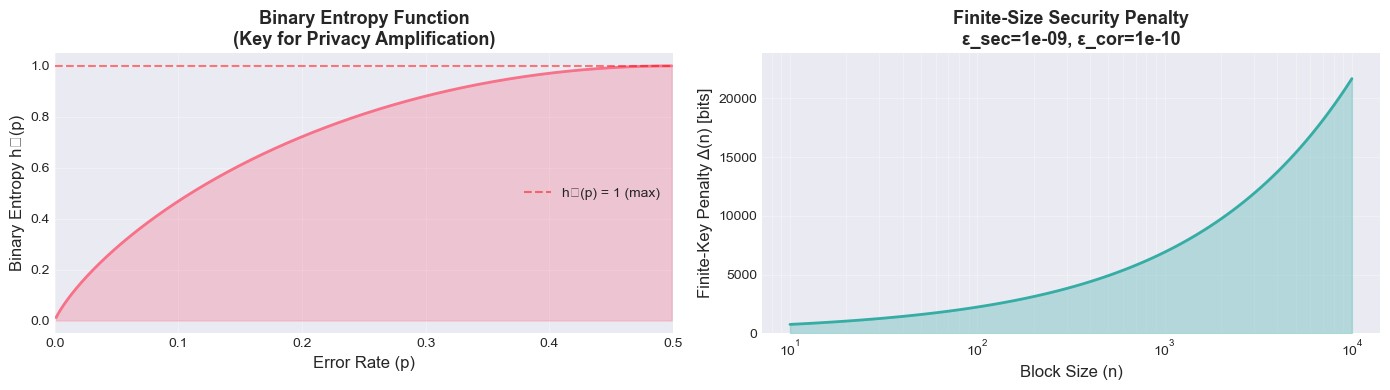

📊 These functions are critical for finite-key security analysis!


In [2]:
def binary_entropy(p: np.ndarray) -> np.ndarray:
    """
    Binary entropy h_2(p) = -p*log2(p) - (1-p)*log2(1-p).
    
    Args:
        p: Error rate (scalar or array), 0 < p < 1.
    Returns:
        Binary entropy value(s).
    Raises:
        TypeError: If p is not a number or array.
    """
    if not isinstance(p, (int, float, np.ndarray)):
        raise TypeError("Input p must be a number or array")
    p = np.asarray(p)
    p = np.clip(p, 1e-10, 1 - 1e-10)
    return np.where((p <= 0) | (p >= 1), 0.0, -p * np.log2(p) - (1 - p) * np.log2(1 - p))

def finite_key_penalty(eps_sec: float, eps_cor: float, n: np.ndarray) -> np.ndarray:
    """
    Finite-size correction: Δ ≈ 7√n · log₂(2/ε_sec) + 2·log₂(1/ε_cor).
    
    Args:
        eps_sec: Security parameter (probability of insecurity).
        eps_cor: Correctness parameter (probability of mismatch).
        n: Block size (scalar or array).
    Returns:
        Penalty value(s) in bits.
    Raises:
        ValueError: If eps_sec, eps_cor, or n are invalid.
    """
    if eps_sec <= 0 or eps_cor <= 0:
        raise ValueError("Epsilon parameters must be positive")
    if not isinstance(n, (int, float, np.ndarray)):
        raise TypeError("Input n must be a number or array")
    n = np.asarray(n)
    return np.where(n <= 0, np.inf, 7 * np.sqrt(n) * np.log2(2 / eps_sec) + 2 * np.log2(1 / eps_cor))

# Visualization
p_range = np.linspace(0.001, 0.499, 1000)
h2_values = binary_entropy(p_range)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
colors = sns.color_palette("husl", 2)

# Binary entropy
ax1.plot(p_range, h2_values, linewidth=2, color=colors[0])
ax1.axhline(y=1, color='red', linestyle='--', alpha=0.5, label='h₂(p) = 1 (max)')
ax1.fill_between(p_range, 0, h2_values, alpha=0.3, color=colors[0])
ax1.set_xlabel('Error Rate (p)', fontsize=12)
ax1.set_ylabel('Binary Entropy h₂(p)', fontsize=12)
ax1.set_title('Binary Entropy Function\n(Key for Privacy Amplification)', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_xlim(0, 0.5)

# Finite-key penalty
n_values = np.logspace(1, 4, 100)
eps_sec, eps_cor = 1e-9, 1e-10
penalties = finite_key_penalty(eps_sec, eps_cor, n_values)

ax2.semilogx(n_values, penalties, linewidth=2, color=colors[1])
ax2.fill_between(n_values, 0, penalties, alpha=0.3, color=colors[1])
ax2.set_xlabel('Block Size (n)', fontsize=12)
ax2.set_ylabel('Finite-Key Penalty Δ(n) [bits]', fontsize=12)
ax2.set_title(f'Finite-Size Security Penalty\nε_sec={eps_sec}, ε_cor={eps_cor}', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, which='both')
ax2.set_ylim(0, max(penalties) * 1.1)

plt.tight_layout()
plt.show()

print("📊 These functions are critical for finite-key security analysis!")

Step-3 Visualize BB84 States

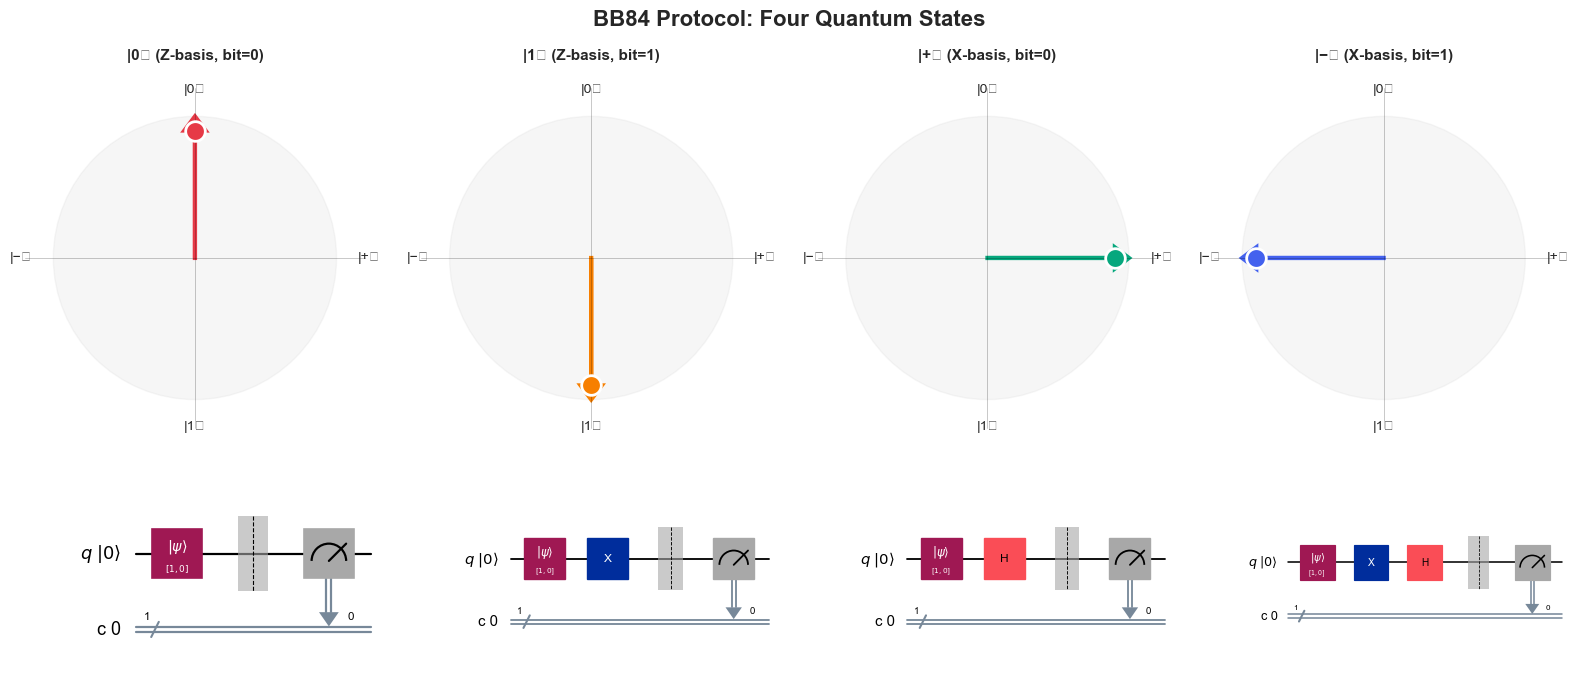


                         BB84 ENCODING SCHEME                         


Basis,Bit Value,Quantum State,Preparation
Z (Computational),0,|0⟩,Initialize |0⟩
Z (Computational),1,|1⟩,X gate on |0⟩
X (Hadamard),0,|+⟩ = (|0⟩+|1⟩)/√2,H gate on |0⟩
X (Hadamard),1,|−⟩ = (|0⟩−|1⟩)/√2,X then H on |0⟩


In [3]:
# Cell 4: BB84 Quantum States Visualizatio

def visualize_bb84_states():
    """Visualize the 4 BB84 quantum states on Bloch sphere representation"""
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    # State definitions
    states = {
        '|0⟩ (Z-basis, bit=0)': {'basis': 'Z', 'bit': 0, 'color': '#E63946'},
        '|1⟩ (Z-basis, bit=1)': {'basis': 'Z', 'bit': 1, 'color': '#F77F00'},
        '|+⟩ (X-basis, bit=0)': {'basis': 'X', 'bit': 0, 'color': '#06A77D'},
        '|−⟩ (X-basis, bit=1)': {'basis': 'X', 'bit': 1, 'color': '#4361EE'},
    }
    
    # Bloch sphere coordinates (simplified 2D projection)
    bloch_coords = {
        '|0⟩ (Z-basis, bit=0)': (0, 1),      # North pole
        '|1⟩ (Z-basis, bit=1)': (0, -1),     # South pole
        '|+⟩ (X-basis, bit=0)': (1, 0),      # +X
        '|−⟩ (X-basis, bit=1)': (-1, 0),     # -X
    }
    
    for idx, (state_name, info) in enumerate(states.items()):
        # Top row: Bloch representation
        ax_bloch = axes[0, idx]
        circle = plt.Circle((0, 0), 1, color='lightgray', alpha=0.2)
        ax_bloch.add_patch(circle)
        
        # Draw axes
        ax_bloch.plot([-1.2, 1.2], [0, 0], 'k-', alpha=0.3, linewidth=0.5)
        ax_bloch.plot([0, 0], [-1.2, 1.2], 'k-', alpha=0.3, linewidth=0.5)
        
        # Plot state
        x, z = bloch_coords[state_name]
        ax_bloch.arrow(0, 0, x*0.9, z*0.9, head_width=0.15, head_length=0.1, 
                       fc=info['color'], ec=info['color'], linewidth=3)
        ax_bloch.scatter([x*0.9], [z*0.9], s=200, c=[info['color']], 
                        edgecolors='white', linewidths=2, zorder=5)
        
        ax_bloch.set_xlim(-1.3, 1.3)
        ax_bloch.set_ylim(-1.3, 1.3)
        ax_bloch.set_aspect('equal')
        ax_bloch.axis('off')
        ax_bloch.set_title(state_name, fontsize=11, fontweight='bold', pad=10)
        
        # Add labels
        ax_bloch.text(1.15, 0, '|+⟩', fontsize=10, ha='left', va='center')
        ax_bloch.text(-1.15, 0, '|−⟩', fontsize=10, ha='right', va='center')
        ax_bloch.text(0, 1.15, '|0⟩', fontsize=10, ha='center', va='bottom')
        ax_bloch.text(0, -1.15, '|1⟩', fontsize=10, ha='center', va='top')
        
        # Bottom row: Quantum circuits
        ax_circ = axes[1, idx]
        ax_circ.axis('off')
        
        # Create quantum circuit
        qc = QuantumCircuit(1, 1)
        qc.initialize([1, 0], 0)  # Start from |0⟩
        
        if info['bit'] == 1:
            qc.x(0)  # Flip to |1⟩
        if info['basis'] == 'X':
            qc.h(0)  # Apply Hadamard for X-basis
        
        qc.barrier()
        qc.measure(0, 0)
        
        # Draw circuit
        circuit_img = qc.draw('mpl', style='iqp', ax=ax_circ, initial_state=True)
    
    plt.suptitle('BB84 Protocol: Four Quantum States', fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()
    
    # Create encoding table
    print("\n" + "="*70)
    print("BB84 ENCODING SCHEME".center(70))
    print("="*70)
    
    encoding_data = {
        'Basis': ['Z (Computational)', 'Z (Computational)', 'X (Hadamard)', 'X (Hadamard)'],
        'Bit Value': ['0', '1', '0', '1'],
        'Quantum State': ['|0⟩', '|1⟩', '|+⟩ = (|0⟩+|1⟩)/√2', '|−⟩ = (|0⟩−|1⟩)/√2'],
        'Preparation': ['Initialize |0⟩', 'X gate on |0⟩', 'H gate on |0⟩', 'X then H on |0⟩'],
    }
    
    df = pd.DataFrame(encoding_data)
    display(HTML(df.to_html(index=False, justify='center')))
    print("="*70)

visualize_bb84_states()

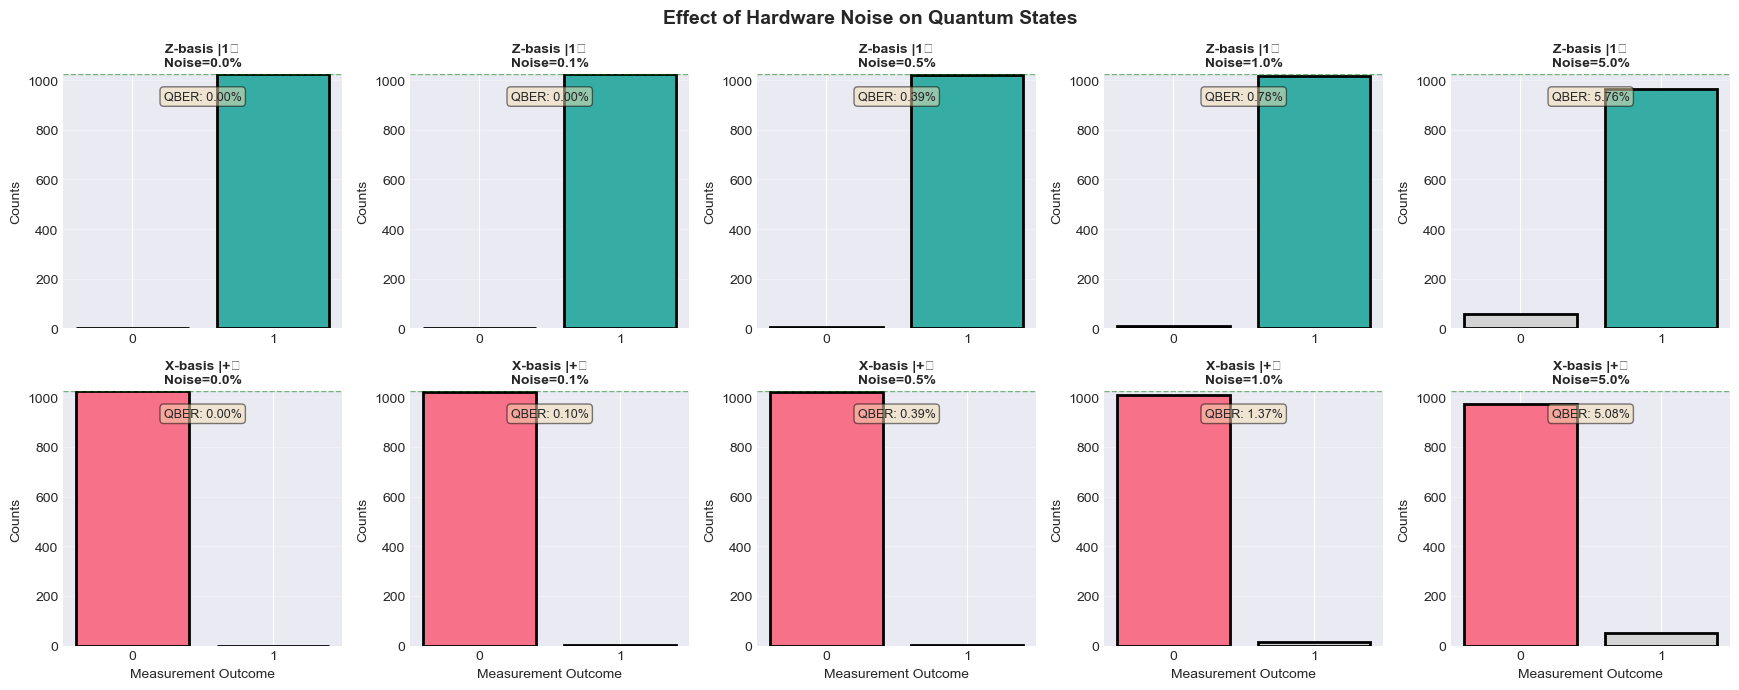


📌 Key Observation:
   As noise increases, QBER rises, reducing secure key rate via binary entropy (h₂(QBER)).


In [4]:
def create_realistic_noise_model(p_depol: float = 0.001, p_readout: float = 0.02) -> NoiseModel:
    """
    IBM-like hardware noise:
    - Depolarizing error on gates
    - Readout error on measurements
    """
    if not (0 <= p_depol <= 1 and 0 <= p_readout <= 1):
        raise ValueError("Noise probabilities must be between 0 and 1")
    noise_model = NoiseModel()
    error_gate = depolarizing_error(p_depol, 1)
    noise_model.add_all_qubit_quantum_error(error_gate, ['h', 'x', 'id'])
    error_meas = pauli_error([('X', p_readout), ('I', 1 - p_readout)])
    noise_model.add_all_qubit_quantum_error(error_meas, "measure")
    return noise_model

def visualize_noise_effects(n_shots: int = 1024, noise_levels: list = [0.0, 0.001, 0.005, 0.01, 0.05]):
    """Visualize how different noise levels affect BB84 quantum states."""
    colors = sns.color_palette("husl", 2)
    fig, axes = plt.subplots(2, len(noise_levels), figsize=(3.5 * len(noise_levels), 7))
    
    for idx, noise in enumerate(noise_levels):
        # Test Z-basis state |1⟩
        qc_z = QuantumCircuit(1, 1)
        qc_z.x(0)  # Prepare |1⟩
        qc_z.measure(0, 0)
        
        # Test X-basis state |+⟩
        qc_x = QuantumCircuit(1, 1)
        qc_x.h(0)  # Prepare |+⟩
        qc_x.h(0)  # Measure in X-basis
        qc_x.measure(0, 0)
        
        # Simulate with noise
        simulator = AerSimulator(noise_model=create_realistic_noise_model(p_depol=noise/10, p_readout=noise)) if noise > 0 else AerSimulator()
        qc_z = transpile(qc_z, simulator)
        qc_x = transpile(qc_x, simulator)
        
        # Run circuits
        result_z = simulator.run(qc_z, shots=n_shots).result()
        result_x = simulator.run(qc_x, shots=n_shots).result()
        
        counts_z = result_z.get_counts()
        counts_x = result_x.get_counts()
        
        # Plot Z-basis
        ax_z = axes[0, idx]
        states = ['0', '1']
        heights = [counts_z.get('0', 0), counts_z.get('1', 0)]
        z_colors = [colors[1] if s == '1' else '#D3D3D3' for s in states]
        ax_z.bar(states, heights, color=z_colors, edgecolor='black', linewidth=2)
        ax_z.set_ylim(0, n_shots)
        ax_z.set_ylabel('Counts', fontsize=10)
        ax_z.set_title(f'Z-basis |1⟩\nNoise={noise:.1%}', fontsize=10, fontweight='bold')
        ax_z.axhline(y=n_shots, linestyle='--', color='green', alpha=0.5, linewidth=1)
        ax_z.grid(True, axis='y', alpha=0.3)
        
        qber_z = counts_z.get('0', 0) / n_shots
        ax_z.text(0.5, n_shots*0.9, f'QBER: {qber_z:.2%}', 
                 ha='center', fontsize=9, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        # Plot X-basis
        ax_x = axes[1, idx]
        heights = [counts_x.get('0', 0), counts_x.get('1', 0)]
        x_colors = [colors[0] if s == '0' else '#D3D3D3' for s in states]
        ax_x.bar(states, heights, color=x_colors, edgecolor='black', linewidth=2)
        ax_x.set_ylim(0, n_shots)
        ax_x.set_xlabel('Measurement Outcome', fontsize=10)
        ax_x.set_ylabel('Counts', fontsize=10)
        ax_x.set_title(f'X-basis |+⟩\nNoise={noise:.1%}', fontsize=10, fontweight='bold')
        ax_x.axhline(y=n_shots, linestyle='--', color='green', alpha=0.5, linewidth=1)
        ax_x.grid(True, axis='y', alpha=0.3)
        
        qber_x = counts_x.get('1', 0) / n_shots
        ax_x.text(0.5, n_shots*0.9, f'QBER: {qber_x:.2%}', 
                 ha='center', fontsize=9, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.suptitle('Effect of Hardware Noise on Quantum States', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("\n📌 Key Observation:")
    print("   As noise increases, QBER rises, reducing secure key rate via binary entropy (h₂(QBER)).")

visualize_noise_effects()

In [5]:
from collections import Counter
from ipywidgets import interact, IntSlider, Checkbox

def alice_prepare_qubits(n_qubits: int = 16, seed: int = 42, visualize: bool = True):
    """
    Alice prepares n_qubits with random bits and bases for BB84.
    
    Args:
        n_qubits: Number of qubits to prepare (default: 16).
        seed: Random seed for reproducibility (default: 42).
        visualize: Whether to display plots and summary (default: True).
    
    Returns:
        tuple: (alice_bits, alice_bases) as NumPy arrays (0=Z, 1=X for bases).
    """
    if not isinstance(n_qubits, int) or n_qubits <= 0:
        raise ValueError("n_qubits must be a positive integer")
    if visualize and n_qubits > 50:
        raise ValueError("n_qubits > 50 may produce crowded plots")
    
    np.random.seed(seed)
    alice_bits = np.random.randint(0, 2, n_qubits)
    alice_bases = np.random.randint(0, 2, n_qubits)
    
    if visualize:
        colors = sns.color_palette("husl", 4)
        state_colors = {r'|0\rangle': colors[0], r'|1\rangle': colors[1], r'|+\rangle': colors[2], r'|-\rangle': colors[3]}
        state_map = {(0, 0): r'|0\rangle', (1, 0): r'|1\rangle', (0, 1): r'|+\rangle', (1, 1): r'|-\rangle'}
        
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(0.5 * n_qubits, 8))
        x_pos = np.arange(n_qubits)
        
        # Plot 1: Bits
        colors_bits = [state_colors[state_map[(b, 0)]] for b in alice_bits]
        ax1.bar(x_pos, np.ones(n_qubits), color=colors_bits, edgecolor='black', linewidth=1.5)
        ax1.set_ylabel('Bit Value', fontsize=12, fontweight='bold')
        ax1.set_ylim(0, 1.5)
        ax1.set_xticks(x_pos)
        ax1.set_xticklabels([])
        ax1.set_title("Alice's Random Bits", fontsize=13, fontweight='bold')
        for i, bit in enumerate(alice_bits):
            ax1.text(i, 0.5, str(bit), ha='center', va='center', fontsize=11, fontweight='bold', color='white')
        
        # Plot 2: Bases
        colors_bases = [colors[3] if b == 1 else colors[2] for b in alice_bases]
        basis_labels = ['X' if b == 1 else 'Z' for b in alice_bases]
        ax2.bar(x_pos, np.ones(n_qubits), color=colors_bases, edgecolor='black', linewidth=1.5)
        ax2.set_ylabel('Basis Choice', fontsize=12, fontweight='bold')
        ax2.set_ylim(0, 1.5)
        ax2.set_xticks(x_pos)
        ax2.set_xticklabels([])
        ax2.set_title("Alice's Random Bases (Z=Computational, X=Hadamard)", fontsize=13, fontweight='bold')
        for i, label in enumerate(basis_labels):
            ax2.text(i, 0.5, label, ha='center', va='center', fontsize=11, fontweight='bold', color='white')
        
        # Plot 3: Quantum States
        states = [state_map[(alice_bits[i], alice_bases[i])] for i in range(n_qubits)]
        colors_states = [state_colors[s] for s in states]
        ax3.bar(x_pos, np.ones(n_qubits), color=colors_states, edgecolor='black', linewidth=1.5)
        ax3.set_ylabel('Quantum State', fontsize=12, fontweight='bold')
        ax3.set_xlabel('Qubit Index', fontsize=12, fontweight='bold')
        ax3.set_ylim(0, 1.5)
        ax3.set_xticks(x_pos)
        ax3.set_xticklabels(x_pos)
        ax3.set_title("Prepared Quantum States (sent to Bob)", fontsize=13, fontweight='bold')
        for i, state in enumerate(states):
            ax3.text(i, 0.5, state, ha='center', va='center', fontsize=10, fontweight='bold', color='white')
        
        plt.tight_layout()
        plt.show()
        
        # Statistics
        print("\n" + "="*70)
        print("ALICE'S PREPARATION SUMMARY".center(70))
        print("="*70)
        print(f"Total qubits prepared: {n_qubits}")
        print(f"Bits distribution: {np.sum(alice_bits)} ones, {n_qubits - np.sum(alice_bits)} zeros")
        print(f"Bases distribution: {np.sum(alice_bases)} X-basis, {n_qubits - np.sum(alice_bases)} Z-basis")
        print(f"\nState counts:")
        state_counts = Counter(states)
        state_list = [r'|0\rangle', r'|1\rangle', r'|+\rangle', r'|-\rangle']
        for state in state_list:
            count = state_counts.get(state, 0)
            print(f"  {state}: {count} ({count/n_qubits*100:.1f}%)")
        print("="*70)
    
    return alice_bits, alice_bases

# Interactive execution
interact(alice_prepare_qubits, 
         n_qubits=IntSlider(min=1, max=64, step=1, value=32, description='Qubits'),
         seed=IntSlider(min=0, max=100, step=1, value=42, description='Seed'),
         visualize=Checkbox(value=True, description='Visualize'))

interactive(children=(IntSlider(value=32, description='Qubits', max=64, min=1), IntSlider(value=42, descriptio…

<function __main__.alice_prepare_qubits(n_qubits: int = 16, seed: int = 42, visualize: bool = True)>

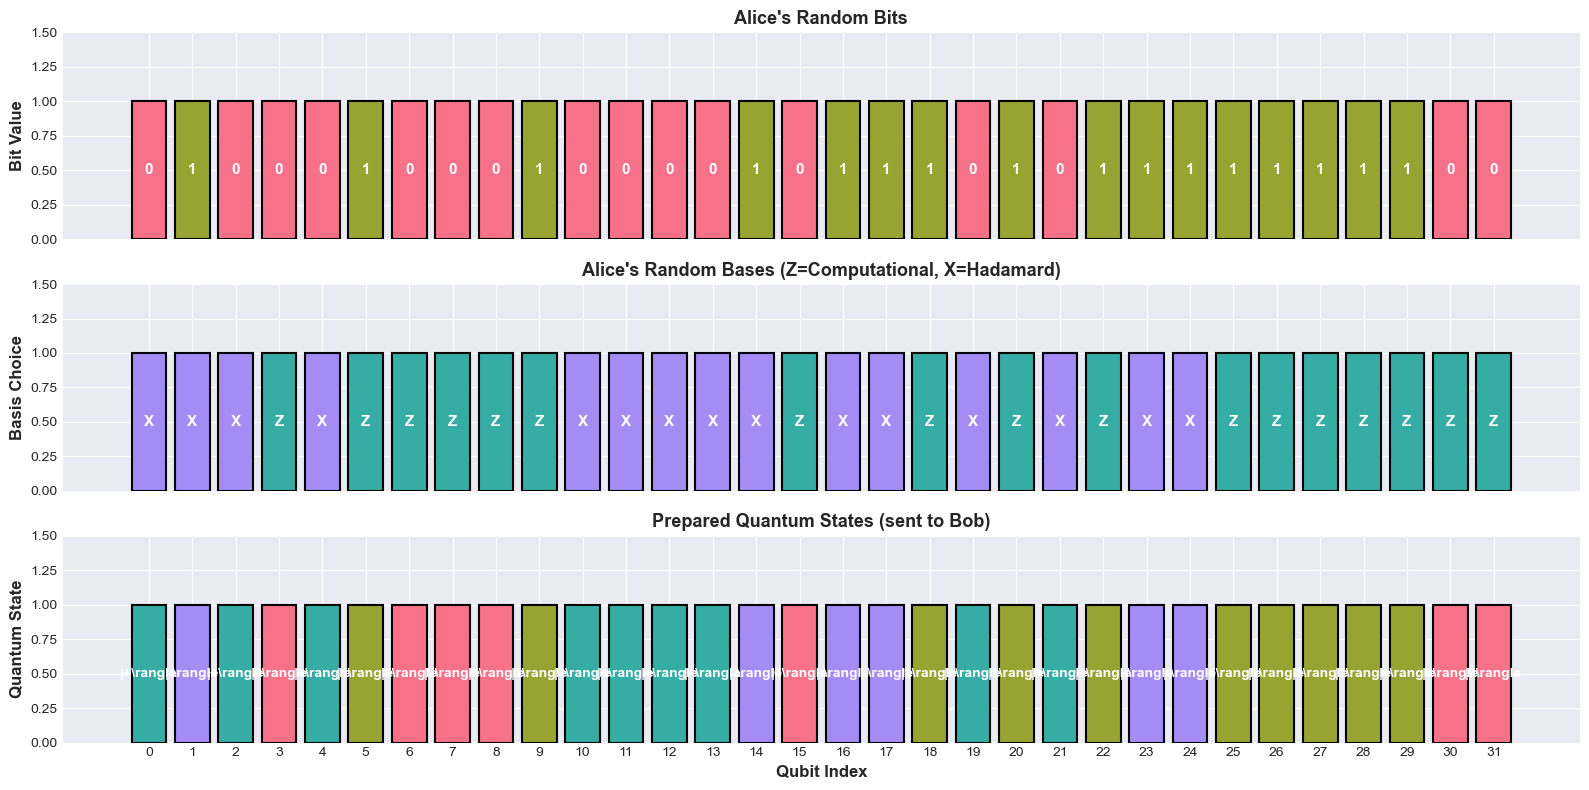


                     ALICE'S PREPARATION SUMMARY                      
Total qubits prepared: 32
Bits distribution: 16 ones, 16 zeros
Bases distribution: 15 X-basis, 17 Z-basis

State counts:
  |0\rangle: 7 (21.9%)
  |1\rangle: 10 (31.2%)
  |+\rangle: 9 (28.1%)
  |-\rangle: 6 (18.8%)


interactive(children=(FloatSlider(value=0.001, description='Depol Noise', max=0.1, step=0.001), FloatSlider(va…

<function __main__.bob_measure_qubits(alice_bits: numpy.ndarray, alice_bases: numpy.ndarray, p_depol: float = 0.001, p_readout: float = 0.02, seed: int = 43, visualize: bool = True) -> tuple[numpy.ndarray, numpy.ndarray]>

In [8]:
import ipywidgets as widgets
from ipywidgets import interact, FloatSlider, Checkbox, IntSlider
# Step 4: Noise Model
def create_realistic_noise_model(p_depol: float = 0.001, p_readout: float = 0.02) -> NoiseModel:
    """
    IBM-like hardware noise:
    - Depolarizing error on gates
    - Readout error on measurements
    """
    if not (0 <= p_depol <= 1 and 0 <= p_readout <= 1):
        raise ValueError("Noise probabilities must be between 0 and 1")
    noise_model = NoiseModel()
    error_gate = depolarizing_error(p_depol, 1)
    noise_model.add_all_qubit_quantum_error(error_gate, ['h', 'x', 'id'])
    error_meas = pauli_error([('X', p_readout), ('I', 1 - p_readout)])
    noise_model.add_all_qubit_quantum_error(error_meas, "measure")
    return noise_model

# Step 5: Alice's Preparation
def alice_prepare_qubits(n_qubits: int = 32, seed: int = 42, visualize: bool = True):
    """
    Alice prepares n_qubits with random bits and bases for BB84.
    
    Args:
        n_qubits: Number of qubits to prepare (default: 32).
        seed: Random seed for reproducibility (default: 42).
        visualize: Whether to display plots and summary (default: True).
    
    Returns:
        tuple: (alice_bits, alice_bases) as NumPy arrays (0=Z, 1=X for bases).
    """
    if not isinstance(n_qubits, int) or n_qubits <= 0:
        raise ValueError("n_qubits must be a positive integer")
    if visualize and n_qubits > 50:
        raise ValueError("n_qubits > 50 may produce crowded plots")
    
    np.random.seed(seed)
    alice_bits = np.random.randint(0, 2, n_qubits)
    alice_bases = np.random.randint(0, 2, n_qubits)
    
    if visualize:
        colors = sns.color_palette("husl", 4)
        state_colors = {r'|0\rangle': colors[0], r'|1\rangle': colors[1], r'|+\rangle': colors[2], r'|-\rangle': colors[3]}
        state_map = {(0, 0): r'|0\rangle', (1, 0): r'|1\rangle', (0, 1): r'|+\rangle', (1, 1): r'|-\rangle'}
        
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(0.5 * n_qubits, 8))
        x_pos = np.arange(n_qubits)
        
        # Plot 1: Bits
        colors_bits = [state_colors[state_map[(b, 0)]] for b in alice_bits]
        ax1.bar(x_pos, np.ones(n_qubits), color=colors_bits, edgecolor='black', linewidth=1.5)
        ax1.set_ylabel('Bit Value', fontsize=12, fontweight='bold')
        ax1.set_ylim(0, 1.5)
        ax1.set_xticks(x_pos)
        ax1.set_xticklabels([])
        ax1.set_title("Alice's Random Bits", fontsize=13, fontweight='bold')
        for i, bit in enumerate(alice_bits):
            ax1.text(i, 0.5, str(bit), ha='center', va='center', fontsize=11, fontweight='bold', color='white')
        
        # Plot 2: Bases
        colors_bases = [colors[3] if b == 1 else colors[2] for b in alice_bases]
        basis_labels = ['X' if b == 1 else 'Z' for b in alice_bases]
        ax2.bar(x_pos, np.ones(n_qubits), color=colors_bases, edgecolor='black', linewidth=1.5)
        ax2.set_ylabel('Basis Choice', fontsize=12, fontweight='bold')
        ax2.set_ylim(0, 1.5)
        ax2.set_xticks(x_pos)
        ax2.set_xticklabels([])
        ax2.set_title("Alice's Random Bases (Z=Computational, X=Hadamard)", fontsize=13, fontweight='bold')
        for i, label in enumerate(basis_labels):
            ax2.text(i, 0.5, label, ha='center', va='center', fontsize=11, fontweight='bold', color='white')
        
        # Plot 3: Quantum States
        states = [state_map[(alice_bits[i], alice_bases[i])] for i in range(n_qubits)]
        colors_states = [state_colors[s] for s in states]
        ax3.bar(x_pos, np.ones(n_qubits), color=colors_states, edgecolor='black', linewidth=1.5)
        ax3.set_ylabel('Quantum State', fontsize=12, fontweight='bold')
        ax3.set_xlabel('Qubit Index', fontsize=12, fontweight='bold')
        ax3.set_ylim(0, 1.5)
        ax3.set_xticks(x_pos)
        ax3.set_xticklabels(x_pos)
        ax3.set_title("Prepared Quantum States (sent to Bob)", fontsize=13, fontweight='bold')
        for i, state in enumerate(states):
            ax3.text(i, 0.5, state, ha='center', va='center', fontsize=10, fontweight='bold', color='white')
        
        plt.tight_layout()
        plt.show()
        
        # Statistics
        print("\n" + "="*70)
        print("ALICE'S PREPARATION SUMMARY".center(70))
        print("="*70)
        print(f"Total qubits prepared: {n_qubits}")
        print(f"Bits distribution: {np.sum(alice_bits)} ones, {n_qubits - np.sum(alice_bits)} zeros")
        print(f"Bases distribution: {np.sum(alice_bases)} X-basis, {n_qubits - np.sum(alice_bases)} Z-basis")
        print(f"\nState counts:")
        state_counts = Counter(states)
        state_list = [r'|0\rangle', r'|1\rangle', r'|+\rangle', r'|-\rangle']
        for state in state_list:
            count = state_counts.get(state, 0)
            print(f"  {state}: {count} ({count/n_qubits*100:.1f}%)")
        print("="*70)
    
    return alice_bits, alice_bases

# Step 6: Bob's Measurement
def bob_measure_qubits(alice_bits: np.ndarray, alice_bases: np.ndarray, 
                      p_depol: float = 0.001, p_readout: float = 0.02, 
                      seed: int = 43, visualize: bool = True) -> tuple[np.ndarray, np.ndarray]:
    """
    Bob independently chooses random measurement bases and measures Alice's qubits.
    
    Args:
        alice_bits: Array of Alice's random bits (0 or 1).
        alice_bases: Array of Alice's random bases (0=Z, 1=X).
        p_depol: Depolarizing error probability (default: 0.001).
        p_readout: Readout error probability (default: 0.02).
        seed: Random seed for reproducibility (default: 43).
        visualize: Whether to display plots and summary (default: True).
    
    Returns:
        tuple: (bob_bases, bob_bits) as NumPy arrays (0=Z, 1=X for bases, 0/1 for bits).
    """
    n_qubits = len(alice_bits)
    if not isinstance(n_qubits, int) or n_qubits <= 0:
        raise ValueError("n_qubits must be a positive integer")
    if len(alice_bases) != n_qubits:
        raise ValueError("alice_bits and alice_bases must have the same length")
    if visualize and n_qubits > 50:
        raise ValueError("n_qubits > 50 may produce crowded plots")
    
    np.random.seed(seed)
    bob_bases = np.random.randint(0, 2, n_qubits)
    
    # Simulate measurements
    noise_model = create_realistic_noise_model(p_depol, p_readout) if p_depol > 0 or p_readout > 0 else None
    simulator = AerSimulator(noise_model=noise_model) if noise_model else AerSimulator()
    circuits = []
    
    for i in range(n_qubits):
        qc = QuantumCircuit(1, 1)
        if alice_bits[i] == 1:
            qc.x(0)
        if alice_bases[i] == 1:
            qc.h(0)
        if bob_bases[i] == 1:
            qc.h(0)  # Measure in X-basis
        qc.measure(0, 0)
        circuits.append(qc)
    
    circuits = transpile(circuits, simulator)
    results = simulator.run(circuits, shots=1).result()
    bob_bits = [int(list(results.get_counts(i).keys())[0]) for i in range(n_qubits)]
    
    if visualize:
        colors = sns.color_palette("husl", 4)
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(0.5 * n_qubits, 6))
        x_pos = np.arange(n_qubits)
        
        # Plot 1: Bases
        colors_bases = [colors[3] if b == 1 else colors[2] for b in bob_bases]
        basis_labels = ['X' if b == 1 else 'Z' for b in bob_bases]
        ax1.bar(x_pos, np.ones(n_qubits), color=colors_bases, edgecolor='black', linewidth=1.5)
        ax1.set_ylabel('Basis Choice', fontsize=12, fontweight='bold')
        ax1.set_ylim(0, 1.5)
        ax1.set_xticks(x_pos)
        ax1.set_xticklabels([])
        ax1.set_title("Bob's Random Measurement Bases", fontsize=13, fontweight='bold')
        for i, label in enumerate(basis_labels):
            ax1.text(i, 0.5, label, ha='center', va='center', fontsize=11, fontweight='bold', color='white')
        
        # Plot 2: Measurement Outcomes
        colors_bits = [colors[1] if b == 1 else colors[0] for b in bob_bits]
        ax2.bar(x_pos, np.ones(n_qubits), color=colors_bits, edgecolor='black', linewidth=1.5)
        ax2.set_ylabel('Measurement Outcome', fontsize=12, fontweight='bold')
        ax2.set_xlabel('Qubit Index', fontsize=12, fontweight='bold')
        ax2.set_ylim(0, 1.5)
        ax2.set_xticks(x_pos)
        ax2.set_xticklabels(x_pos)
        ax2.set_title("Bob's Measurement Outcomes", fontsize=13, fontweight='bold')
        for i, bit in enumerate(bob_bits):
            ax2.text(i, 0.5, str(bit), ha='center', va='center', fontsize=11, fontweight='bold', color='white')
        
        plt.tight_layout()
        plt.show()
        
        # Summary
        basis_counts = Counter(basis_labels)
        bit_counts = Counter(bob_bits)
        matching_bases = np.sum(alice_bases == bob_bases)
        print("\n" + "="*70)
        print("BOB'S MEASUREMENT SUMMARY".center(70))
        print("="*70)
        print(f"Total qubits measured: {n_qubits}")
        print(f"Bases distribution: {basis_counts['X']} X-basis, {basis_counts['Z']} Z-basis")
        print(f"Bit distribution: {bit_counts[1]} ones, {bit_counts[0]} zeros")
        print(f"Matching bases (sifted key length): {matching_bases} ({matching_bases/n_qubits*100:.1f}%)")
        print("="*70)
    
    return bob_bases, bob_bits

# Run Step 5 to define alice_bits and alice_bases
alice_bits, alice_bases = alice_prepare_qubits(n_qubits=32, seed=42, visualize=True)

# Interactive execution for Step 6
interact(bob_measure_qubits,
         alice_bits=widgets.fixed(alice_bits),
         alice_bases=widgets.fixed(alice_bases),
         p_depol=FloatSlider(min=0, max=0.1, step=0.001, value=0.001, description='Depol Noise'),
         p_readout=FloatSlider(min=0, max=0.1, step=0.001, value=0.02, description='Readout Noise'),
         seed=IntSlider(min=0, max=100, step=1, value=43, description='Seed'),
         visualize=Checkbox(value=True, description='Visualize'))

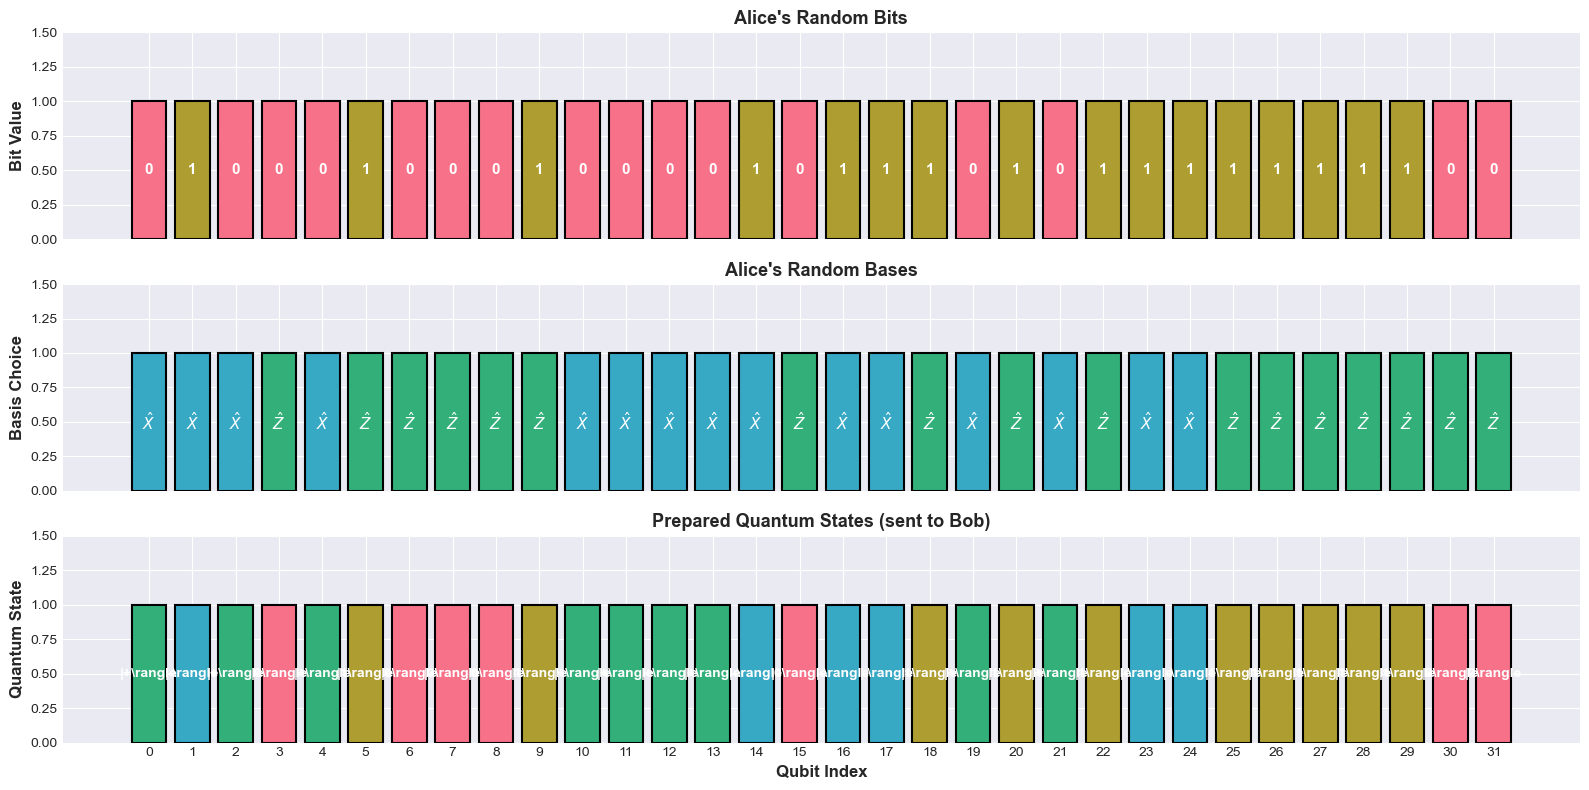


                     ALICE'S PREPARATION SUMMARY                      
Total qubits prepared: 32
Bits distribution: 16 ones, 16 zeros
Bases distribution: 15 X-basis, 17 Z-basis

State counts:
  |0\rangle: 7 (21.9%)
  |1\rangle: 10 (31.2%)
  |+\rangle: 9 (28.1%)
  |-\rangle: 6 (18.8%)


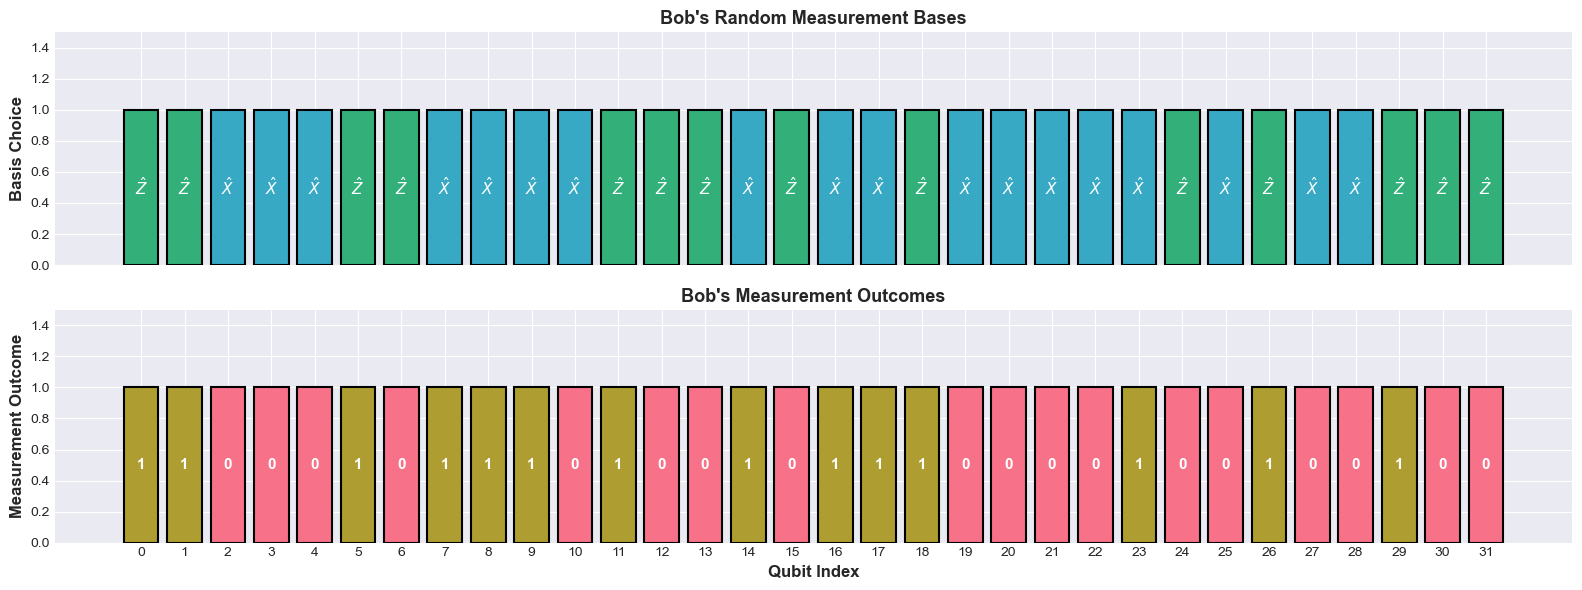


                      BOB'S MEASUREMENT SUMMARY                       
Total qubits measured: 32
Bases distribution: 18 X-basis, 14 Z-basis
Bit distribution: 14 ones, 18 zeros
Matching bases: 17 (53.1%)


interactive(children=(FloatSlider(value=0.001, description='Depol Noise', max=0.1, step=0.001), FloatSlider(va…

In [9]:

import ipywidgets as widgets
from qiskit.visualization import circuit_drawer
# Step 4: Noise Model
def create_realistic_noise_model(p_depol: float = 0.001, p_readout: float = 0.02) -> NoiseModel:
    """
    IBM-like hardware noise:
    - Depolarizing error on gates
    - Readout error on measurements
    """
    if not (0 <= p_depol <= 1 and 0 <= p_readout <= 1):
        raise ValueError("Noise probabilities must be between 0 and 1")
    noise_model = NoiseModel()
    error_gate = depolarizing_error(p_depol, 1)
    noise_model.add_all_qubit_quantum_error(error_gate, ['h', 'x', 'id'])
    error_meas = pauli_error([('X', p_readout), ('I', 1 - p_readout)])
    noise_model.add_all_qubit_quantum_error(error_meas, "measure")
    return noise_model

# Step 5: Alice's Preparation
def alice_prepare_qubits(n_qubits: int = 32, seed: int = 42, visualize: bool = True):
    """
    Alice prepares n_qubits with random bits and bases for BB84.
    
    Args:
        n_qubits: Number of qubits to prepare (default: 32).
        seed: Random seed for reproducibility (default: 42).
        visualize: Whether to display plots and summary (default: True).
    
    Returns:
        tuple: (alice_bits, alice_bases) as NumPy arrays (0=Z, 1=X for bases).
    """
    if not isinstance(n_qubits, int) or n_qubits <= 0:
        raise ValueError("n_qubits must be a positive integer")
    if visualize and n_qubits > 50:
        raise ValueError("n_qubits > 50 may produce crowded plots")
    
    np.random.seed(seed)
    alice_bits = np.array(np.random.randint(0, 2, n_qubits), dtype=int)
    alice_bases = np.array(np.random.randint(0, 2, n_qubits), dtype=int)
    
    if visualize:
        colors = sns.color_palette("husl", 5)
        state_colors = {r'|0\rangle': colors[0], r'|1\rangle': colors[1], r'|+\rangle': colors[2], r'|-\rangle': colors[3]}
        state_map = {(0, 0): r'|0\rangle', (1, 0): r'|1\rangle', (0, 1): r'|+\rangle', (1, 1): r'|-\rangle'}
        
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(max(10, 0.5 * n_qubits), 8))
        x_pos = np.arange(n_qubits)
        
        colors_bits = [state_colors[state_map[(b, 0)]] for b in alice_bits]
        ax1.bar(x_pos, np.ones(n_qubits), color=colors_bits, edgecolor='black', linewidth=1.5)
        ax1.set_ylabel('Bit Value', fontsize=12, fontweight='bold')
        ax1.set_ylim(0, 1.5)
        ax1.set_xticks(x_pos)
        ax1.set_xticklabels([])
        ax1.set_title("Alice's Random Bits", fontsize=13, fontweight='bold')
        for i, bit in enumerate(alice_bits):
            ax1.text(i, 0.5, str(bit), ha='center', va='center', fontsize=11, fontweight='bold', color='white')
        
        colors_bases = [colors[3] if b == 1 else colors[2] for b in alice_bases]
        basis_labels = [r'$\hat{X}$' if b == 1 else r'$\hat{Z}$' for b in alice_bases]
        ax2.bar(x_pos, np.ones(n_qubits), color=colors_bases, edgecolor='black', linewidth=1.5)
        ax2.set_ylabel('Basis Choice', fontsize=12, fontweight='bold')
        ax2.set_ylim(0, 1.5)
        ax2.set_xticks(x_pos)
        ax2.set_xticklabels([])
        ax2.set_title("Alice's Random Bases", fontsize=13, fontweight='bold')
        for i, label in enumerate(basis_labels):
            ax2.text(i, 0.5, label, ha='center', va='center', fontsize=11, fontweight='bold', color='white')
        
        states = [state_map[(alice_bits[i], alice_bases[i])] for i in range(n_qubits)]
        colors_states = [state_colors[s] for s in states]
        ax3.bar(x_pos, np.ones(n_qubits), color=colors_states, edgecolor='black', linewidth=1.5)
        ax3.set_ylabel('Quantum State', fontsize=12, fontweight='bold')
        ax3.set_xlabel('Qubit Index', fontsize=12, fontweight='bold')
        ax3.set_ylim(0, 1.5)
        ax3.set_xticks(x_pos)
        ax3.set_xticklabels(x_pos)
        ax3.set_title("Prepared Quantum States (sent to Bob)", fontsize=13, fontweight='bold')
        for i, state in enumerate(states):
            ax3.text(i, 0.5, state, ha='center', va='center', fontsize=10, fontweight='bold', color='white')
        
        plt.tight_layout()
        plt.show()
        
        print("\n" + "="*70)
        print("ALICE'S PREPARATION SUMMARY".center(70))
        print("="*70)
        print(f"Total qubits prepared: {n_qubits}")
        print(f"Bits distribution: {np.sum(alice_bits)} ones, {n_qubits - np.sum(alice_bits)} zeros")
        print(f"Bases distribution: {np.sum(alice_bases)} X-basis, {n_qubits - np.sum(alice_bases)} Z-basis")
        print(f"\nState counts:")
        state_counts = Counter(states)
        state_list = [r'|0\rangle', r'|1\rangle', r'|+\rangle', r'|-\rangle']
        for state in state_list:
            count = state_counts.get(state, 0)
            print(f"  {state}: {count} ({count/n_qubits*100:.1f}%)")
        print("="*70)
    
    return alice_bits, alice_bases

# Step 6: Bob's Measurement
def bob_measure_qubits(alice_bits: np.ndarray, alice_bases: np.ndarray, 
                      p_depol: float = 0.001, p_readout: float = 0.02, 
                      seed: int = 43, visualize: bool = True) -> tuple[np.ndarray, np.ndarray]:
    """
    Bob independently chooses random measurement bases and measures Alice's qubits.
    
    Args:
        alice_bits: Array of Alice's random bits (0 or 1).
        alice_bases: Array of Alice's random bases (0=Z, 1=X).
        p_depol: Depolarizing error probability (default: 0.001).
        p_readout: Readout error probability (default: 0.02).
        seed: Random seed for reproducibility (default: 43).
        visualize: Whether to display plots and summary (default: True).
    
    Returns:
        tuple: (bob_bases, bob_bits) as NumPy arrays (0=Z, 1=X for bases, 0/1 for bits).
    """
    n_qubits = len(alice_bits)
    if not isinstance(n_qubits, int) or n_qubits <= 0:
        raise ValueError("n_qubits must be a positive integer")
    if len(alice_bases) != n_qubits:
        raise ValueError("alice_bits and alice_bases must have the same length")
    if visualize and n_qubits > 50:
        raise ValueError("n_qubits > 50 may produce crowded plots")
    
    np.random.seed(seed)
    bob_bases = np.array(np.random.randint(0, 2, n_qubits), dtype=int)
    noise_model = create_realistic_noise_model(p_depol, p_readout) if p_depol > 0 or p_readout > 0 else None
    simulator = AerSimulator(noise_model=noise_model) if noise_model else AerSimulator()
    circuits = []
    
    for i in range(n_qubits):
        qc = QuantumCircuit(1, 1)
        if alice_bits[i] == 1:
            qc.x(0)
        if alice_bases[i] == 1:
            qc.h(0)
        if bob_bases[i] == 1:
            qc.h(0)
        qc.measure(0, 0)
        circuits.append(qc)
    
    circuits = transpile(circuits, simulator)
    results = simulator.run(circuits, shots=1).result()
    bob_bits = np.array([int(list(results.get_counts(i).keys())[0]) for i in range(n_qubits)], dtype=int)
    
    if visualize:
        colors = sns.color_palette("husl", 5)
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(max(10, 0.5 * n_qubits), 6))
        x_pos = np.arange(n_qubits)
        
        colors_bases = [colors[3] if b == 1 else colors[2] for b in bob_bases]
        basis_labels = [r'$\hat{X}$' if b == 1 else r'$\hat{Z}$' for b in bob_bases]
        ax1.bar(x_pos, np.ones(n_qubits), color=colors_bases, edgecolor='black', linewidth=1.5)
        ax1.set_ylabel('Basis Choice', fontsize=12, fontweight='bold')
        ax1.set_ylim(0, 1.5)
        ax1.set_xticks(x_pos)
        ax1.set_xticklabels([])
        ax1.set_title("Bob's Random Measurement Bases", fontsize=13, fontweight='bold')
        for i, label in enumerate(basis_labels):
            ax1.text(i, 0.5, label, ha='center', va='center', fontsize=11, fontweight='bold', color='white')
        
        colors_bits = [colors[1] if b == 1 else colors[0] for b in bob_bits]
        ax2.bar(x_pos, np.ones(n_qubits), color=colors_bits, edgecolor='black', linewidth=1.5)
        ax2.set_ylabel('Measurement Outcome', fontsize=12, fontweight='bold')
        ax2.set_xlabel('Qubit Index', fontsize=12, fontweight='bold')
        ax2.set_ylim(0, 1.5)
        ax2.set_xticks(x_pos)
        ax2.set_xticklabels(x_pos)
        ax2.set_title("Bob's Measurement Outcomes", fontsize=13, fontweight='bold')
        for i, bit in enumerate(bob_bits):
            ax2.text(i, 0.5, str(bit), ha='center', va='center', fontsize=11, fontweight='bold', color='white')
        
        plt.tight_layout()
        plt.show()
        
        basis_counts = Counter(basis_labels)
        bit_counts = Counter(bob_bits)
        print("\n" + "="*70)
        print("BOB'S MEASUREMENT SUMMARY".center(70))
        print("="*70)
        print(f"Total qubits measured: {n_qubits}")
        print(f"Bases distribution: {basis_counts[r'$\hat{X}$']} X-basis, {basis_counts[r'$\hat{Z}$']} Z-basis")
        print(f"Bit distribution: {bit_counts[1]} ones, {bit_counts[0]} zeros")
        print(f"Matching bases: {np.sum(alice_bases == bob_bases)} ({np.sum(alice_bases == bob_bases)/n_qubits*100:.1f}%)")
        print("="*70)
    
    return bob_bases, bob_bits

# Step 7: Quantum Transmission with Noise
def simulate_bb84_transmission(
    alice_bits: np.ndarray,
    alice_bases: np.ndarray,
    bob_bases: np.ndarray,
    p_depol: float = 0.001,
    p_readout: float = 0.02,
    eve_intercept_prob: float = 0.0
) -> tuple[np.ndarray, dict]:
    """
    Simulate the quantum transmission from Alice to Bob.
    
    Args:
        alice_bits: Alice's random bits (0 or 1).
        alice_bases: Alice's random bases (0=Z, 1=X).
        bob_bases: Bob's measurement bases (0=Z, 1=X).
        p_depol: Depolarizing error probability (default: 0.001).
        p_readout: Readout error probability (default: 0.02).
        eve_intercept_prob: Probability Eve intercepts each qubit (default: 0.0).
    
    Returns:
        tuple: (bob_results, metrics) where bob_results is Bob's measurement outcomes
               and metrics is a dictionary with transmission statistics.
    """
    n_qubits = len(alice_bits)
    if len(alice_bits) != len(alice_bases) or len(alice_bits) != len(bob_bases):
        raise ValueError("All input arrays must have the same length")
    if not (0 <= p_depol <= 1 and 0 <= p_readout <= 1 and 0 <= eve_intercept_prob <= 1):
        raise ValueError("Noise and Eve intercept probabilities must be between 0 and 1")
    
    bob_results = np.zeros(n_qubits, dtype=int)
    eve_detected = np.zeros(n_qubits, dtype=bool)
    
    noise_model = create_realistic_noise_model(p_depol, p_readout) if p_depol > 0 or p_readout > 0 else None
    simulator = AerSimulator(noise_model=noise_model) if noise_model else AerSimulator()
    circuits = []
    
    for i in range(n_qubits):
        qc = QuantumCircuit(1, 1)
        if alice_bits[i] == 1:
            qc.x(0)
        if alice_bases[i] == 1:
            qc.h(0)
        qc.barrier(label='Alice→Bob')
        
        if np.random.random() < eve_intercept_prob:
            eve_detected[i] = True
            eve_basis = np.random.randint(0, 2)
            if eve_basis == 1:
                qc.h(0)
            qc.measure(0, 0)
            temp_circuit = transpile(qc, simulator)
            temp_result = simulator.run(temp_circuit, shots=1).result()
            eve_measured_bit = int(list(temp_result.get_counts().keys())[0])
            qc.reset(0)
            if eve_measured_bit == 1:
                qc.x(0)
            if eve_basis == 1:
                qc.h(0)
            qc.barrier(label='Eve')
        
        if bob_bases[i] == 1:
            qc.h(0)
        qc.measure(0, 0)
        circuits.append(qc)
    
    circuits = transpile(circuits, simulator)
    try:
        results = simulator.run(circuits, shots=1).result()
    except Exception as e:
        raise RuntimeError(f"Simulation failed: {e}")
    
    bob_results = np.array([int(list(results.get_counts(i).keys())[0]) for i in range(n_qubits)], dtype=int)
    
    metrics = {
        'total_qubits': n_qubits,
        'eve_intercepts': np.sum(eve_detected),
        'eve_rate': np.mean(eve_detected),
        'circuits': circuits[:3]
    }
    
    return bob_results, metrics

def visualize_transmission(alice_bits, alice_bases, bob_bases, bob_results, metrics):
    """
    Visualize the complete BB84 transmission process.
    
    Args:
        alice_bits, alice_bases, bob_bases, bob_results: BB84 protocol data.
        metrics: Dictionary with transmission statistics.
    """
    n_qubits = len(alice_bits)
    x_pos = np.arange(n_qubits)
    colors = sns.color_palette("husl", 5)
    
    fig = plt.figure(figsize=(max(10, 0.5 * n_qubits), 12))
    gs = fig.add_gridspec(5, 1, hspace=0.4)
    
    ax1 = fig.add_subplot(gs[0])
    colors_bits = [colors[1] if b == 1 else colors[0] for b in alice_bits]
    ax1.bar(x_pos, np.ones(n_qubits), color=colors_bits, edgecolor='black', linewidth=1)
    ax1.set_ylabel(r'Alice Bits', fontsize=11, fontweight='bold', rotation=0, ha='right', va='center')
    ax1.set_ylim(0, 1.5)
    ax1.set_xticks([])
    ax1.set_title("Step 1: Alice's Random Bits", fontsize=12, fontweight='bold', loc='left')
    for i, bit in enumerate(alice_bits):
        ax1.text(i, 0.5, str(bit), ha='center', va='center', fontsize=9, fontweight='bold', color='white')
    
    ax2 = fig.add_subplot(gs[1])
    colors_bases = [colors[3] if b == 1 else colors[2] for b in alice_bases]
    labels = [r'$\hat{X}$' if b == 1 else r'$\hat{Z}$' for b in alice_bases]
    ax2.bar(x_pos, np.ones(n_qubits), color=colors_bases, edgecolor='black', linewidth=1)
    ax2.set_ylabel(r'Alice Bases', fontsize=11, fontweight='bold', rotation=0, ha='right', va='center')
    ax2.set_ylim(0, 1.5)
    ax2.set_xticks([])
    ax2.set_title("Step 2: Alice's Random Bases → Quantum States Sent", fontsize=12, fontweight='bold', loc='left')
    for i, label in enumerate(labels):
        ax2.text(i, 0.5, label, ha='center', va='center', fontsize=9, fontweight='bold', color='white')
    
    ax3 = fig.add_subplot(gs[2])
    colors_bases = [colors[3] if b == 1 else colors[2] for b in bob_bases]
    labels = [r'$\hat{X}$' if b == 1 else r'$\hat{Z}$' for b in bob_bases]
    ax3.bar(x_pos, np.ones(n_qubits), color=colors_bases, edgecolor='black', linewidth=1)
    ax3.set_ylabel(r'Bob Bases', fontsize=11, fontweight='bold', rotation=0, ha='right', va='center')
    ax3.set_ylim(0, 1.5)
    ax3.set_xticks([])
    ax3.set_title("Step 3: Bob's Independent Random Measurement Bases", fontsize=12, fontweight='bold', loc='left')
    for i, label in enumerate(labels):
        ax3.text(i, 0.5, label, ha='center', va='center', fontsize=9, fontweight='bold', color='white')
    
    ax4 = fig.add_subplot(gs[3])
    colors_bits = [colors[1] if b == 1 else colors[0] for b in bob_results]
    ax4.bar(x_pos, np.ones(n_qubits), color=colors_bits, edgecolor='black', linewidth=1)
    ax4.set_ylabel(r'Bob Results', fontsize=11, fontweight='bold', rotation=0, ha='right', va='center')
    ax4.set_ylim(0, 1.5)
    ax4.set_xticks([])
    ax4.set_title("Step 4: Bob's Measurement Results", fontsize=12, fontweight='bold', loc='left')
    for i, bit in enumerate(bob_results):
        ax4.text(i, 0.5, str(bit), ha='center', va='center', fontsize=9, fontweight='bold', color='white')
    
    ax5 = fig.add_subplot(gs[4])
    basis_match = alice_bases == bob_bases
    colors_match = [colors[4] if match else '#E76F51' for match in basis_match]
    match_labels = ['✓' if match else '✗' for match in basis_match]
    ax5.bar(x_pos, np.ones(n_qubits), color=colors_match, edgecolor='black', linewidth=1)
    ax5.set_ylabel(r'Basis Match', fontsize=11, fontweight='bold', rotation=0, ha='right', va='center')
    ax5.set_xlabel('Qubit Index', fontsize=12, fontweight='bold')
    ax5.set_ylim(0, 1.5)
    ax5.set_xticks(x_pos)
    ax5.set_xticklabels(x_pos)
    ax5.set_title("Step 5: Basis Matching (Green=Keep, Red=Discard)", fontsize=12, fontweight='bold', loc='left')
    for i, label in enumerate(match_labels):
        ax5.text(i, 0.5, label, ha='center', va='center', fontsize=12, fontweight='bold', color='white')
    
    plt.suptitle('BB84 Quantum Key Distribution: Complete Transmission', fontsize=15, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    # Visualize sample circuits
    if metrics['circuits']:
        print("\nSample Quantum Circuits:")
        for i, qc in enumerate(metrics['circuits']):
            print(f"Circuit {i+1}:")
            display(circuit_drawer(qc, output='mpl'))
    
    basis_match = alice_bases == bob_bases
    matching_indices = np.where(basis_match)[0]
    print("\n" + "="*80)
    print("TRANSMISSION SUMMARY".center(80))
    print("="*80)
    print(f"Total qubits transmitted: {metrics['total_qubits']}")
    print(f"Matching bases: {np.sum(basis_match)} ({np.sum(basis_match)/n_qubits*100:.1f}%)")
    print(f"Non-matching bases: {n_qubits - np.sum(basis_match)} ({(n_qubits - np.sum(basis_match))/n_qubits*100:.1f}%)")
    
    if len(matching_indices) > 0:
        bit_errors_matching = np.sum(alice_bits[matching_indices.astype(int)] != bob_results[matching_indices.astype(int)])
        qber = bit_errors_matching / len(matching_indices)
        print(f"\nAmong matching bases:")
        print(f"  Bit agreements: {len(matching_indices) - bit_errors_matching}")
        print(f"  Bit errors: {bit_errors_matching}")
        print(f"  QBER: {qber*100:.2f}%")
    else:
        print("\nAmong matching bases:")
        print("  No matching bases found; cannot compute QBER.")
    
    if metrics['eve_intercepts'] > 0:
        print(f"\n⚠️  Eve intercepted {metrics['eve_intercepts']} qubits ({metrics['eve_rate']*100:.1f}%)")
    
    print("="*80)

# Run Steps 5 and 6 to ensure variables are defined
alice_bits, alice_bases = alice_prepare_qubits(n_qubits=32, seed=42, visualize=True)
bob_bases, _ = bob_measure_qubits(alice_bits, alice_bases, p_depol=0.001, p_readout=0.02, seed=43, visualize=True)

# Interactive execution for Step 7
@interact(
    p_depol=FloatSlider(min=0, max=0.1, step=0.001, value=0.001, description='Depol Noise'),
    p_readout=FloatSlider(min=0, max=0.1, step=0.001, value=0.02, description='Readout Noise'),
    eve_intercept_prob=FloatSlider(min=0, max=1, step=0.01, value=0.0, description='Eve Prob'),
    visualize=Checkbox(value=True, description='Visualize')
)
def run_bb84_transmission(p_depol, p_readout, eve_intercept_prob, visualize):
    """
    Run BB84 transmission interactively with specified noise and Eve parameters.
    """
    print("="*80)
    print(f"SCENARIO: Noise (Depol={p_depol:.3f}, Readout={p_readout:.3f}), Eve Prob={eve_intercept_prob:.2f}".center(80))
    print("="*80)
    bob_results, metrics = simulate_bb84_transmission(
        alice_bits, alice_bases, bob_bases,
        p_depol=p_depol,
        p_readout=p_readout,
        eve_intercept_prob=eve_intercept_prob
    )
    if visualize:
        visualize_transmission(alice_bits, alice_bases, bob_bases, bob_results, metrics)

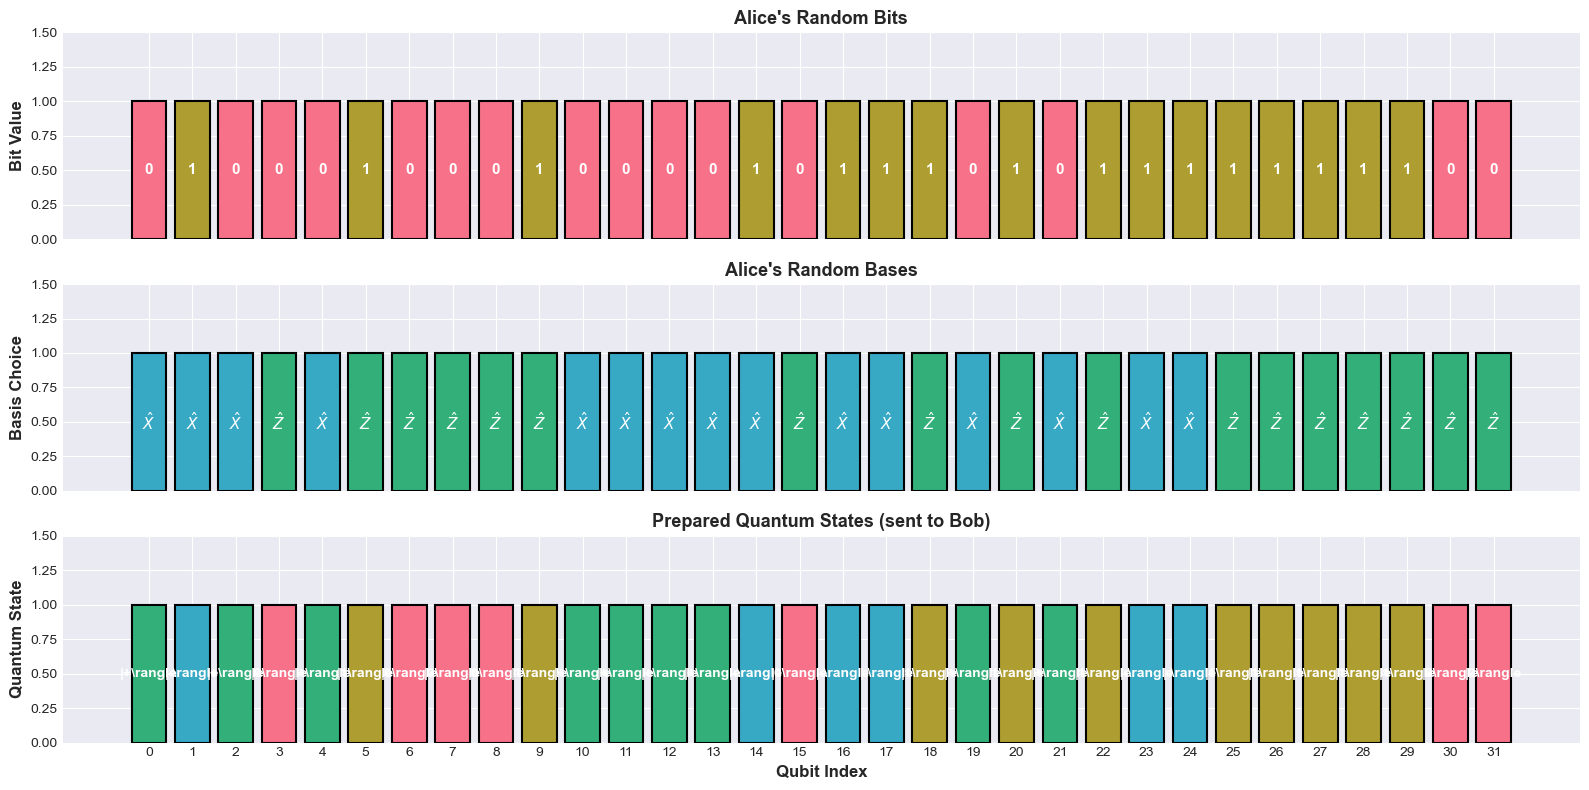


                     ALICE'S PREPARATION SUMMARY                      
Total qubits prepared: 32
Bits distribution: 16 ones, 16 zeros
Bases distribution: 15 X-basis, 17 Z-basis

State counts:
  |0\rangle: 7 (21.9%)
  |1\rangle: 10 (31.2%)
  |+\rangle: 9 (28.1%)
  |-\rangle: 6 (18.8%)


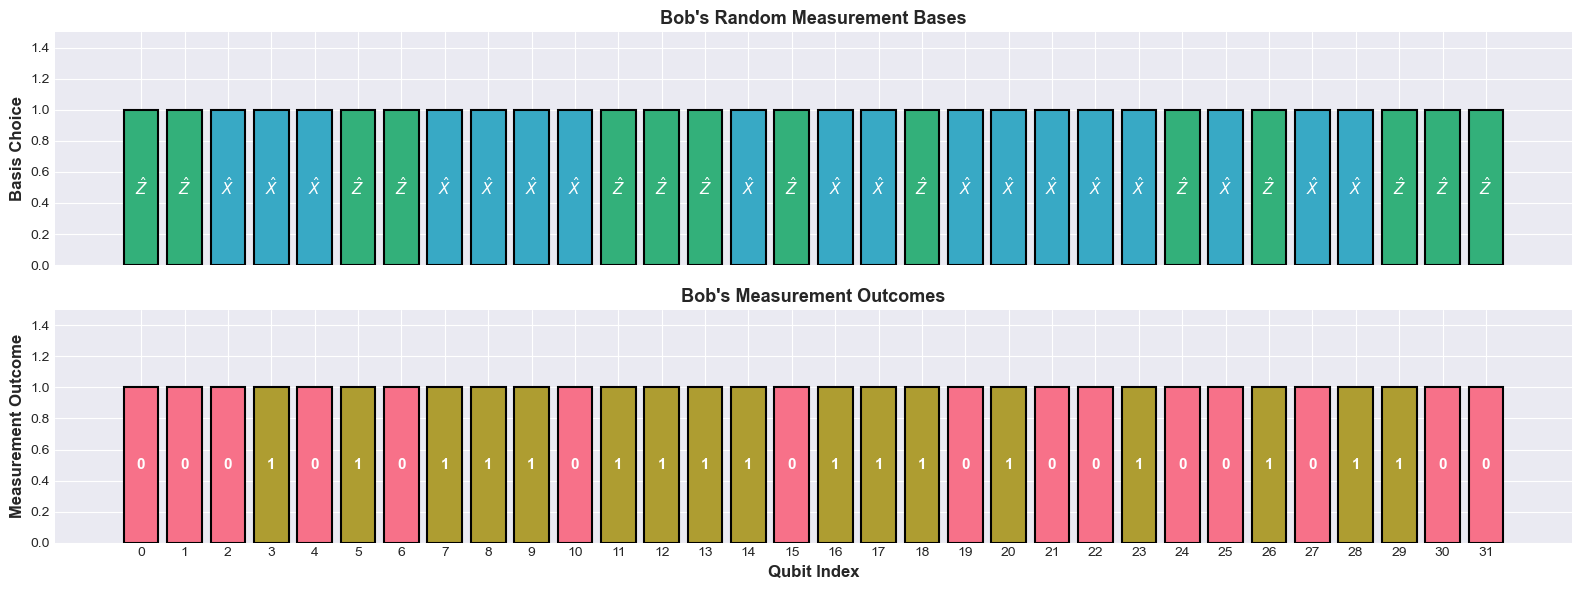


                      BOB'S MEASUREMENT SUMMARY                       
Total qubits measured: 32
Bases distribution: 18 X-basis, 14 Z-basis
Bit distribution: 17 ones, 15 zeros
Matching bases: 17 (53.1%)


interactive(children=(FloatSlider(value=0.001, description='Depol Noise', max=0.1, step=0.001), FloatSlider(va…

In [36]:

import ipywidgets as widgets

from qiskit.visualization import circuit_drawer


# Step 4: Noise Model
def create_realistic_noise_model(p_depol: float = 0.001, p_readout: float = 0.02) -> NoiseModel:
    """
    IBM-like hardware noise:
    - Depolarizing error on gates
    - Readout error on measurements
    """
    if not (0 <= p_depol <= 1 and 0 <= p_readout <= 1):
        raise ValueError("Noise probabilities must be between 0 and 1")
    noise_model = NoiseModel()
    error_gate = depolarizing_error(p_depol, 1)
    noise_model.add_all_qubit_quantum_error(error_gate, ['h', 'x', 'id'])
    error_meas = pauli_error([('X', p_readout), ('I', 1 - p_readout)])
    noise_model.add_all_qubit_quantum_error(error_meas, "measure")
    return noise_model

# Step 5: Alice's Preparation
def alice_prepare_qubits(n_qubits: int = 32, seed: int = 42, visualize: bool = True):
    """
    Alice prepares n_qubits with random bits and bases for BB84.
    
    Args:
        n_qubits: Number of qubits to prepare (default: 32).
        seed: Random seed for reproducibility (default: 42).
        visualize: Whether to display plots and summary (default: True).
    
    Returns:
        tuple: (alice_bits, alice_bases) as NumPy arrays (0=Z, 1=X for bases).
    """
    if not isinstance(n_qubits, int) or n_qubits <= 0:
        raise ValueError("n_qubits must be a positive integer")
    if visualize and n_qubits > 50:
        raise ValueError("n_qubits > 50 may produce crowded plots")
    
    np.random.seed(seed)
    alice_bits = np.array(np.random.randint(0, 2, n_qubits), dtype=int)
    alice_bases = np.array(np.random.randint(0, 2, n_qubits), dtype=int)
    
    if visualize:
        colors = sns.color_palette("husl", 5)
        state_colors = {r'|0\rangle': colors[0], r'|1\rangle': colors[1], r'|+\rangle': colors[2], r'|-\rangle': colors[3]}
        state_map = {(0, 0): r'|0\rangle', (1, 0): r'|1\rangle', (0, 1): r'|+\rangle', (1, 1): r'|-\rangle'}
        
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(max(10, 0.5 * n_qubits), 8))
        x_pos = np.arange(n_qubits)
        
        colors_bits = [state_colors[state_map[(b, 0)]] for b in alice_bits]
        ax1.bar(x_pos, np.ones(n_qubits), color=colors_bits, edgecolor='black', linewidth=1.5)
        ax1.set_ylabel('Bit Value', fontsize=12, fontweight='bold')
        ax1.set_ylim(0, 1.5)
        ax1.set_xticks(x_pos)
        ax1.set_xticklabels([])
        ax1.set_title("Alice's Random Bits", fontsize=13, fontweight='bold')
        for i, bit in enumerate(alice_bits):
            ax1.text(i, 0.5, str(bit), ha='center', va='center', fontsize=11, fontweight='bold', color='white')
        
        colors_bases = [colors[3] if b == 1 else colors[2] for b in alice_bases]
        basis_labels = [r'$\hat{X}$' if b == 1 else r'$\hat{Z}$' for b in alice_bases]
        ax2.bar(x_pos, np.ones(n_qubits), color=colors_bases, edgecolor='black', linewidth=1.5)
        ax2.set_ylabel('Basis Choice', fontsize=12, fontweight='bold')
        ax2.set_ylim(0, 1.5)
        ax2.set_xticks(x_pos)
        ax2.set_xticklabels([])
        ax2.set_title("Alice's Random Bases", fontsize=13, fontweight='bold')
        for i, label in enumerate(basis_labels):
            ax2.text(i, 0.5, label, ha='center', va='center', fontsize=11, fontweight='bold', color='white')
        
        states = [state_map[(alice_bits[i], alice_bases[i])] for i in range(n_qubits)]
        colors_states = [state_colors[s] for s in states]
        ax3.bar(x_pos, np.ones(n_qubits), color=colors_states, edgecolor='black', linewidth=1.5)
        ax3.set_ylabel('Quantum State', fontsize=12, fontweight='bold')
        ax3.set_xlabel('Qubit Index', fontsize=12, fontweight='bold')
        ax3.set_ylim(0, 1.5)
        ax3.set_xticks(x_pos)
        ax3.set_xticklabels(x_pos)
        ax3.set_title("Prepared Quantum States (sent to Bob)", fontsize=13, fontweight='bold')
        for i, state in enumerate(states):
            ax3.text(i, 0.5, state, ha='center', va='center', fontsize=10, fontweight='bold', color='white')
        
        plt.tight_layout()
        plt.show()
        
        print("\n" + "="*70)
        print("ALICE'S PREPARATION SUMMARY".center(70))
        print("="*70)
        print(f"Total qubits prepared: {n_qubits}")
        print(f"Bits distribution: {np.sum(alice_bits)} ones, {n_qubits - np.sum(alice_bits)} zeros")
        print(f"Bases distribution: {np.sum(alice_bases)} X-basis, {n_qubits - np.sum(alice_bases)} Z-basis")
        print(f"\nState counts:")
        state_counts = Counter(states)
        state_list = [r'|0\rangle', r'|1\rangle', r'|+\rangle', r'|-\rangle']
        for state in state_list:
            count = state_counts.get(state, 0)
            print(f"  {state}: {count} ({count/n_qubits*100:.1f}%)")
        print("="*70)
    
    return alice_bits, alice_bases

# Step 6: Bob's Measurement
def bob_measure_qubits(alice_bits: np.ndarray, alice_bases: np.ndarray, 
                      p_depol: float = 0.001, p_readout: float = 0.02, 
                      seed: int = 43, visualize: bool = True) -> tuple[np.ndarray, np.ndarray]:
    """
    Bob independently chooses random measurement bases and measures Alice's qubits.
    
    Args:
        alice_bits: Array of Alice's random bits (0 or 1).
        alice_bases: Array of Alice's random bases (0=Z, 1=X).
        p_depol: Depolarizing error probability (default: 0.001).
        p_readout: Readout error probability (default: 0.02).
        seed: Random seed for reproducibility (default: 43).
        visualize: Whether to display plots and summary (default: True).
    
    Returns:
        tuple: (bob_bases, bob_bits) as NumPy arrays (0=Z, 1=X for bases, 0/1 for bits).
    """
    n_qubits = len(alice_bits)
    if not isinstance(n_qubits, int) or n_qubits <= 0:
        raise ValueError("n_qubits must be a positive integer")
    if len(alice_bases) != n_qubits:
        raise ValueError("alice_bits and alice_bases must have the same length")
    if visualize and n_qubits > 50:
        raise ValueError("n_qubits > 50 may produce crowded plots")
    
    np.random.seed(seed)
    bob_bases = np.array(np.random.randint(0, 2, n_qubits), dtype=int)
    noise_model = create_realistic_noise_model(p_depol, p_readout) if p_depol > 0 or p_readout > 0 else None
    simulator = AerSimulator(noise_model=noise_model) if noise_model else AerSimulator()
    circuits = []
    
    for i in range(n_qubits):
        qc = QuantumCircuit(1, 1)
        if alice_bits[i] == 1:
            qc.x(0)
        if alice_bases[i] == 1:
            qc.h(0)
        if bob_bases[i] == 1:
            qc.h(0)
        qc.measure(0, 0)
        circuits.append(qc)
    
    circuits = transpile(circuits, simulator)
    results = simulator.run(circuits, shots=1).result()
    bob_bits = np.array([int(list(results.get_counts(i).keys())[0]) for i in range(n_qubits)], dtype=int)
    
    if visualize:
        colors = sns.color_palette("husl", 5)
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(max(10, 0.5 * n_qubits), 6))
        x_pos = np.arange(n_qubits)
        
        colors_bases = [colors[3] if b == 1 else colors[2] for b in bob_bases]
        basis_labels = [r'$\hat{X}$' if b == 1 else r'$\hat{Z}$' for b in bob_bases]
        ax1.bar(x_pos, np.ones(n_qubits), color=colors_bases, edgecolor='black', linewidth=1.5)
        ax1.set_ylabel('Basis Choice', fontsize=12, fontweight='bold')
        ax1.set_ylim(0, 1.5)
        ax1.set_xticks(x_pos)
        ax1.set_xticklabels([])
        ax1.set_title("Bob's Random Measurement Bases", fontsize=13, fontweight='bold')
        for i, label in enumerate(basis_labels):
            ax1.text(i, 0.5, label, ha='center', va='center', fontsize=11, fontweight='bold', color='white')
        
        colors_bits = [colors[1] if b == 1 else colors[0] for b in bob_bits]
        ax2.bar(x_pos, np.ones(n_qubits), color=colors_bits, edgecolor='black', linewidth=1.5)
        ax2.set_ylabel('Measurement Outcome', fontsize=12, fontweight='bold')
        ax2.set_xlabel('Qubit Index', fontsize=12, fontweight='bold')
        ax2.set_ylim(0, 1.5)
        ax2.set_xticks(x_pos)
        ax2.set_xticklabels(x_pos)
        ax2.set_title("Bob's Measurement Outcomes", fontsize=13, fontweight='bold')
        for i, bit in enumerate(bob_bits):
            ax2.text(i, 0.5, str(bit), ha='center', va='center', fontsize=11, fontweight='bold', color='white')
        
        plt.tight_layout()
        plt.show()
        
        basis_counts = Counter(basis_labels)
        bit_counts = Counter(bob_bits)
        print("\n" + "="*70)
        print("BOB'S MEASUREMENT SUMMARY".center(70))
        print("="*70)
        print(f"Total qubits measured: {n_qubits}")
        print(f"Bases distribution: {basis_counts[r'$\hat{X}$']} X-basis, {basis_counts[r'$\hat{Z}$']} Z-basis")
        print(f"Bit distribution: {bit_counts[1]} ones, {bit_counts[0]} zeros")
        print(f"Matching bases: {np.sum(alice_bases == bob_bases)} ({np.sum(alice_bases == bob_bases)/n_qubits*100:.1f}%)")
        print("="*70)
    
    return bob_bases, bob_bits

# Step 7: Quantum Transmission with Noise
def simulate_bb84_transmission(
    alice_bits: np.ndarray,
    alice_bases: np.ndarray,
    bob_bases: np.ndarray,
    p_depol: float = 0.001,
    p_readout: float = 0.02,
    eve_intercept_prob: float = 0.0
) -> tuple[np.ndarray, dict]:
    """
    Simulate the quantum transmission from Alice to Bob.
    
    Args:
        alice_bits: Alice's random bits (0 or 1).
        alice_bases: Alice's random bases (0=Z, 1=X).
        bob_bases: Bob's measurement bases (0=Z, 1=X).
        p_depol: Depolarizing error probability (default: 0.001).
        p_readout: Readout error probability (default: 0.02).
        eve_intercept_prob: Probability Eve intercepts each qubit (default: 0.0).
    
    Returns:
        tuple: (bob_results, metrics) where bob_results is Bob's measurement outcomes
               and metrics is a dictionary with transmission statistics.
    """
    n_qubits = len(alice_bits)
    if len(alice_bits) != len(alice_bases) or len(alice_bits) != len(bob_bases):
        raise ValueError("All input arrays must have the same length")
    if not (0 <= p_depol <= 1 and 0 <= p_readout <= 1 and 0 <= eve_intercept_prob <= 1):
        raise ValueError("Noise and Eve intercept probabilities must be between 0 and 1")
    
    bob_results = np.zeros(n_qubits, dtype=int)
    eve_detected = np.zeros(n_qubits, dtype=bool)
    
    noise_model = create_realistic_noise_model(p_depol, p_readout) if p_depol > 0 or p_readout > 0 else None
    simulator = AerSimulator(noise_model=noise_model) if noise_model else AerSimulator()
    circuits = []
    
    for i in range(n_qubits):
        qc = QuantumCircuit(1, 1)
        if alice_bits[i] == 1:
            qc.x(0)
        if alice_bases[i] == 1:
            qc.h(0)
        qc.barrier(label='Alice→Bob')
        
        if np.random.random() < eve_intercept_prob:
            eve_detected[i] = True
            eve_basis = np.random.randint(0, 2)
            if eve_basis == 1:
                qc.h(0)
            qc.measure(0, 0)
            temp_circuit = transpile(qc, simulator)
            temp_result = simulator.run(temp_circuit, shots=1).result()
            eve_measured_bit = int(list(temp_result.get_counts().keys())[0])
            qc.reset(0)
            if eve_measured_bit == 1:
                qc.x(0)
            if eve_basis == 1:
                qc.h(0)
            qc.barrier(label='Eve')
        
        if bob_bases[i] == 1:
            qc.h(0)
        qc.measure(0, 0)
        circuits.append(qc)
    
    circuits = transpile(circuits, simulator)
    try:
        results = simulator.run(circuits, shots=1).result()
    except Exception as e:
        raise RuntimeError(f"Simulation failed: {e}")
    
    bob_results = np.array([int(list(results.get_counts(i).keys())[0]) for i in range(n_qubits)], dtype=int)
    
    metrics = {
        'total_qubits': n_qubits,
        'eve_intercepts': np.sum(eve_detected),
        'eve_rate': np.mean(eve_detected),
        'circuits': circuits[:3]
    }
    
    return bob_results, metrics

def visualize_transmission(alice_bits, alice_bases, bob_bases, bob_results, metrics):
    """
    Visualize the complete BB84 transmission process.
    
    Args:
        alice_bits, alice_bases, bob_bases, bob_results: BB84 protocol data.
        metrics: Dictionary with transmission statistics.
    """
    n_qubits = len(alice_bits)
    x_pos = np.arange(n_qubits)
    colors = sns.color_palette("husl", 5)
    
    fig = plt.figure(figsize=(max(10, 0.5 * n_qubits), 12))
    gs = fig.add_gridspec(5, 1, hspace=0.4)
    
    ax1 = fig.add_subplot(gs[0])
    colors_bits = [colors[1] if b == 1 else colors[0] for b in alice_bits]
    ax1.bar(x_pos, np.ones(n_qubits), color=colors_bits, edgecolor='black', linewidth=1)
    ax1.set_ylabel(r'Alice Bits', fontsize=11, fontweight='bold', rotation=0, ha='right', va='center')
    ax1.set_ylim(0, 1.5)
    ax1.set_xticks([])
    ax1.set_title("Step 1: Alice's Random Bits", fontsize=12, fontweight='bold', loc='left')
    for i, bit in enumerate(alice_bits):
        ax1.text(i, 0.5, str(bit), ha='center', va='center', fontsize=9, fontweight='bold', color='white')
    
    ax2 = fig.add_subplot(gs[1])
    colors_bases = [colors[3] if b == 1 else colors[2] for b in alice_bases]
    labels = [r'$\hat{X}$' if b == 1 else r'$\hat{Z}$' for b in alice_bases]
    ax2.bar(x_pos, np.ones(n_qubits), color=colors_bases, edgecolor='black', linewidth=1)
    ax2.set_ylabel(r'Alice Bases', fontsize=11, fontweight='bold', rotation=0, ha='right', va='center')
    ax2.set_ylim(0, 1.5)
    ax2.set_xticks([])
    ax2.set_title("Step 2: Alice's Random Bases → Quantum States Sent", fontsize=12, fontweight='bold', loc='left')
    for i, label in enumerate(labels):
        ax2.text(i, 0.5, label, ha='center', va='center', fontsize=9, fontweight='bold', color='white')
    
    ax3 = fig.add_subplot(gs[2])
    colors_bases = [colors[3] if b == 1 else colors[2] for b in bob_bases]
    labels = [r'$\hat{X}$' if b == 1 else r'$\hat{Z}$' for b in bob_bases]
    ax3.bar(x_pos, np.ones(n_qubits), color=colors_bases, edgecolor='black', linewidth=1)
    ax3.set_ylabel(r'Bob Bases', fontsize=11, fontweight='bold', rotation=0, ha='right', va='center')
    ax3.set_ylim(0, 1.5)
    ax3.set_xticks([])
    ax3.set_title("Step 3: Bob's Independent Random Measurement Bases", fontsize=12, fontweight='bold', loc='left')
    for i, label in enumerate(labels):
        ax3.text(i, 0.5, label, ha='center', va='center', fontsize=9, fontweight='bold', color='white')
    
    ax4 = fig.add_subplot(gs[3])
    colors_bits = [colors[1] if b == 1 else colors[0] for b in bob_results]
    ax4.bar(x_pos, np.ones(n_qubits), color=colors_bits, edgecolor='black', linewidth=1)
    ax4.set_ylabel(r'Bob Results', fontsize=11, fontweight='bold', rotation=0, ha='right', va='center')
    ax4.set_ylim(0, 1.5)
    ax4.set_xticks([])
    ax4.set_title("Step 4: Bob's Measurement Results", fontsize=12, fontweight='bold', loc='left')
    for i, bit in enumerate(bob_results):
        ax4.text(i, 0.5, str(bit), ha='center', va='center', fontsize=9, fontweight='bold', color='white')
    
    ax5 = fig.add_subplot(gs[4])
    basis_match = alice_bases == bob_bases
    colors_match = [colors[4] if match else '#E76F51' for match in basis_match]
    match_labels = ['✓' if match else '✗' for match in basis_match]
    ax5.bar(x_pos, np.ones(n_qubits), color=colors_match, edgecolor='black', linewidth=1)
    ax5.set_ylabel(r'Basis Match', fontsize=11, fontweight='bold', rotation=0, ha='right', va='center')
    ax5.set_xlabel('Qubit Index', fontsize=12, fontweight='bold')
    ax5.set_ylim(0, 1.5)
    ax5.set_xticks(x_pos)
    ax5.set_xticklabels(x_pos)
    ax5.set_title("Step 5: Basis Matching (Green=Keep, Red=Discard)", fontsize=12, fontweight='bold', loc='left')
    for i, label in enumerate(match_labels):
        ax5.text(i, 0.5, label, ha='center', va='center', fontsize=12, fontweight='bold', color='white')
    
    plt.suptitle('BB84 Quantum Key Distribution: Complete Transmission', fontsize=15, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    basis_match = alice_bases == bob_bases
    matching_indices = np.where(basis_match)[0]
    print("\n" + "="*80)
    print("TRANSMISSION SUMMARY".center(80))
    print("="*80)
    print(f"Total qubits transmitted: {metrics['total_qubits']}")
    print(f"Matching bases: {np.sum(basis_match)} ({np.sum(basis_match)/n_qubits*100:.1f}%)")
    print(f"Non-matching bases: {n_qubits - np.sum(basis_match)} ({(n_qubits - np.sum(basis_match))/n_qubits*100:.1f}%)")
    
    if len(matching_indices) > 0:
        bit_errors_matching = np.sum(alice_bits[matching_indices.astype(int)] != bob_results[matching_indices.astype(int)])
        qber = bit_errors_matching / len(matching_indices)
        print(f"\nAmong matching bases:")
        print(f"  Bit agreements: {len(matching_indices) - bit_errors_matching}")
        print(f"  Bit errors: {bit_errors_matching}")
        print(f"  QBER: {qber*100:.2f}%")
    else:
        print("\nAmong matching bases:")
        print("  No matching bases found; cannot compute QBER.")
    
    if metrics['eve_intercepts'] > 0:
        print(f"\n⚠️  Eve intercepted {metrics['eve_intercepts']} qubits ({metrics['eve_rate']*100:.1f}%)")
    
    print("="*80)

# Step 8: Visualize Sample Quantum Circuits
def show_sample_circuits(metrics, n_show: int = 3):
    """
    Display sample quantum circuits from the BB84 transmission.
    
    Args:
        metrics: Dictionary containing 'circuits' key with list of QuantumCircuit objects.
        n_show: Number of circuits to display (default: 3).
    """
    if 'circuits' not in metrics or not metrics['circuits']:
        raise ValueError("No circuits found in metrics")
    if not isinstance(n_show, int) or n_show <= 0:
        raise ValueError("n_show must be a positive integer")
    
    circuits = metrics['circuits']
    n_display = min(n_show, len(circuits))
    
    fig, axes = plt.subplots(1, n_display, figsize=(6 * n_display, 4))
    axes = np.atleast_1d(axes)  # Ensure axes is iterable even for n_display=1
    
    for i, (qc, ax) in enumerate(zip(circuits[:n_display], axes)):
        try:
            qc.draw('mpl', ax=ax, style='iqx')
        except Exception as e:
            print(f"Error drawing circuit {i}: {e}")
            ax.text(0.5, 0.5, 'Drawing Failed', ha='center', va='center', fontsize=12, color='red')
        ax.set_title(f'Qubit {i} Circuit', fontsize=12, fontweight='bold')
    
    plt.suptitle('Sample Quantum Circuits from BB84 Transmission', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("📊 These circuits show the actual quantum operations:")
    print("   • Alice's preparation (X and/or H gates)")
    print("   • Barrier (Alice→Bob) indicates transmission")
    if metrics['eve_intercepts'] > 0:
        print("   • Eve's intercept (H, measure, reset, re-prepare) if present")
    print("   • Bob's measurement (H gate if X-basis, measure)")

# Run Steps 5 and 6 to ensure variables are defined
alice_bits, alice_bases = alice_prepare_qubits(n_qubits=32, seed=42, visualize=True)
bob_bases, _ = bob_measure_qubits(alice_bits, alice_bases, p_depol=0.001, p_readout=0.02, seed=43, visualize=True)

# Interactive execution for Steps 7 and 8
@interact(
    p_depol=FloatSlider(min=0, max=0.1, step=0.001, value=0.001, description='Depol Noise'),
    p_readout=FloatSlider(min=0, max=0.1, step=0.001, value=0.02, description='Readout Noise'),
    eve_intercept_prob=FloatSlider(min=0, max=1, step=0.01, value=0.0, description='Eve Prob'),
    n_show=IntSlider(min=1, max=3, step=1, value=3, description='Circuits to Show'),
    show_transmission=Checkbox(value=True, description='Show Transmission'),
    show_circuits=Checkbox(value=True, description='Show Circuits')
)
def run_bb84_simulation(p_depol, p_readout, eve_intercept_prob, n_show, show_transmission, show_circuits):
    """
    Run BB84 transmission and circuit visualization interactively.
    """
    print("="*80)
    print(f"SCENARIO: Noise (Depol={p_depol:.3f}, Readout={p_readout:.3f}), Eve Prob={eve_intercept_prob:.2f}".center(80))
    print("="*80)
    
    # Run Step 7
    global metrics_ideal  # Store metrics_ideal for Step 8
    bob_results, metrics_ideal = simulate_bb84_transmission(
        alice_bits, alice_bases, bob_bases,
        p_depol=p_depol,
        p_readout=p_readout,
        eve_intercept_prob=eve_intercept_prob
    )
    
    # Run Step 7 visualization
    if show_transmission:
        visualize_transmission(alice_bits, alice_bases, bob_bases, bob_results, metrics_ideal)
    
    # Run Step 8
    if show_circuits:
        show_sample_circuits(metrics_ideal, n_show=n_show)

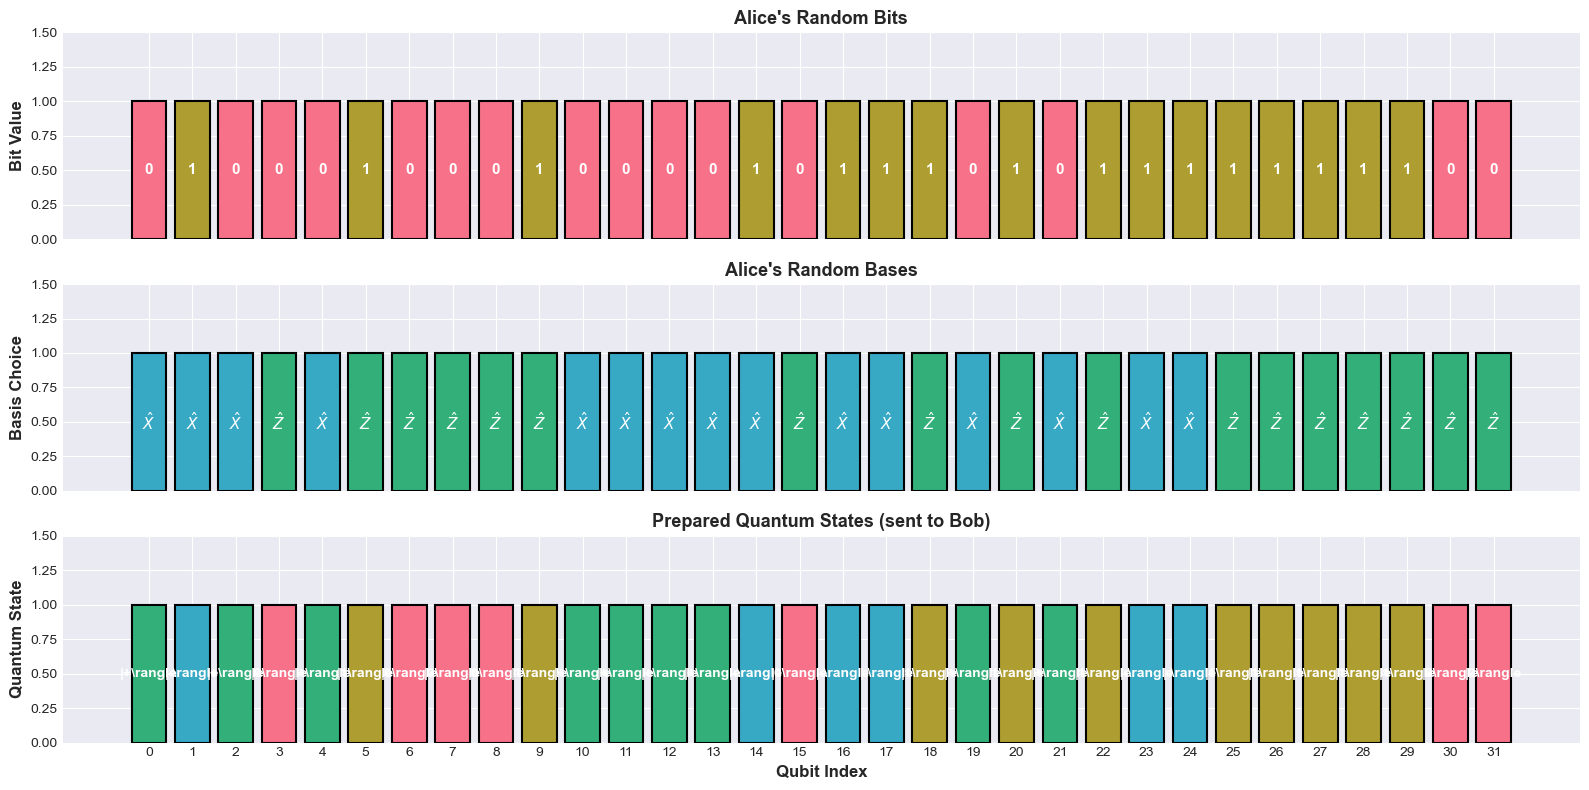


                     ALICE'S PREPARATION SUMMARY                      
Total qubits prepared: 32
Bits distribution: 16 ones, 16 zeros
Bases distribution: 15 X-basis, 17 Z-basis

State counts:
  |0\rangle: 7 (21.9%)
  |1\rangle: 10 (31.2%)
  |+\rangle: 9 (28.1%)
  |-\rangle: 6 (18.8%)


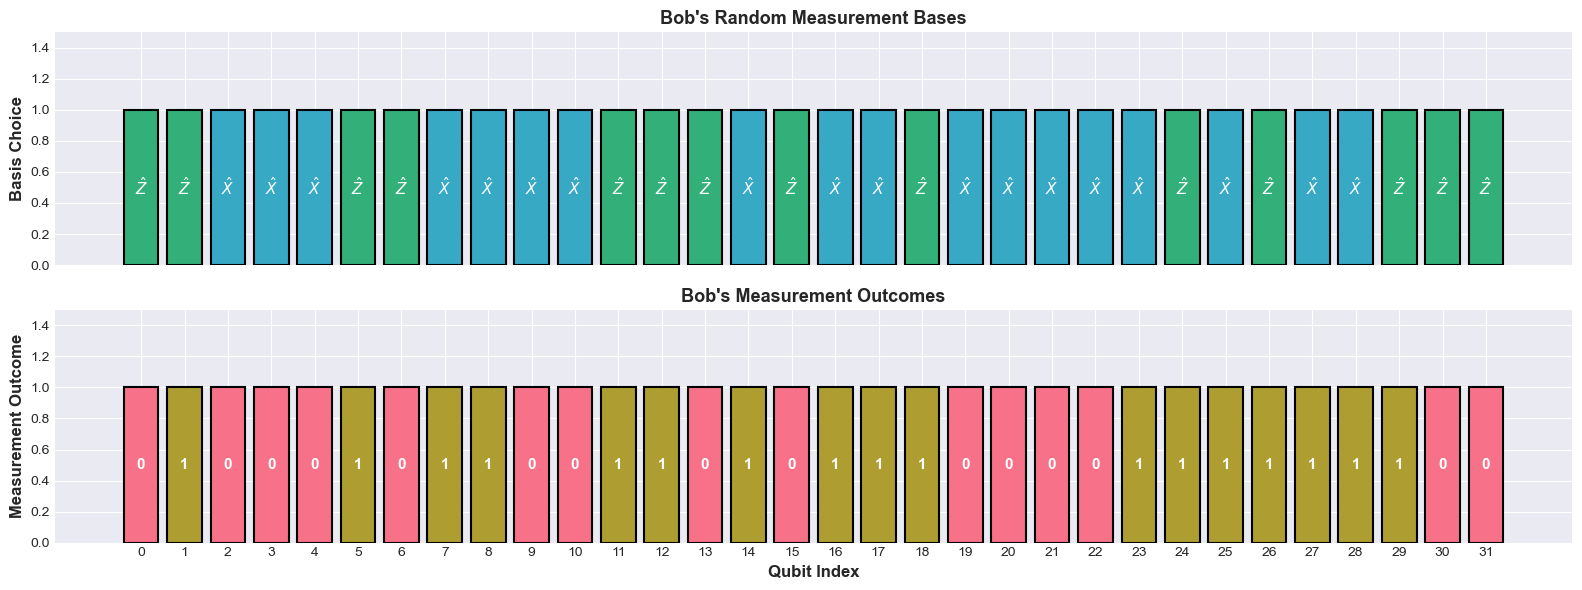


                      BOB'S MEASUREMENT SUMMARY                       
Total qubits measured: 32
Bases distribution: 18 X-basis, 14 Z-basis
Bit distribution: 17 ones, 15 zeros
Matching bases: 17 (53.1%)


interactive(children=(FloatSlider(value=0.001, description='Depol Noise', max=0.1, step=0.001), FloatSlider(va…

In [38]:
# Step 4: Noise Model
def create_realistic_noise_model(p_depol: float = 0.001, p_readout: float = 0.02) -> NoiseModel:
    """
    IBM-like hardware noise:
    - Depolarizing error on gates
    - Readout error on measurements
    """
    if not (0 <= p_depol <= 1 and 0 <= p_readout <= 1):
        raise ValueError("Noise probabilities must be between 0 and 1")
    noise_model = NoiseModel()
    error_gate = depolarizing_error(p_depol, 1)
    noise_model.add_all_qubit_quantum_error(error_gate, ['h', 'x', 'id'])
    error_meas = pauli_error([('X', p_readout), ('I', 1 - p_readout)])
    noise_model.add_all_qubit_quantum_error(error_meas, "measure")
    return noise_model

# Step 5: Alice's Preparation
def alice_prepare_qubits(n_qubits: int = 32, seed: int = 42, visualize: bool = True):
    """
    Alice prepares n_qubits with random bits and bases for BB84.
    
    Args:
        n_qubits: Number of qubits to prepare (default: 32).
        seed: Random seed for reproducibility (default: 42).
        visualize: Whether to display plots and summary (default: True).
    
    Returns:
        tuple: (alice_bits, alice_bases) as NumPy arrays (0=Z, 1=X for bases).
    """
    if not isinstance(n_qubits, int) or n_qubits <= 0:
        raise ValueError("n_qubits must be a positive integer")
    if visualize and n_qubits > 50:
        raise ValueError("n_qubits > 50 may produce crowded plots")
    
    np.random.seed(seed)
    alice_bits = np.array(np.random.randint(0, 2, n_qubits), dtype=int)
    alice_bases = np.array(np.random.randint(0, 2, n_qubits), dtype=int)
    
    if visualize:
        colors = sns.color_palette("husl", 5)
        state_colors = {r'|0\rangle': colors[0], r'|1\rangle': colors[1], r'|+\rangle': colors[2], r'|-\rangle': colors[3]}
        state_map = {(0, 0): r'|0\rangle', (1, 0): r'|1\rangle', (0, 1): r'|+\rangle', (1, 1): r'|-\rangle'}
        
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(max(10, 0.5 * n_qubits), 8))
        x_pos = np.arange(n_qubits)
        
        colors_bits = [state_colors[state_map[(b, 0)]] for b in alice_bits]
        ax1.bar(x_pos, np.ones(n_qubits), color=colors_bits, edgecolor='black', linewidth=1.5)
        ax1.set_ylabel('Bit Value', fontsize=12, fontweight='bold')
        ax1.set_ylim(0, 1.5)
        ax1.set_xticks(x_pos)
        ax1.set_xticklabels([])
        ax1.set_title("Alice's Random Bits", fontsize=13, fontweight='bold')
        for i, bit in enumerate(alice_bits):
            ax1.text(i, 0.5, str(bit), ha='center', va='center', fontsize=11, fontweight='bold', color='white')
        
        colors_bases = [colors[3] if b == 1 else colors[2] for b in alice_bases]
        basis_labels = [r'$\hat{X}$' if b == 1 else r'$\hat{Z}$' for b in alice_bases]
        ax2.bar(x_pos, np.ones(n_qubits), color=colors_bases, edgecolor='black', linewidth=1.5)
        ax2.set_ylabel('Basis Choice', fontsize=12, fontweight='bold')
        ax2.set_ylim(0, 1.5)
        ax2.set_xticks(x_pos)
        ax2.set_xticklabels([])
        ax2.set_title("Alice's Random Bases", fontsize=13, fontweight='bold')
        for i, label in enumerate(basis_labels):
            ax2.text(i, 0.5, label, ha='center', va='center', fontsize=11, fontweight='bold', color='white')
        
        states = [state_map[(alice_bits[i], alice_bases[i])] for i in range(n_qubits)]
        colors_states = [state_colors[s] for s in states]
        ax3.bar(x_pos, np.ones(n_qubits), color=colors_states, edgecolor='black', linewidth=1.5)
        ax3.set_ylabel('Quantum State', fontsize=12, fontweight='bold')
        ax3.set_xlabel('Qubit Index', fontsize=12, fontweight='bold')
        ax3.set_ylim(0, 1.5)
        ax3.set_xticks(x_pos)
        ax3.set_xticklabels(x_pos)
        ax3.set_title("Prepared Quantum States (sent to Bob)", fontsize=13, fontweight='bold')
        for i, state in enumerate(states):
            ax3.text(i, 0.5, state, ha='center', va='center', fontsize=10, fontweight='bold', color='white')
        
        plt.tight_layout()
        plt.show()
        
        print("\n" + "="*70)
        print("ALICE'S PREPARATION SUMMARY".center(70))
        print("="*70)
        print(f"Total qubits prepared: {n_qubits}")
        print(f"Bits distribution: {np.sum(alice_bits)} ones, {n_qubits - np.sum(alice_bits)} zeros")
        print(f"Bases distribution: {np.sum(alice_bases)} X-basis, {n_qubits - np.sum(alice_bases)} Z-basis")
        print(f"\nState counts:")
        state_counts = Counter(states)
        state_list = [r'|0\rangle', r'|1\rangle', r'|+\rangle', r'|-\rangle']
        for state in state_list:
            count = state_counts.get(state, 0)
            print(f"  {state}: {count} ({count/n_qubits*100:.1f}%)")
        print("="*70)
    
    return alice_bits, alice_bases

# Step 6: Bob's Measurement
def bob_measure_qubits(alice_bits: np.ndarray, alice_bases: np.ndarray, 
                      p_depol: float = 0.001, p_readout: float = 0.02, 
                      seed: int = 43, visualize: bool = True) -> tuple[np.ndarray, np.ndarray]:
    """
    Bob independently chooses random measurement bases and measures Alice's qubits.
    
    Args:
        alice_bits: Array of Alice's random bits (0 or 1).
        alice_bases: Array of Alice's random bases (0=Z, 1=X).
        p_depol: Depolarizing error probability (default: 0.001).
        p_readout: Readout error probability (default: 0.02).
        seed: Random seed for reproducibility (default: 43).
        visualize: Whether to display plots and summary (default: True).
    
    Returns:
        tuple: (bob_bases, bob_bits) as NumPy arrays (0=Z, 1=X for bases, 0/1 for bits).
    """
    n_qubits = len(alice_bits)
    if not isinstance(n_qubits, int) or n_qubits <= 0:
        raise ValueError("n_qubits must be a positive integer")
    if len(alice_bases) != n_qubits:
        raise ValueError("alice_bits and alice_bases must have the same length")
    if visualize and n_qubits > 50:
        raise ValueError("n_qubits > 50 may produce crowded plots")
    
    np.random.seed(seed)
    bob_bases = np.array(np.random.randint(0, 2, n_qubits), dtype=int)
    noise_model = create_realistic_noise_model(p_depol, p_readout) if p_depol > 0 or p_readout > 0 else None
    simulator = AerSimulator(noise_model=noise_model) if noise_model else AerSimulator()
    circuits = []
    
    for i in range(n_qubits):
        qc = QuantumCircuit(1, 1)
        if alice_bits[i] == 1:
            qc.x(0)
        if alice_bases[i] == 1:
            qc.h(0)
        if bob_bases[i] == 1:
            qc.h(0)
        qc.measure(0, 0)
        circuits.append(qc)
    
    circuits = transpile(circuits, simulator)
    results = simulator.run(circuits, shots=1).result()
    bob_bits = np.array([int(list(results.get_counts(i).keys())[0]) for i in range(n_qubits)], dtype=int)
    
    if visualize:
        colors = sns.color_palette("husl", 5)
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(max(10, 0.5 * n_qubits), 6))
        x_pos = np.arange(n_qubits)
        
        colors_bases = [colors[3] if b == 1 else colors[2] for b in bob_bases]
        basis_labels = [r'$\hat{X}$' if b == 1 else r'$\hat{Z}$' for b in bob_bases]
        ax1.bar(x_pos, np.ones(n_qubits), color=colors_bases, edgecolor='black', linewidth=1.5)
        ax1.set_ylabel('Basis Choice', fontsize=12, fontweight='bold')
        ax1.set_ylim(0, 1.5)
        ax1.set_xticks(x_pos)
        ax1.set_xticklabels([])
        ax1.set_title("Bob's Random Measurement Bases", fontsize=13, fontweight='bold')
        for i, label in enumerate(basis_labels):
            ax1.text(i, 0.5, label, ha='center', va='center', fontsize=11, fontweight='bold', color='white')
        
        colors_bits = [colors[1] if b == 1 else colors[0] for b in bob_bits]
        ax2.bar(x_pos, np.ones(n_qubits), color=colors_bits, edgecolor='black', linewidth=1.5)
        ax2.set_ylabel('Measurement Outcome', fontsize=12, fontweight='bold')
        ax2.set_xlabel('Qubit Index', fontsize=12, fontweight='bold')
        ax2.set_ylim(0, 1.5)
        ax2.set_xticks(x_pos)
        ax2.set_xticklabels(x_pos)
        ax2.set_title("Bob's Measurement Outcomes", fontsize=13, fontweight='bold')
        for i, bit in enumerate(bob_bits):
            ax2.text(i, 0.5, str(bit), ha='center', va='center', fontsize=11, fontweight='bold', color='white')
        
        plt.tight_layout()
        plt.show()
        
        basis_counts = Counter(basis_labels)
        bit_counts = Counter(bob_bits)
        print("\n" + "="*70)
        print("BOB'S MEASUREMENT SUMMARY".center(70))
        print("="*70)
        print(f"Total qubits measured: {n_qubits}")
        print(f"Bases distribution: {basis_counts[r'$\hat{X}$']} X-basis, {basis_counts[r'$\hat{Z}$']} Z-basis")
        print(f"Bit distribution: {bit_counts[1]} ones, {bit_counts[0]} zeros")
        print(f"Matching bases: {np.sum(alice_bases == bob_bases)} ({np.sum(alice_bases == bob_bases)/n_qubits*100:.1f}%)")
        print("="*70)
    
    return bob_bases, bob_bits

# Step 7: Quantum Transmission with Noise
def simulate_bb84_transmission(
    alice_bits: np.ndarray,
    alice_bases: np.ndarray,
    bob_bases: np.ndarray,
    p_depol: float = 0.001,
    p_readout: float = 0.02,
    eve_intercept_prob: float = 0.0
) -> tuple[np.ndarray, dict]:
    """
    Simulate the quantum transmission from Alice to Bob.
    
    Args:
        alice_bits: Alice's random bits (0 or 1).
        alice_bases: Alice's random bases (0=Z, 1=X).
        bob_bases: Bob's measurement bases (0=Z, 1=X).
        p_depol: Depolarizing error probability (default: 0.001).
        p_readout: Readout error probability (default: 0.02).
        eve_intercept_prob: Probability Eve intercepts each qubit (default: 0.0).
    
    Returns:
        tuple: (bob_results, metrics) where bob_results is Bob's measurement outcomes
               and metrics is a dictionary with transmission statistics.
    """
    n_qubits = len(alice_bits)
    if len(alice_bits) != len(alice_bases) or len(alice_bits) != len(bob_bases):
        raise ValueError("All input arrays must have the same length")
    if not (0 <= p_depol <= 1 and 0 <= p_readout <= 1 and 0 <= eve_intercept_prob <= 1):
        raise ValueError("Noise and Eve intercept probabilities must be between 0 and 1")
    
    bob_results = np.zeros(n_qubits, dtype=int)
    eve_detected = np.zeros(n_qubits, dtype=bool)
    
    noise_model = create_realistic_noise_model(p_depol, p_readout) if p_depol > 0 or p_readout > 0 else None
    simulator = AerSimulator(noise_model=noise_model) if noise_model else AerSimulator()
    circuits = []
    
    for i in range(n_qubits):
        qc = QuantumCircuit(1, 1)
        if alice_bits[i] == 1:
            qc.x(0)
        if alice_bases[i] == 1:
            qc.h(0)
        qc.barrier(label='Alice→Bob')
        
        if np.random.random() < eve_intercept_prob:
            eve_detected[i] = True
            eve_basis = np.random.randint(0, 2)
            if eve_basis == 1:
                qc.h(0)
            qc.measure(0, 0)
            temp_circuit = transpile(qc, simulator)
            temp_result = simulator.run(temp_circuit, shots=1).result()
            eve_measured_bit = int(list(temp_result.get_counts().keys())[0])
            qc.reset(0)
            if eve_measured_bit == 1:
                qc.x(0)
            if eve_basis == 1:
                qc.h(0)
            qc.barrier(label='Eve')
        
        if bob_bases[i] == 1:
            qc.h(0)
        qc.measure(0, 0)
        circuits.append(qc)
    
    circuits = transpile(circuits, simulator)
    try:
        results = simulator.run(circuits, shots=1).result()
    except Exception as e:
        raise RuntimeError(f"Simulation failed: {e}")
    
    bob_results = np.array([int(list(results.get_counts(i).keys())[0]) for i in range(n_qubits)], dtype=int)
    
    metrics = {
        'total_qubits': n_qubits,
        'eve_intercepts': np.sum(eve_detected),
        'eve_rate': np.mean(eve_detected),
        'circuits': circuits[:3]
    }
    
    return bob_results, metrics

# Step 7 Visualization
def visualize_transmission(alice_bits, alice_bases, bob_bases, bob_results, metrics):
    """
    Visualize the complete BB84 transmission process.
    
    Args:
        alice_bits, alice_bases, bob_bases, bob_results: BB84 protocol data.
        metrics: Dictionary with transmission statistics.
    """
    n_qubits = len(alice_bits)
    x_pos = np.arange(n_qubits)
    colors = sns.color_palette("husl", 5)
    
    fig = plt.figure(figsize=(max(10, 0.5 * n_qubits), 12))
    gs = fig.add_gridspec(5, 1, hspace=0.4)
    
    ax1 = fig.add_subplot(gs[0])
    colors_bits = [colors[1] if b == 1 else colors[0] for b in alice_bits]
    ax1.bar(x_pos, np.ones(n_qubits), color=colors_bits, edgecolor='black', linewidth=1)
    ax1.set_ylabel(r'Alice Bits', fontsize=11, fontweight='bold', rotation=0, ha='right', va='center')
    ax1.set_ylim(0, 1.5)
    ax1.set_xticks([])
    ax1.set_title("Step 1: Alice's Random Bits", fontsize=12, fontweight='bold', loc='left')
    for i, bit in enumerate(alice_bits):
        ax1.text(i, 0.5, str(bit), ha='center', va='center', fontsize=9, fontweight='bold', color='white')
    
    ax2 = fig.add_subplot(gs[1])
    colors_bases = [colors[3] if b == 1 else colors[2] for b in alice_bases]
    labels = [r'$\hat{X}$' if b == 1 else r'$\hat{Z}$' for b in alice_bases]
    ax2.bar(x_pos, np.ones(n_qubits), color=colors_bases, edgecolor='black', linewidth=1)
    ax2.set_ylabel(r'Alice Bases', fontsize=11, fontweight='bold', rotation=0, ha='right', va='center')
    ax2.set_ylim(0, 1.5)
    ax2.set_xticks([])
    ax2.set_title("Step 2: Alice's Random Bases → Quantum States Sent", fontsize=12, fontweight='bold', loc='left')
    for i, label in enumerate(labels):
        ax2.text(i, 0.5, label, ha='center', va='center', fontsize=9, fontweight='bold', color='white')
    
    ax3 = fig.add_subplot(gs[2])
    colors_bases = [colors[3] if b == 1 else colors[2] for b in bob_bases]
    labels = [r'$\hat{X}$' if b == 1 else r'$\hat{Z}$' for b in bob_bases]
    ax3.bar(x_pos, np.ones(n_qubits), color=colors_bases, edgecolor='black', linewidth=1)
    ax3.set_ylabel(r'Bob Bases', fontsize=11, fontweight='bold', rotation=0, ha='right', va='center')
    ax3.set_ylim(0, 1.5)
    ax3.set_xticks([])
    ax3.set_title("Step 3: Bob's Independent Random Measurement Bases", fontsize=12, fontweight='bold', loc='left')
    for i, label in enumerate(labels):
        ax3.text(i, 0.5, label, ha='center', va='center', fontsize=9, fontweight='bold', color='white')
    
    ax4 = fig.add_subplot(gs[3])
    colors_bits = [colors[1] if b == 1 else colors[0] for b in bob_results]
    ax4.bar(x_pos, np.ones(n_qubits), color=colors_bits, edgecolor='black', linewidth=1)
    ax4.set_ylabel(r'Bob Results', fontsize=11, fontweight='bold', rotation=0, ha='right', va='center')
    ax4.set_ylim(0, 1.5)
    ax4.set_xticks([])
    ax4.set_title("Step 4: Bob's Measurement Results", fontsize=12, fontweight='bold', loc='left')
    for i, bit in enumerate(bob_results):
        ax4.text(i, 0.5, str(bit), ha='center', va='center', fontsize=9, fontweight='bold', color='white')
    
    ax5 = fig.add_subplot(gs[4])
    basis_match = alice_bases == bob_bases
    colors_match = [colors[4] if match else '#E76F51' for match in basis_match]
    match_labels = ['✓' if match else '✗' for match in basis_match]
    ax5.bar(x_pos, np.ones(n_qubits), color=colors_match, edgecolor='black', linewidth=1)
    ax5.set_ylabel(r'Basis Match', fontsize=11, fontweight='bold', rotation=0, ha='right', va='center')
    ax5.set_xlabel('Qubit Index', fontsize=12, fontweight='bold')
    ax5.set_ylim(0, 1.5)
    ax5.set_xticks(x_pos)
    ax5.set_xticklabels(x_pos)
    ax5.set_title("Step 5: Basis Matching (Green=Keep, Red=Discard)", fontsize=12, fontweight='bold', loc='left')
    for i, label in enumerate(match_labels):
        ax5.text(i, 0.5, label, ha='center', va='center', fontsize=12, fontweight='bold', color='white')
    
    plt.suptitle('BB84 Quantum Key Distribution: Complete Transmission', fontsize=15, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    basis_match = alice_bases == bob_bases
    matching_indices = np.where(basis_match)[0]
    print("\n" + "="*80)
    print("TRANSMISSION SUMMARY".center(80))
    print("="*80)
    print(f"Total qubits transmitted: {metrics['total_qubits']}")
    print(f"Matching bases: {np.sum(basis_match)} ({np.sum(basis_match)/n_qubits*100:.1f}%)")
    print(f"Non-matching bases: {n_qubits - np.sum(basis_match)} ({(n_qubits - np.sum(basis_match))/n_qubits*100:.1f}%)")
    
    if len(matching_indices) > 0:
        bit_errors_matching = np.sum(alice_bits[matching_indices.astype(int)] != bob_results[matching_indices.astype(int)])
        qber = bit_errors_matching / len(matching_indices)
        print(f"\nAmong matching bases:")
        print(f"  Bit agreements: {len(matching_indices) - bit_errors_matching}")
        print(f"  Bit errors: {bit_errors_matching}")
        print(f"  QBER: {qber*100:.2f}%")
    else:
        print("\nAmong matching bases:")
        print("  No matching bases found; cannot compute QBER.")
    
    if metrics['eve_intercepts'] > 0:
        print(f"\n⚠️  Eve intercepted {metrics['eve_intercepts']} qubits ({metrics['eve_rate']*100:.1f}%)")
    
    print("="*80)

# Step 8: Visualize Sample Quantum Circuits
def show_sample_circuits(metrics, n_show: int = 3):
    """
    Display sample quantum circuits from the BB84 transmission.
    
    Args:
        metrics: Dictionary containing 'circuits' key with list of QuantumCircuit objects.
        n_show: Number of circuits to display (default: 3).
    """
    if 'circuits' not in metrics or not metrics['circuits']:
        raise ValueError("No circuits found in metrics")
    if not isinstance(n_show, int) or n_show <= 0:
        raise ValueError("n_show must be a positive integer")
    
    circuits = metrics['circuits']
    n_display = min(n_show, len(circuits))
    
    fig, axes = plt.subplots(1, n_display, figsize=(6 * n_display, 4))
    axes = np.atleast_1d(axes)  # Ensure axes is iterable even for n_display=1
    
    for i, (qc, ax) in enumerate(zip(circuits[:n_display], axes)):
        try:
            qc.draw('mpl', ax=ax, style='iqx')
        except Exception as e:
            print(f"Error drawing circuit {i}: {e}")
            ax.text(0.5, 0.5, 'Drawing Failed', ha='center', va='center', fontsize=12, color='red')
        ax.set_title(f'Qubit {i} Circuit', fontsize=12, fontweight='bold')
    
    plt.suptitle('Sample Quantum Circuits from BB84 Transmission', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("📊 These circuits show the actual quantum operations:")
    print("   • Alice's preparation (X and/or H gates)")
    print("   • Barrier (Alice→Bob) indicates transmission")
    if metrics['eve_intercepts'] > 0:
        print("   • Eve's intercept (H, measure, reset, re-prepare) if present")
    print("   • Bob's measurement (H gate if X-basis, measure)")

# Step 9: Key Sifting Process
def sift_key(alice_bits, alice_bases, bob_bases, bob_results, visualize=True):
    """
    Classical post-processing: Alice and Bob publicly compare bases
    and keep only qubits where bases matched
    
    Args:
        alice_bits: Alice's random bits (0 or 1).
        alice_bases: Alice's random bases (0=Z, 1=X).
        bob_bases: Bob's measurement bases (0=Z, 1=X).
        bob_results: Bob's measurement outcomes (0 or 1).
        visualize: Whether to display plots and summary (default: True).
    
    Returns:
        tuple: (alice_sifted, bob_sifted, matching_indices)
    """
    if not (len(alice_bits) == len(alice_bases) == len(bob_bases) == len(bob_results)):
        raise ValueError("All input arrays must have the same length")
    if not all(isinstance(arr, np.ndarray) for arr in [alice_bits, alice_bases, bob_bases, bob_results]):
        raise ValueError("All inputs must be NumPy arrays")
    
    # Find matching bases
    matching_indices = np.where(alice_bases == bob_bases)[0]
    
    # Sift keys
    alice_sifted = alice_bits[matching_indices]
    bob_sifted = bob_results[matching_indices]
    
    if visualize:
        n_qubits = len(alice_bits)
        n_sifted = len(matching_indices)
        colors = sns.color_palette("husl", 5)
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(max(10, 0.5 * n_qubits), 8))
        
        # Before sifting - show all qubits
        x_pos_all = np.arange(n_qubits)
        basis_match = (alice_bases == bob_bases)
        colors_before = [colors[4] if match else colors[1] for match in basis_match]
        
        ax1.bar(x_pos_all, np.ones(n_qubits), color=colors_before, 
                edgecolor='black', linewidth=1.5, alpha=0.7)
        ax1.set_ylabel('Basis Match', fontsize=12, fontweight='bold')
        ax1.set_ylim(0, 1.5)
        ax1.set_xticks(x_pos_all)
        ax1.set_xticklabels(x_pos_all, fontsize=8)
        ax1.set_title(f"Before Sifting: All {n_qubits} Qubits (Green=Keep, Red=Discard)", 
                      fontsize=13, fontweight='bold')
        
        # Add labels
        for i, match in enumerate(basis_match):
            label = '✓ Keep' if match else '✗ Discard'
            ax1.text(i, 0.5, label.split()[0], ha='center', va='center', 
                     fontsize=8, fontweight='bold', color='white')
        
        # After sifting - show only kept qubits
        if n_sifted > 0:
            x_pos_sifted = np.arange(n_sifted)
            bit_match = (alice_sifted == bob_sifted)
            colors_after = [colors[4] if match else colors[1] for match in bit_match]
            
            ax2.bar(x_pos_sifted, np.ones(n_sifted), color=colors_after, 
                    edgecolor='black', linewidth=1.5)
            ax2.set_ylabel('Bit Agreement', fontsize=12, fontweight='bold')
            ax2.set_xlabel('Sifted Key Index', fontsize=12, fontweight='bold')
            ax2.set_ylim(0, 1.5)
            ax2.set_xticks(x_pos_sifted)
            ax2.set_xticklabels(x_pos_sifted, fontsize=9)
            ax2.set_title(f"After Sifting: {n_sifted} Qubits Kept (Green=Agreement, Red=Error)", 
                          fontsize=13, fontweight='bold')
            
            # Add bit values
            for i, (a_bit, b_bit) in enumerate(zip(alice_sifted, bob_sifted)):
                label = f"{a_bit}={b_bit}" if a_bit == b_bit else f"{a_bit}≠{b_bit}"
                ax2.text(i, 0.5, label, ha='center', va='center', 
                         fontsize=8, fontweight='bold', color='white')
        else:
            ax2.text(0.5, 0.5, "No matching bases!", ha='center', va='center',
                     transform=ax2.transAxes, fontsize=14, fontweight='bold', color='red')
            ax2.set_xlim(0, 1)
            ax2.set_ylim(0, 1)
        
        plt.suptitle('BB84 Key Sifting Process', fontsize=15, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # Statistics
        print("\n" + "="*80)
        print("SIFTING RESULTS".center(80))
        print("="*80)
        print(f"Original qubits: {n_qubits}")
        print(f"Matching bases: {n_sifted} ({n_sifted/n_qubits*100:.1f}%)")
        print(f"Discarded: {n_qubits - n_sifted} ({(n_qubits - n_sifted)/n_qubits*100:.1f}%)")
        
        if n_sifted > 0:
            errors = np.sum(alice_sifted != bob_sifted)
            qber = errors / n_sifted
            print(f"\nSifted key length: {n_sifted} bits")
            print(f"Bit errors in sifted key: {errors}")
            print(f"QBER (Quantum Bit Error Rate): {qber*100:.2f}%")
            
            # Security threshold
            qber_threshold = 0.11
            if qber < qber_threshold:
                print(f"✅ QBER < {qber_threshold*100:.0f}% → Key is potentially secure")
            else:
                print(f"⚠️  QBER ≥ {qber_threshold*100:.0f}% → Possible eavesdropping, consider aborting")
        
        print("="*80)
    
    return alice_sifted, bob_sifted, matching_indices

# Run Steps 5 and 6 to ensure variables are defined
alice_bits, alice_bases = alice_prepare_qubits(n_qubits=32, seed=42, visualize=True)
bob_bases, _ = bob_measure_qubits(alice_bits, alice_bases, p_depol=0.001, p_readout=0.02, seed=43, visualize=True)

# Interactive execution for Steps 7, 8, and 9
@interact(
    p_depol=FloatSlider(min=0, max=0.1, step=0.001, value=0.001, description='Depol Noise'),
    p_readout=FloatSlider(min=0, max=0.1, step=0.001, value=0.02, description='Readout Noise'),
    eve_intercept_prob=FloatSlider(min=0, max=1, step=0.01, value=0.0, description='Eve Prob'),
    n_show=IntSlider(min=1, max=3, step=1, value=3, description='Circuits to Show'),
    show_transmission=Checkbox(value=True, description='Show Transmission'),
    show_circuits=Checkbox(value=True, description='Show Circuits'),
    show_sifting=Checkbox(value=True, description='Show Sifting')
)
def run_bb84_simulation(p_depol, p_readout, eve_intercept_prob, n_show, show_transmission, show_circuits, show_sifting):
    """
    Run BB84 transmission, circuit visualization, and key sifting interactively.
    """
    print("="*80)
    print(f"SCENARIO: Noise (Depol={p_depol:.3f}, Readout={p_readout:.3f}), Eve Prob={eve_intercept_prob:.2f}".center(80))
    print("="*80)
    
    # Run Step 7
    global bob_results_ideal, metrics_ideal  # Store for Steps 8 and 9
    bob_results_ideal, metrics_ideal = simulate_bb84_transmission(
        alice_bits, alice_bases, bob_bases,
        p_depol=p_depol,
        p_readout=p_readout,
        eve_intercept_prob=eve_intercept_prob
    )
    
    # Run Step 7 visualization
    if show_transmission:
        visualize_transmission(alice_bits, alice_bases, bob_bases, bob_results_ideal, metrics_ideal)
    
    # Run Step 8
    if show_circuits:
        show_sample_circuits(metrics_ideal, n_show=n_show)
    
    # Run Step 9
    if show_sifting:
        alice_sifted, bob_sifted, matching_indices = sift_key(
            alice_bits, alice_bases, bob_bases, bob_results_ideal, visualize=True
        )

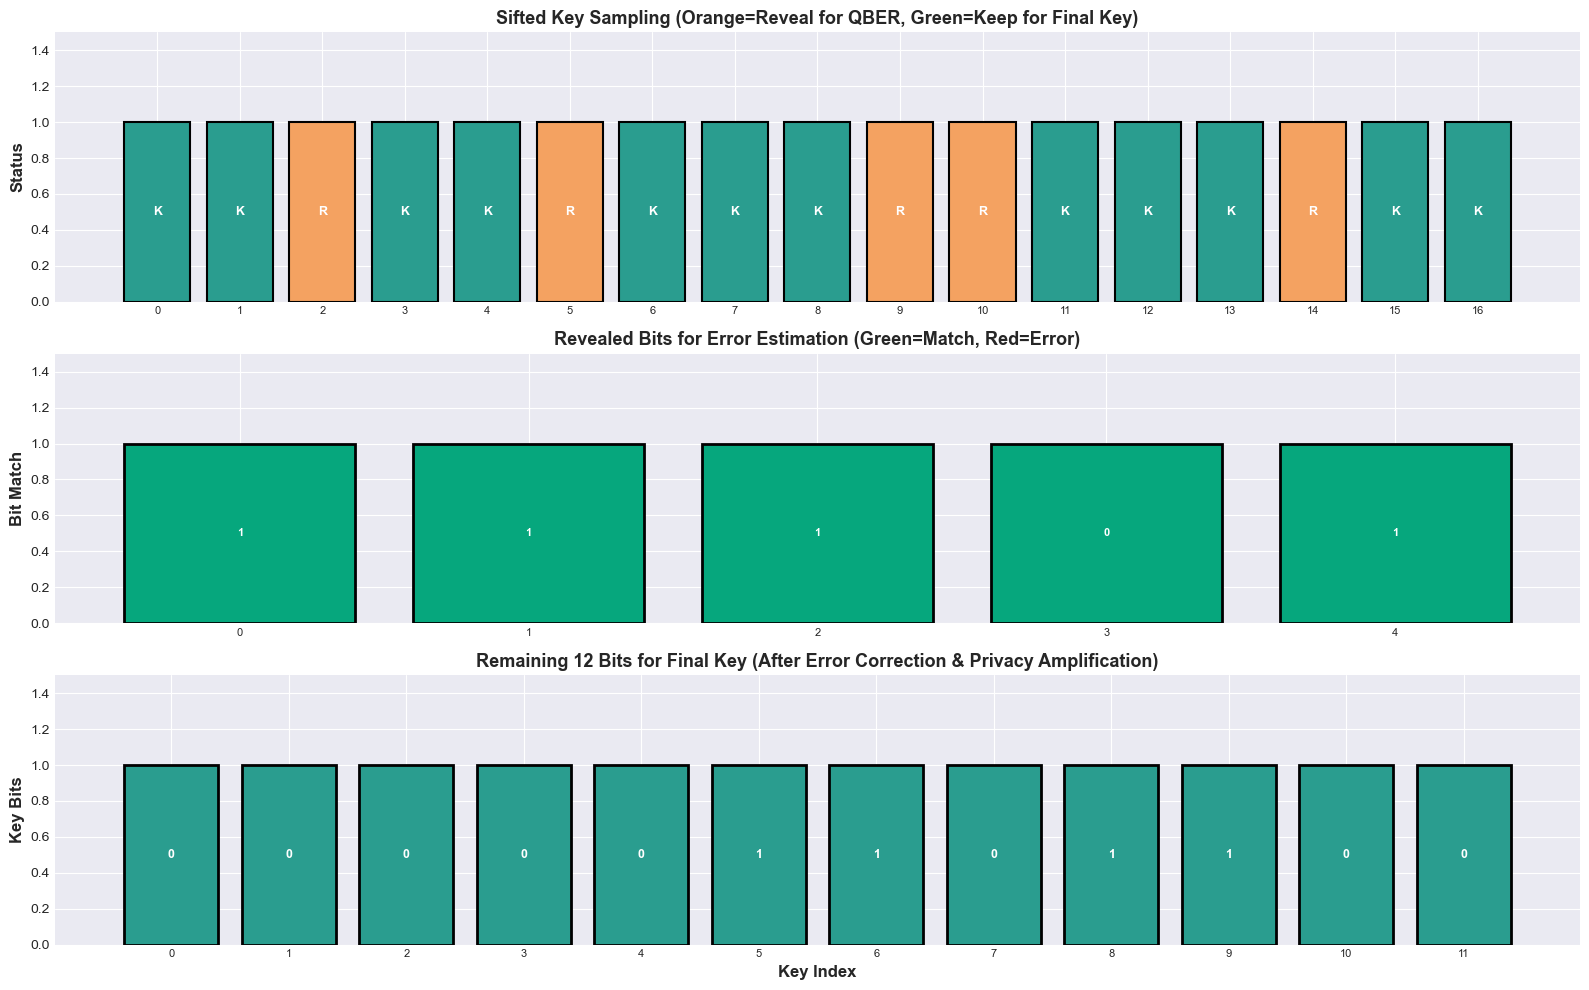


                            ERROR ESTIMATION RESULTS                            
Sifted key length: 17 bits
Bits revealed for QBER estimation: 5 (30.0%)
Bits kept for final key: 12 (70.0%)

Errors in revealed sample: 0/5
Estimated QBER: 0.00%

                      ✅ SECURITY CHECK PASSED: QBER < 11%                       
         Proceeding with error correction and privacy amplification...          


In [42]:
# Cell 11: Error Rate Estimation

def estimate_qber(alice_sifted, bob_sifted, sample_fraction=0.5, visualize=True):
    """
    Estimate QBER by revealing a random sample of the sifted key
    
    Args:
        alice_sifted, bob_sifted: Sifted keys
        sample_fraction: Fraction of key to reveal for error estimation
        
    Returns:
        qber: Estimated quantum bit error rate
        n_keep: Number of bits remaining after sampling
        n_reveal: Number of bits revealed for error estimation
    """
    
    n_sifted = len(alice_sifted)
    n_reveal = int(n_sifted * sample_fraction)
    n_keep = n_sifted - n_reveal
    
    # Randomly select bits to reveal
    np.random.seed(44)
    reveal_indices = np.random.choice(n_sifted, n_reveal, replace=False)
    keep_indices = np.array([i for i in range(n_sifted) if i not in reveal_indices])
    
    # Calculate QBER from revealed bits
    revealed_alice = alice_sifted[reveal_indices]
    revealed_bob = bob_sifted[reveal_indices]
    errors = np.sum(revealed_alice != revealed_bob)
    qber = errors / n_reveal if n_reveal > 0 else 0
    
    if visualize:
        fig, axes = plt.subplots(3, 1, figsize=(16, 10))
        
        # Plot 1: Show which bits are revealed vs kept
        ax1 = axes[0]
        x_pos = np.arange(n_sifted)
        colors = ['#F4A261' if i in reveal_indices else '#2A9D8F' for i in range(n_sifted)]
        labels = ['R' if i in reveal_indices else 'K' for i in range(n_sifted)]
        
        ax1.bar(x_pos, np.ones(n_sifted), color=colors, edgecolor='black', linewidth=1.5)
        ax1.set_ylabel('Status', fontsize=12, fontweight='bold')
        ax1.set_ylim(0, 1.5)
        ax1.set_xticks(x_pos)
        ax1.set_xticklabels(x_pos, fontsize=8)
        ax1.set_title(f"Sifted Key Sampling (Orange=Reveal for QBER, Green=Keep for Final Key)", 
                     fontsize=13, fontweight='bold')
        
        for i, label in enumerate(labels):
            ax1.text(i, 0.5, label, ha='center', va='center', 
                    fontsize=9, fontweight='bold', color='white')
        
        # Plot 2: Revealed bits for error estimation
        if n_reveal > 0:
            ax2 = axes[1]
            x_reveal = np.arange(n_reveal)
            bit_match = (revealed_alice == revealed_bob)
            colors_reveal = ['#06A77D' if match else '#E63946' for match in bit_match]
            
            ax2.bar(x_reveal, np.ones(n_reveal), color=colors_reveal, 
                   edgecolor='black', linewidth=2)
            ax2.set_ylabel('Bit Match', fontsize=12, fontweight='bold')
            ax2.set_ylim(0, 1.5)
            ax2.set_xticks(x_reveal)
            ax2.set_xticklabels(x_reveal, fontsize=8)
            ax2.set_title(f"Revealed Bits for Error Estimation (Green=Match, Red=Error)", 
                         fontsize=13, fontweight='bold')
            
            for i, (a_bit, b_bit, match) in enumerate(zip(revealed_alice, revealed_bob, bit_match)):
                label = f"{a_bit}" if match else f"{a_bit}≠{b_bit}"
                ax2.text(i, 0.5, label, ha='center', va='center', 
                        fontsize=8, fontweight='bold', color='white')
        
        # Plot 3: Remaining bits for final key
        if n_keep > 0:
            ax3 = axes[2]
            x_keep = np.arange(n_keep)
            kept_alice = alice_sifted[keep_indices]
            kept_bob = bob_sifted[keep_indices]
            bit_match_keep = (kept_alice == kept_bob)
            colors_keep = ['#2A9D8F' for _ in range(n_keep)]
            
            ax3.bar(x_keep, np.ones(n_keep), color=colors_keep, 
                   edgecolor='black', linewidth=2)
            ax3.set_ylabel('Key Bits', fontsize=12, fontweight='bold')
            ax3.set_xlabel('Key Index', fontsize=12, fontweight='bold')
            ax3.set_ylim(0, 1.5)
            ax3.set_xticks(x_keep)
            ax3.set_xticklabels(x_keep, fontsize=8)
            ax3.set_title(f"Remaining {n_keep} Bits for Final Key (After Error Correction & Privacy Amplification)", 
                         fontsize=13, fontweight='bold')
            
            # Show Alice's bits (Bob's should match after error correction)
            for i, bit in enumerate(kept_alice):
                ax3.text(i, 0.5, str(bit), ha='center', va='center', 
                        fontsize=9, fontweight='bold', color='white')
        
        plt.tight_layout()
        plt.show()
        
        # Statistics
        print("\n" + "="*80)
        print("ERROR ESTIMATION RESULTS".center(80))
        print("="*80)
        print(f"Sifted key length: {n_sifted} bits")
        print(f"Bits revealed for QBER estimation: {n_reveal} ({sample_fraction*100:.1f}%)")
        print(f"Bits kept for final key: {n_keep} ({(1-sample_fraction)*100:.1f}%)")
        print(f"\nErrors in revealed sample: {errors}/{n_reveal}")
        print(f"Estimated QBER: {qber*100:.2f}%")
        
        # Security decision
        print(f"\n{'='*80}")
        if qber < 0.11:
            print("✅ SECURITY CHECK PASSED: QBER < 11%".center(80))
            print("Proceeding with error correction and privacy amplification...".center(80))
        else:
            print("⚠️  SECURITY CHECK FAILED: QBER ≥ 11%".center(80))
            print("Possible eavesdropping detected. Protocol ABORTED.".center(80))
        print("="*80)
    
    return qber, n_keep, n_reveal, keep_indices

# Estimate QBER
qber, n_keep, n_reveal, keep_indices = estimate_qber(
    alice_sifted, bob_sifted, 
    sample_fraction=0.3,  # Use 30% for error estimation
    visualize=True
)

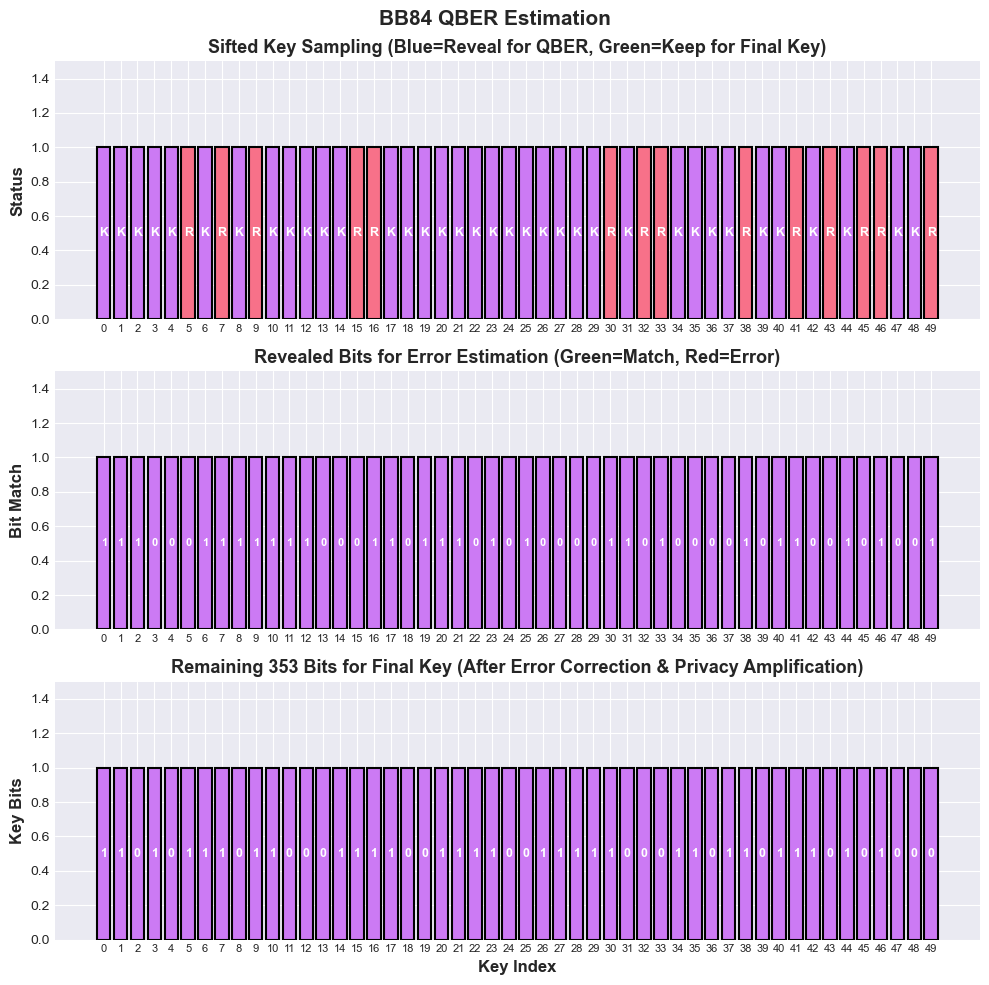


                            ERROR ESTIMATION RESULTS                            
Sifted key length: 503 bits
Bits revealed for QBER estimation: 150 (30.0%)
Bits kept for final key: 353 (70.0%)

Errors in revealed sample: 3/150
Estimated QBER: 2.00%

                      ✅ SECURITY CHECK PASSED: QBER < 11%                       
         Proceeding with error correction and privacy amplification...          


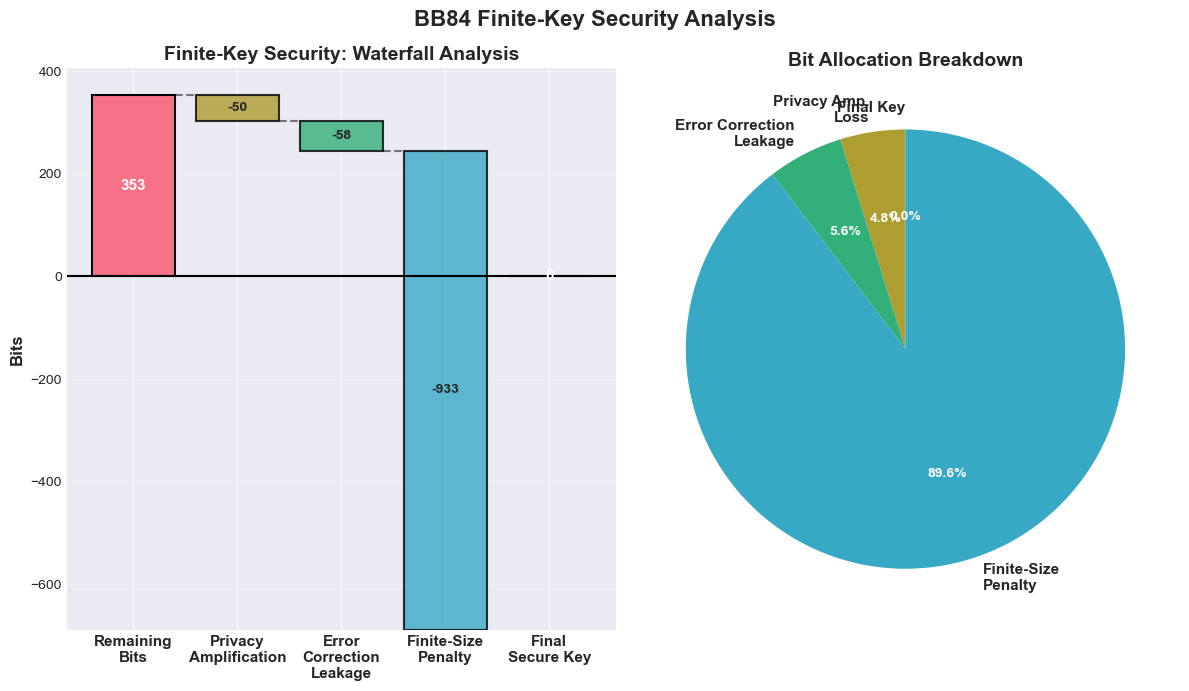


                               FINITE-KEY SECURITY ANALYSIS                               

Parameter                                Value                Description                   
------------------------------------------------------------------------------------------
Remaining bits (n_keep)                  353                  After QBER sampling           
QBER                                     0.0200 (2.00%)
Binary entropy h₂(QBER)                  0.141441
Error correction efficiency (f_EC)       1.16
Security parameter (ε_sec)               1.00e-10
Correctness parameter (ε_cor)            1.00e-15
------------------------------------------------------------------------------------------

Calculation Step                         Bits                 Formula/Note                  
------------------------------------------------------------------------------------------
1. Privacy amplification term            303.07 n × [1 - h₂(QBER)]            
2. Error correction lea

In [47]:

# Ensure plots display in Jupyter
%matplotlib inline

# Helper Functions
def binary_entropy(p):
    """
    Binary entropy function: h(p) = -p*log2(p) - (1-p)*log2(1-p)
    """
    if p == 0 or p == 1:
        return 0
    if not (0 < p < 1):
        raise ValueError("p must be between 0 and 1 for binary entropy")
    return -p * np.log2(p) - (1 - p) * np.log2(1 - p)

def finite_key_penalty(eps_sec, eps_cor, n):
    """
    Finite-size correction term for BB84:
    Δ = 7 * sqrt(n * log2(2/eps_sec)) + 2 * log2(1/eps_cor) + 2 * log2(1/(2*eps_sec))
    """
    if n <= 0:
        return 0
    if not (0 < eps_sec < 1 and 0 < eps_cor < 1):
        raise ValueError("eps_sec and eps_cor must be between 0 and 1")
    return 7 * np.sqrt(n * np.log2(2 / eps_sec)) + 2 * np.log2(1 / eps_cor) + 2 * np.log2(1 / (2 * eps_sec))

# Step 4: Noise Model
def create_realistic_noise_model(p_depol: float = 0.001, p_readout: float = 0.02) -> NoiseModel:
    noise_model = NoiseModel()
    error_gate = depolarizing_error(p_depol, 1)
    noise_model.add_all_qubit_quantum_error(error_gate, ['h', 'x', 'id'])
    error_meas = pauli_error([('X', p_readout), ('I', 1 - p_readout)])
    noise_model.add_all_qubit_quantum_error(error_meas, "measure")
    return noise_model

# Step 5: Alice's Preparation
def alice_prepare_qubits(n_qubits: int = 1000, seed: int = 42):
    np.random.seed(seed)
    alice_bits = np.array(np.random.randint(0, 2, n_qubits), dtype=int)
    alice_bases = np.array(np.random.randint(0, 2, n_qubits), dtype=int)
    return alice_bits, alice_bases

# Step 6: Bob's Measurement
def bob_measure_qubits(alice_bits: np.ndarray, alice_bases: np.ndarray, 
                       p_depol: float = 0.001, p_readout: float = 0.02, seed: int = 43):
    n_qubits = len(alice_bits)
    np.random.seed(seed)
    bob_bases = np.array(np.random.randint(0, 2, n_qubits), dtype=int)
    return bob_bases

# Step 7: Quantum Transmission
def simulate_bb84_transmission(alice_bits: np.ndarray, alice_bases: np.ndarray, 
                               bob_bases: np.ndarray, p_depol: float = 0.001, 
                               p_readout: float = 0.02, eve_intercept_prob: float = 0.0):
    n_qubits = len(alice_bits)
    noise_model = create_realistic_noise_model(p_depol, p_readout) if p_depol > 0 or p_readout > 0 else None
    simulator = AerSimulator(noise_model=noise_model) if noise_model else AerSimulator()
    circuits = []
    
    for i in range(n_qubits):
        qc = QuantumCircuit(1, 1)
        if alice_bits[i] == 1:
            qc.x(0)
        if alice_bases[i] == 1:
            qc.h(0)
        qc.barrier(label='Alice→Bob')
        if np.random.random() < eve_intercept_prob:
            eve_basis = np.random.randint(0, 2)
            if eve_basis == 1:
                qc.h(0)
            qc.measure(0, 0)
            temp_circuit = transpile(qc, simulator)
            temp_result = simulator.run(temp_circuit, shots=1).result()
            eve_measured_bit = int(list(temp_result.get_counts().keys())[0])
            qc.reset(0)
            if eve_measured_bit == 1:
                qc.x(0)
            if eve_basis == 1:
                qc.h(0)
            qc.barrier(label='Eve')
        if bob_bases[i] == 1:
            qc.h(0)
        qc.measure(0, 0)
        circuits.append(qc)
    
    circuits = transpile(circuits, simulator)
    results = simulator.run(circuits, shots=1).result()
    bob_results = np.array([int(list(results.get_counts(i).keys())[0]) for i in range(n_qubits)], dtype=int)
    
    return bob_results

# Step 9: Key Sifting
def sift_key(alice_bits, alice_bases, bob_bases, bob_results):
    if not (len(alice_bits) == len(alice_bases) == len(bob_bases) == len(bob_results)):
        raise ValueError("All input arrays must have the same length")
    matching_indices = np.where(alice_bases == bob_bases)[0]
    alice_sifted = alice_bits[matching_indices]
    bob_sifted = bob_results[matching_indices]
    return alice_sifted, bob_sifted, matching_indices

# Step 10: QBER Estimation
def estimate_qber(alice_sifted, bob_sifted, sample_fraction=0.3, visualize=True, seed=44):
    if len(alice_sifted) != len(bob_sifted):
        raise ValueError("Sifted keys must have the same length")
    if not all(isinstance(arr, np.ndarray) for arr in [alice_sifted, bob_sifted]):
        raise ValueError("Sifted keys must be NumPy arrays")
    if not (0 < sample_fraction <= 1):
        raise ValueError("sample_fraction must be between 0 and 1")
    
    n_sifted = len(alice_sifted)
    if n_sifted == 0:
        if visualize:
            print("\n" + "="*80)
            print("ERROR ESTIMATION RESULTS".center(80))
            print("="*80)
            print("No sifted key available! Cannot estimate QBER.")
            print("="*80)
        return 0, 0, 0, np.array([])
    
    n_reveal = int(n_sifted * sample_fraction)
    n_keep = n_sifted - n_reveal
    if seed is not None:
        np.random.seed(seed)
    reveal_indices = np.random.choice(n_sifted, n_reveal, replace=False)
    keep_indices = np.array([i for i in range(n_sifted) if i not in reveal_indices])
    
    revealed_alice = alice_sifted[reveal_indices]
    revealed_bob = bob_sifted[reveal_indices]
    errors = np.sum(revealed_alice != revealed_bob)
    qber = errors / n_reveal if n_reveal > 0 else 0
    
    if visualize:
        colors = sns.color_palette("husl", 5)
        fig, axes = plt.subplots(3, 1, figsize=(10, 10))
        
        ax1 = axes[0]
        x_pos = np.arange(min(n_sifted, 50))  # Limit display for readability
        colors_status = [colors[0] if i in reveal_indices else colors[4] for i in range(min(n_sifted, 50))]
        labels = ['R' if i in reveal_indices else 'K' for i in range(min(n_sifted, 50))]
        
        ax1.bar(x_pos, np.ones(len(x_pos)), color=colors_status, edgecolor='black', linewidth=1.5)
        ax1.set_ylabel('Status', fontsize=12, fontweight='bold')
        ax1.set_ylim(0, 1.5)
        ax1.set_xticks(x_pos)
        ax1.set_xticklabels(x_pos, fontsize=8)
        ax1.set_title(f"Sifted Key Sampling (Blue=Reveal for QBER, Green=Keep for Final Key)", 
                      fontsize=13, fontweight='bold')
        
        for i, label in enumerate(labels):
            ax1.text(i, 0.5, label, ha='center', va='center', 
                     fontsize=9, fontweight='bold', color='white')
        
        if n_reveal > 0:
            ax2 = axes[1]
            x_reveal = np.arange(min(n_reveal, 50))
            bit_match = (revealed_alice[:50] == revealed_bob[:50])
            colors_reveal = [colors[4] if match else colors[1] for match in bit_match]
            
            ax2.bar(x_reveal, np.ones(len(x_reveal)), color=colors_reveal, 
                    edgecolor='black', linewidth=1.5)
            ax2.set_ylabel('Bit Match', fontsize=12, fontweight='bold')
            ax2.set_ylim(0, 1.5)
            ax2.set_xticks(x_reveal)
            ax2.set_xticklabels(x_reveal, fontsize=8)
            ax2.set_title(f"Revealed Bits for Error Estimation (Green=Match, Red=Error)", 
                          fontsize=13, fontweight='bold')
            
            for i, (a_bit, b_bit, match) in enumerate(zip(revealed_alice[:50], revealed_bob[:50], bit_match)):
                label = f"{a_bit}" if match else f"{a_bit}≠{b_bit}"
                ax2.text(i, 0.5, label, ha='center', va='center', 
                         fontsize=8, fontweight='bold', color='white')
        else:
            ax2.text(0.5, 0.5, "No bits revealed!", ha='center', va='center',
                     transform=ax2.transAxes, fontsize=14, fontweight='bold', color='red')
            ax2.set_xlim(0, 1)
            ax2.set_ylim(0, 1)
        
        if n_keep > 0:
            ax3 = axes[2]
            x_keep = np.arange(min(n_keep, 50))
            kept_alice = alice_sifted[keep_indices][:50]
            colors_keep = [colors[4] for _ in range(len(x_keep))]
            
            ax3.bar(x_keep, np.ones(len(x_keep)), color=colors_keep, 
                    edgecolor='black', linewidth=1.5)
            ax3.set_ylabel('Key Bits', fontsize=12, fontweight='bold')
            ax3.set_xlabel('Key Index', fontsize=12, fontweight='bold')
            ax3.set_ylim(0, 1.5)
            ax3.set_xticks(x_keep)
            ax3.set_xticklabels(x_keep, fontsize=8)
            ax3.set_title(f"Remaining {n_keep} Bits for Final Key (After Error Correction & Privacy Amplification)", 
                          fontsize=13, fontweight='bold')
            
            for i, bit in enumerate(kept_alice):
                ax3.text(i, 0.5, str(bit), ha='center', va='center', 
                         fontsize=9, fontweight='bold', color='white')
        else:
            ax3.text(0.5, 0.5, "No bits kept!", ha='center', va='center',
                     transform=ax3.transAxes, fontsize=14, fontweight='bold', color='red')
            ax3.set_xlim(0, 1)
            ax3.set_ylim(0, 1)
        
        plt.suptitle('BB84 QBER Estimation', fontsize=15, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        print("\n" + "="*80)
        print("ERROR ESTIMATION RESULTS".center(80))
        print("="*80)
        print(f"Sifted key length: {n_sifted} bits")
        print(f"Bits revealed for QBER estimation: {n_reveal} ({sample_fraction*100:.1f}%)")
        print(f"Bits kept for final key: {n_keep} ({(1-sample_fraction)*100:.1f}%)")
        print(f"\nErrors in revealed sample: {errors}/{n_reveal}")
        print(f"Estimated QBER: {qber*100:.2f}%")
        qber_threshold = 0.11
        print(f"\n{'='*80}")
        if qber < qber_threshold:
            print("✅ SECURITY CHECK PASSED: QBER < 11%".center(80))
            print("Proceeding with error correction and privacy amplification...".center(80))
        else:
            print("⚠️  SECURITY CHECK FAILED: QBER ≥ 11%".center(80))
            print("Possible eavesdropping detected. Protocol ABORTED.".center(80))
        print("="*80)
    
    return qber, n_keep, n_reveal, keep_indices

# Step 12: Finite-Key Security Calculation
def calculate_finite_key_security(n_keep: int, qber: float, f_ec: float = 1.16, 
                                 eps_sec: float = 1e-10, eps_cor: float = 1e-15, 
                                 visualize: bool = True):
    if not (0 <= qber <= 0.5):
        raise ValueError("QBER must be between 0 and 0.5")
    if n_keep < 0:
        raise ValueError("n_keep must be non-negative")
    if not (f_ec >= 1):
        raise ValueError("f_ec must be >= 1")
    if not (0 < eps_sec < 1 and 0 < eps_cor < 1):
        raise ValueError("eps_sec and eps_cor must be between 0 and 1")
    
    if n_keep == 0:
        if visualize:
            print("\n" + "="*90)
            print("FINITE-KEY SECURITY ANALYSIS".center(90))
            print("="*90)
            print("No remaining bits! Cannot generate secure key.")
            print("="*90)
        return 0, {'final_length': 0, 'n_keep': 0, 'qber': qber}
    
    h2_qber = binary_entropy(qber)
    leak_ec = f_ec * n_keep * h2_qber
    delta = finite_key_penalty(eps_sec, eps_cor, n_keep)
    privacy_term = n_keep * (1 - h2_qber)
    final_key_length = max(0, privacy_term - leak_ec - delta)
    
    breakdown = {
        'n_keep': n_keep,
        'qber': qber,
        'h2_qber': h2_qber,
        'privacy_term': privacy_term,
        'leak_ec': leak_ec,
        'delta': delta,
        'final_length': final_key_length,
        'f_ec': f_ec,
        'eps_sec': eps_sec,
        'eps_cor': eps_cor
    }
    
    if visualize:
        colors = sns.color_palette("husl", 5)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))
        
        categories = ['Remaining\nBits', 'Privacy\nAmplification', 'Error\nCorrection\nLeakage', 
                      'Finite-Size\nPenalty', 'Final\nSecure Key']
        values = [n_keep, -n_keep * h2_qber, -leak_ec, -delta, final_key_length]
        cumulative = [0]
        for i, val in enumerate(values[:-1]):
            if i == 0:
                cumulative.append(values[0])
            else:
                cumulative.append(cumulative[-1] + val)
        
        for i in range(len(categories)):
            if i == 0:
                ax1.bar(i, values[i], color=colors[0], edgecolor='black', linewidth=1.5)
                ax1.text(i, values[i]/2, f'{values[i]:.0f}', ha='center', va='center',
                         fontsize=11, fontweight='bold', color='white')
            elif i == len(categories) - 1:
                ax1.bar(i, values[i], color=colors[4], edgecolor='black', linewidth=1.5)
                ax1.text(i, values[i]/2, f'{int(final_key_length)}', ha='center', va='center',
                         fontsize=11, fontweight='bold', color='white')
            else:
                ax1.bar(i, abs(values[i]), bottom=cumulative[i] + min(0, values[i]), 
                        color=colors[i], edgecolor='black', linewidth=1.5, alpha=0.8)
                ax1.text(i, cumulative[i] + values[i]/2, f'{values[i]:.0f}', 
                         ha='center', va='center', fontsize=10, fontweight='bold')
        
        for i in range(len(categories) - 1):
            if i < len(categories) - 2:
                ax1.plot([i + 0.4, i + 0.6], [cumulative[i+1], cumulative[i+1]], 
                         'k--', linewidth=1.5, alpha=0.5)
        
        ax1.set_xticks(range(len(categories)))
        ax1.set_xticklabels(categories, fontsize=11, fontweight='bold')
        ax1.set_ylabel('Bits', fontsize=12, fontweight='bold')
        ax1.set_title('Finite-Key Security: Waterfall Analysis', fontsize=14, fontweight='bold')
        ax1.grid(axis='y', alpha=0.3)
        ax1.axhline(y=0, color='black', linewidth=1.5)
        
        loss_labels = ['Privacy Amp.\nLoss', 'Error Correction\nLeakage', 'Finite-Size\nPenalty', 'Final Key']
        loss_values = [n_keep * h2_qber, leak_ec, delta, final_key_length]
        loss_values_positive = [abs(v) for v in loss_values]
        wedges, texts, autotexts = ax2.pie(loss_values_positive, labels=loss_labels, 
                                           colors=[colors[1], colors[2], colors[3], colors[4]],
                                           autopct='%1.1f%%', startangle=90, 
                                           textprops={'fontsize': 11, 'fontweight': 'bold'})
        
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontsize(10)
        
        ax2.set_title('Bit Allocation Breakdown', fontsize=14, fontweight='bold')
        
        plt.suptitle('BB84 Finite-Key Security Analysis', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        print("\n" + "="*90)
        print("FINITE-KEY SECURITY ANALYSIS".center(90))
        print("="*90)
        print(f"\n{'Parameter':<40} {'Value':<20} {'Description':<30}")
        print("-" * 90)
        print(f"{'Remaining bits (n_keep)':<40} {n_keep:<20} {'After QBER sampling':<30}")
        print(f"{'QBER':<40} {qber:.4f} ({qber*100:.2f}%)")
        print(f"{'Binary entropy h₂(QBER)':<40} {h2_qber:.6f}")
        print(f"{'Error correction efficiency (f_EC)':<40} {f_ec:.2f}")
        print(f"{'Security parameter (ε_sec)':<40} {eps_sec:.2e}")
        print(f"{'Correctness parameter (ε_cor)':<40} {eps_cor:.2e}")
        print("-" * 90)
        print(f"\n{'Calculation Step':<40} {'Bits':<20} {'Formula/Note':<30}")
        print("-" * 90)
        print(f"{'1. Privacy amplification term':<40} {privacy_term:.2f} {'n × [1 - h₂(QBER)]':<30}")
        print(f"{'2. Error correction leakage':<40} {-leak_ec:.2f} {'f_EC × n × h₂(QBER)':<30}")
        print(f"{'3. Finite-size penalty':<40} {-delta:.2f} {'Finite-size correction':<30}")
        print("-" * 90)
        print(f"{'FINAL SECURE KEY LENGTH':<40} {int(final_key_length)} {'bits':<30}")
        print("="*90)
        
        if final_key_length > 0:
            efficiency = (final_key_length / n_keep) * 100
            print(f"\n✅ SECURE KEY GENERATED!")
            print(f"   Final key length: {int(final_key_length)} bits")
            print(f"   Efficiency: {efficiency:.2f}% (secure bits / remaining bits)")
            print(f"   Security level: ε_sec = {eps_sec:.2e}")
        else:
            print(f"\n❌ INSUFFICIENT BITS FOR SECURE KEY")
            print(f"   Need larger block size or better channel quality")
            print(f"   Current shortage: {abs(final_key_length):.2f} bits")
        print("="*90)
    
    return final_key_length, breakdown

# Generate Variables and Run Steps 5–12
alice_bits, alice_bases = alice_prepare_qubits(n_qubits=1000, seed=42)
bob_bases = bob_measure_qubits(alice_bits, alice_bases, p_depol=0.001, p_readout=0.02, seed=43)
bob_results = simulate_bb84_transmission(
    alice_bits, alice_bases, bob_bases, p_depol=0.001, p_readout=0.02, eve_intercept_prob=0.0
)
alice_sifted, bob_sifted, matching_indices = sift_key(
    alice_bits, alice_bases, bob_bases, bob_results
)
qber, n_keep, n_reveal, keep_indices = estimate_qber(
    alice_sifted, bob_sifted, sample_fraction=0.3, visualize=True, seed=44
)
final_key_length, breakdown = calculate_finite_key_security(
    n_keep=n_keep, qber=qber, f_ec=1.16, eps_sec=1e-10, eps_cor=1e-15, visualize=True
)

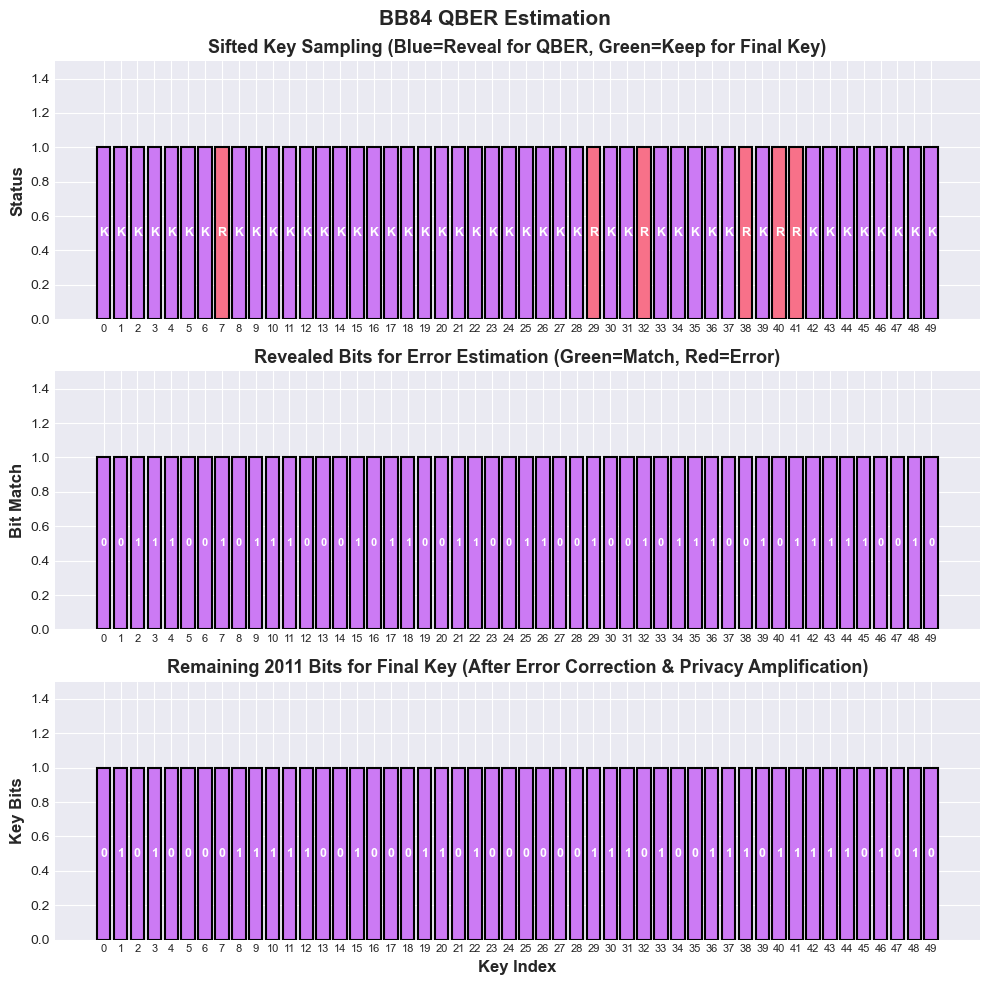


                            ERROR ESTIMATION RESULTS                            
Sifted key length: 2513 bits
Bits revealed for QBER estimation: 502 (20.0%)
Bits kept for final key: 2011 (80.0%)

Errors in revealed sample: 7/502
Estimated QBER: 1.39%

                      ✅ SECURITY CHECK PASSED: QBER < 11%                       
         Proceeding with error correction and privacy amplification...          


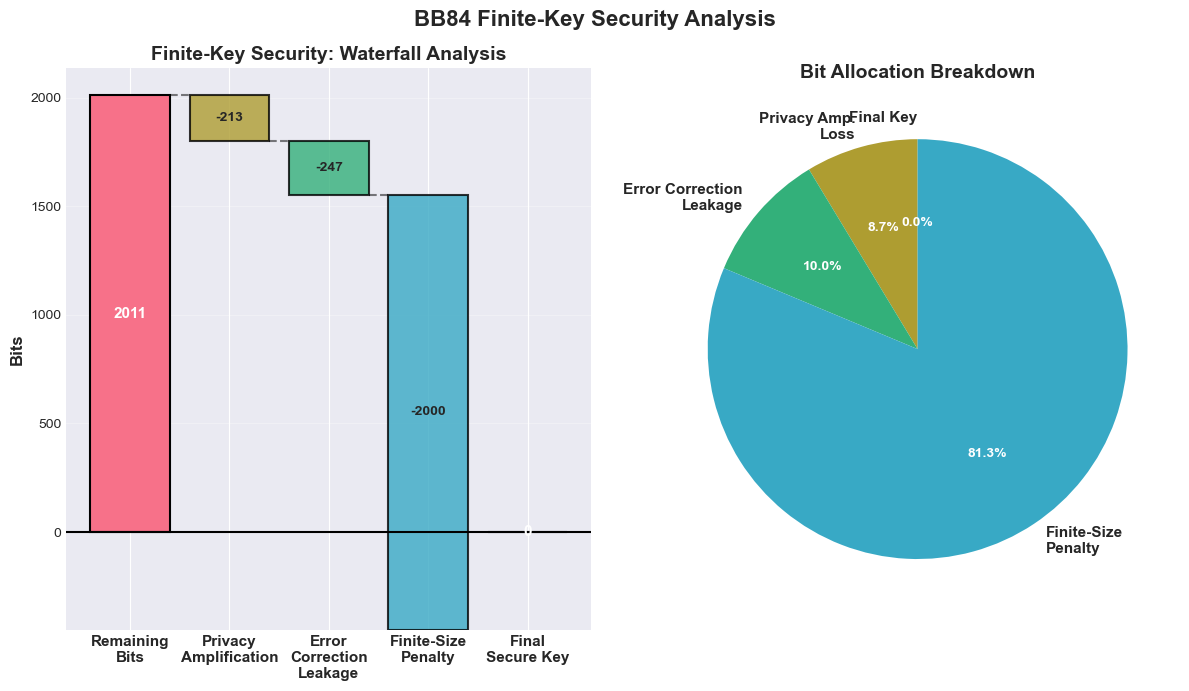


                               FINITE-KEY SECURITY ANALYSIS                               

Parameter                                Value                Description                   
------------------------------------------------------------------------------------------
Remaining bits (n_keep)                  2011                 After QBER sampling           
QBER                                     0.0139 (1.39%)
Binary entropy h₂(QBER)                  0.105931
Error correction efficiency (f_EC)       1.16
Security parameter (ε_sec)               1.00e-10
Correctness parameter (ε_cor)            1.00e-15
------------------------------------------------------------------------------------------

Calculation Step                         Bits                 Formula/Note                  
------------------------------------------------------------------------------------------
1. Privacy amplification term            1797.97 n × [1 - h₂(QBER)]            
2. Error correction le

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, pauli_error

# Ensure plots display in Jupyter
%matplotlib inline

# Helper Functions
def binary_entropy(p):
    """
    Binary entropy function: h(p) = -p*log2(p) - (1-p)*log2(1-p)
    """
    if p == 0 or p == 1:
        return 0
    if not (0 < p < 1):
        raise ValueError("p must be between 0 and 1 for binary entropy")
    return -p * np.log2(p) - (1 - p) * np.log2(1 - p)

def finite_key_penalty(eps_sec, eps_cor, n):
    """
    Finite-size correction term for BB84:
    Δ = 7 * sqrt(n * log2(2/eps_sec)) + 2 * log2(1/eps_cor) + 2 * log2(1/(2*eps_sec))
    """
    if n <= 0:
        return 0
    if not (0 < eps_sec < 1 and 0 < eps_cor < 1):
        raise ValueError("eps_sec and eps_cor must be between 0 and 1")
    return 7 * np.sqrt(n * np.log2(2 / eps_sec)) + 2 * np.log2(1 / eps_cor) + 2 * np.log2(1 / (2 * eps_sec))

# Step 4: Noise Model
def create_realistic_noise_model(p_depol: float = 0.001, p_readout: float = 0.02) -> NoiseModel:
    noise_model = NoiseModel()
    error_gate = depolarizing_error(p_depol, 1)
    noise_model.add_all_qubit_quantum_error(error_gate, ['h', 'x', 'id'])
    error_meas = pauli_error([('X', p_readout), ('I', 1 - p_readout)])
    noise_model.add_all_qubit_quantum_error(error_meas, "measure")
    return noise_model

# Step 5: Alice's Preparation
def alice_prepare_qubits(n_qubits: int = 1000, seed: int = 42):
    np.random.seed(seed)
    alice_bits = np.array(np.random.randint(0, 2, n_qubits), dtype=int)
    alice_bases = np.array(np.random.randint(0, 2, n_qubits), dtype=int)
    return alice_bits, alice_bases

# Step 6: Bob's Measurement
def bob_measure_qubits(alice_bits: np.ndarray, alice_bases: np.ndarray, 
                       p_depol: float = 0.001, p_readout: float = 0.02, seed: int = 43):
    n_qubits = len(alice_bits)
    np.random.seed(seed)
    bob_bases = np.array(np.random.randint(0, 2, n_qubits), dtype=int)
    return bob_bases

# Step 7: Quantum Transmission
def simulate_bb84_transmission(alice_bits: np.ndarray, alice_bases: np.ndarray, 
                               bob_bases: np.ndarray, p_depol: float = 0.001, 
                               p_readout: float = 0.02, eve_intercept_prob: float = 0.0):
    n_qubits = len(alice_bits)
    noise_model = create_realistic_noise_model(p_depol, p_readout) if p_depol > 0 or p_readout > 0 else None
    simulator = AerSimulator(noise_model=noise_model) if noise_model else AerSimulator()
    circuits = []
    
    for i in range(n_qubits):
        qc = QuantumCircuit(1, 1)
        if alice_bits[i] == 1:
            qc.x(0)
        if alice_bases[i] == 1:
            qc.h(0)
        qc.barrier(label='Alice→Bob')
        if np.random.random() < eve_intercept_prob:
            eve_basis = np.random.randint(0, 2)
            if eve_basis == 1:
                qc.h(0)
            qc.measure(0, 0)
            temp_circuit = transpile(qc, simulator)
            temp_result = simulator.run(temp_circuit, shots=1).result()
            eve_measured_bit = int(list(temp_result.get_counts().keys())[0])
            qc.reset(0)
            if eve_measured_bit == 1:
                qc.x(0)
            if eve_basis == 1:
                qc.h(0)
            qc.barrier(label='Eve')
        if bob_bases[i] == 1:
            qc.h(0)
        qc.measure(0, 0)
        circuits.append(qc)
    
    circuits = transpile(circuits, simulator)
    results = simulator.run(circuits, shots=1).result()
    bob_results = np.array([int(list(results.get_counts(i).keys())[0]) for i in range(n_qubits)], dtype=int)
    
    return bob_results

# Step 9: Key Sifting
def sift_key(alice_bits, alice_bases, bob_bases, bob_results):
    if not (len(alice_bits) == len(alice_bases) == len(bob_bases) == len(bob_results)):
        raise ValueError("All input arrays must have the same length")
    matching_indices = np.where(alice_bases == bob_bases)[0]
    alice_sifted = alice_bits[matching_indices]
    bob_sifted = bob_results[matching_indices]
    return alice_sifted, bob_sifted, matching_indices

# Step 10: QBER Estimation
def estimate_qber(alice_sifted, bob_sifted, sample_fraction=0.3, visualize=True, seed=44):
    if len(alice_sifted) != len(bob_sifted):
        raise ValueError("Sifted keys must have the same length")
    if not all(isinstance(arr, np.ndarray) for arr in [alice_sifted, bob_sifted]):
        raise ValueError("Sifted keys must be NumPy arrays")
    if not (0 < sample_fraction <= 1):
        raise ValueError("sample_fraction must be between 0 and 1")
    
    n_sifted = len(alice_sifted)
    if n_sifted == 0:
        if visualize:
            print("\n" + "="*80)
            print("ERROR ESTIMATION RESULTS".center(80))
            print("="*80)
            print("No sifted key available! Cannot estimate QBER.")
            print("="*80)
        return 0, 0, 0, np.array([])
    
    n_reveal = int(n_sifted * sample_fraction)
    n_keep = n_sifted - n_reveal
    if seed is not None:
        np.random.seed(seed)
    reveal_indices = np.random.choice(n_sifted, n_reveal, replace=False)
    keep_indices = np.array([i for i in range(n_sifted) if i not in reveal_indices])
    
    revealed_alice = alice_sifted[reveal_indices]
    revealed_bob = bob_sifted[reveal_indices]
    errors = np.sum(revealed_alice != revealed_bob)
    qber = errors / n_reveal if n_reveal > 0 else 0
    
    if visualize:
        colors = sns.color_palette("husl", 5)
        fig, axes = plt.subplots(3, 1, figsize=(10, 10))
        
        ax1 = axes[0]
        x_pos = np.arange(min(n_sifted, 50))  # Limit display for readability
        colors_status = [colors[0] if i in reveal_indices else colors[4] for i in range(min(n_sifted, 50))]
        labels = ['R' if i in reveal_indices else 'K' for i in range(min(n_sifted, 50))]
        
        ax1.bar(x_pos, np.ones(len(x_pos)), color=colors_status, edgecolor='black', linewidth=1.5)
        ax1.set_ylabel('Status', fontsize=12, fontweight='bold')
        ax1.set_ylim(0, 1.5)
        ax1.set_xticks(x_pos)
        ax1.set_xticklabels(x_pos, fontsize=8)
        ax1.set_title(f"Sifted Key Sampling (Blue=Reveal for QBER, Green=Keep for Final Key)", 
                      fontsize=13, fontweight='bold')
        
        for i, label in enumerate(labels):
            ax1.text(i, 0.5, label, ha='center', va='center', 
                     fontsize=9, fontweight='bold', color='white')
        
        if n_reveal > 0:
            ax2 = axes[1]
            x_reveal = np.arange(min(n_reveal, 50))
            bit_match = (revealed_alice[:50] == revealed_bob[:50])
            colors_reveal = [colors[4] if match else colors[1] for match in bit_match]
            
            ax2.bar(x_reveal, np.ones(len(x_reveal)), color=colors_reveal, 
                    edgecolor='black', linewidth=1.5)
            ax2.set_ylabel('Bit Match', fontsize=12, fontweight='bold')
            ax2.set_ylim(0, 1.5)
            ax2.set_xticks(x_reveal)
            ax2.set_xticklabels(x_reveal, fontsize=8)
            ax2.set_title(f"Revealed Bits for Error Estimation (Green=Match, Red=Error)", 
                          fontsize=13, fontweight='bold')
            
            for i, (a_bit, b_bit, match) in enumerate(zip(revealed_alice[:50], revealed_bob[:50], bit_match)):
                label = f"{a_bit}" if match else f"{a_bit}≠{b_bit}"
                ax2.text(i, 0.5, label, ha='center', va='center', 
                         fontsize=8, fontweight='bold', color='white')
        else:
            ax2.text(0.5, 0.5, "No bits revealed!", ha='center', va='center',
                     transform=ax2.transAxes, fontsize=14, fontweight='bold', color='red')
            ax2.set_xlim(0, 1)
            ax2.set_ylim(0, 1)
        
        if n_keep > 0:
            ax3 = axes[2]
            x_keep = np.arange(min(n_keep, 50))
            kept_alice = alice_sifted[keep_indices][:50]
            colors_keep = [colors[4] for _ in range(len(x_keep))]
            
            ax3.bar(x_keep, np.ones(len(x_keep)), color=colors_keep, 
                    edgecolor='black', linewidth=1.5)
            ax3.set_ylabel('Key Bits', fontsize=12, fontweight='bold')
            ax3.set_xlabel('Key Index', fontsize=12, fontweight='bold')
            ax3.set_ylim(0, 1.5)
            ax3.set_xticks(x_keep)
            ax3.set_xticklabels(x_keep, fontsize=8)
            ax3.set_title(f"Remaining {n_keep} Bits for Final Key (After Error Correction & Privacy Amplification)", 
                          fontsize=13, fontweight='bold')
            
            for i, bit in enumerate(kept_alice):
                ax3.text(i, 0.5, str(bit), ha='center', va='center', 
                         fontsize=9, fontweight='bold', color='white')
        else:
            ax3.text(0.5, 0.5, "No bits kept!", ha='center', va='center',
                     transform=ax3.transAxes, fontsize=14, fontweight='bold', color='red')
            ax3.set_xlim(0, 1)
            ax3.set_ylim(0, 1)
        
        plt.suptitle('BB84 QBER Estimation', fontsize=15, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        print("\n" + "="*80)
        print("ERROR ESTIMATION RESULTS".center(80))
        print("="*80)
        print(f"Sifted key length: {n_sifted} bits")
        print(f"Bits revealed for QBER estimation: {n_reveal} ({sample_fraction*100:.1f}%)")
        print(f"Bits kept for final key: {n_keep} ({(1-sample_fraction)*100:.1f}%)")
        print(f"\nErrors in revealed sample: {errors}/{n_reveal}")
        print(f"Estimated QBER: {qber*100:.2f}%")
        qber_threshold = 0.11
        print(f"\n{'='*80}")
        if qber < qber_threshold:
            print("✅ SECURITY CHECK PASSED: QBER < 11%".center(80))
            print("Proceeding with error correction and privacy amplification...".center(80))
        else:
            print("⚠️  SECURITY CHECK FAILED: QBER ≥ 11%".center(80))
            print("Possible eavesdropping detected. Protocol ABORTED.".center(80))
        print("="*80)
    
    return qber, n_keep, n_reveal, keep_indices

# Step 12 (Cell 12): Finite-Key Security Calculation
def calculate_finite_key_security(n_keep: int, qber: float, f_ec: float = 1.16, 
                                 eps_sec: float = 1e-10, eps_cor: float = 1e-15, 
                                 visualize: bool = True):
    if not (0 <= qber <= 0.5):
        raise ValueError("QBER must be between 0 and 0.5")
    if n_keep < 0:
        raise ValueError("n_keep must be non-negative")
    if not (f_ec >= 1):
        raise ValueError("f_ec must be >= 1")
    if not (0 < eps_sec < 1 and 0 < eps_cor < 1):
        raise ValueError("eps_sec and eps_cor must be between 0 and 1")
    
    if n_keep == 0:
        if visualize:
            print("\n" + "="*90)
            print("FINITE-KEY SECURITY ANALYSIS".center(90))
            print("="*90)
            print("No remaining bits! Cannot generate secure key.")
            print("="*90)
        return 0, {'final_length': 0, 'n_keep': 0, 'qber': qber}
    
    h2_qber = binary_entropy(qber)
    leak_ec = f_ec * n_keep * h2_qber
    delta = finite_key_penalty(eps_sec, eps_cor, n_keep)
    privacy_term = n_keep * (1 - h2_qber)
    final_key_length = max(0, privacy_term - leak_ec - delta)
    
    breakdown = {
        'n_keep': n_keep,
        'qber': qber,
        'h2_qber': h2_qber,
        'privacy_term': privacy_term,
        'leak_ec': leak_ec,
        'delta': delta,
        'final_length': final_key_length,
        'f_ec': f_ec,
        'eps_sec': eps_sec,
        'eps_cor': eps_cor
    }
    
    if visualize:
        colors = sns.color_palette("husl", 5)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))
        
        categories = ['Remaining\nBits', 'Privacy\nAmplification', 'Error\nCorrection\nLeakage', 
                      'Finite-Size\nPenalty', 'Final\nSecure Key']
        values = [n_keep, -n_keep * h2_qber, -leak_ec, -delta, final_key_length]
        cumulative = [0]
        for i, val in enumerate(values[:-1]):
            if i == 0:
                cumulative.append(values[0])
            else:
                cumulative.append(cumulative[-1] + val)
        
        for i in range(len(categories)):
            if i == 0:
                ax1.bar(i, values[i], color=colors[0], edgecolor='black', linewidth=1.5)
                ax1.text(i, values[i]/2, f'{values[i]:.0f}', ha='center', va='center',
                         fontsize=11, fontweight='bold', color='white')
            elif i == len(categories) - 1:
                ax1.bar(i, values[i], color=colors[4], edgecolor='black', linewidth=1.5)
                ax1.text(i, values[i]/2, f'{int(final_key_length)}', ha='center', va='center',
                         fontsize=11, fontweight='bold', color='white')
            else:
                ax1.bar(i, abs(values[i]), bottom=cumulative[i] + min(0, values[i]), 
                        color=colors[i], edgecolor='black', linewidth=1.5, alpha=0.8)
                ax1.text(i, cumulative[i] + values[i]/2, f'{values[i]:.0f}', 
                         ha='center', va='center', fontsize=10, fontweight='bold')
        
        for i in range(len(categories) - 1):
            if i < len(categories) - 2:
                ax1.plot([i + 0.4, i + 0.6], [cumulative[i+1], cumulative[i+1]], 
                         'k--', linewidth=1.5, alpha=0.5)
        
        ax1.set_xticks(range(len(categories)))
        ax1.set_xticklabels(categories, fontsize=11, fontweight='bold')
        ax1.set_ylabel('Bits', fontsize=12, fontweight='bold')
        ax1.set_title('Finite-Key Security: Waterfall Analysis', fontsize=14, fontweight='bold')
        ax1.grid(axis='y', alpha=0.3)
        ax1.axhline(y=0, color='black', linewidth=1.5)
        
        loss_labels = ['Privacy Amp.\nLoss', 'Error Correction\nLeakage', 'Finite-Size\nPenalty', 'Final Key']
        loss_values = [n_keep * h2_qber, leak_ec, delta, final_key_length]
        loss_values_positive = [abs(v) for v in loss_values]
        wedges, texts, autotexts = ax2.pie(loss_values_positive, labels=loss_labels, 
                                           colors=[colors[1], colors[2], colors[3], colors[4]],
                                           autopct='%1.1f%%', startangle=90, 
                                           textprops={'fontsize': 11, 'fontweight': 'bold'})
        
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontsize(10)
        
        ax2.set_title('Bit Allocation Breakdown', fontsize=14, fontweight='bold')
        
        plt.suptitle('BB84 Finite-Key Security Analysis', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        print("\n" + "="*90)
        print("FINITE-KEY SECURITY ANALYSIS".center(90))
        print("="*90)
        print(f"\n{'Parameter':<40} {'Value':<20} {'Description':<30}")
        print("-" * 90)
        print(f"{'Remaining bits (n_keep)':<40} {n_keep:<20} {'After QBER sampling':<30}")
        print(f"{'QBER':<40} {qber:.4f} ({qber*100:.2f}%)")
        print(f"{'Binary entropy h₂(QBER)':<40} {h2_qber:.6f}")
        print(f"{'Error correction efficiency (f_EC)':<40} {f_ec:.2f}")
        print(f"{'Security parameter (ε_sec)':<40} {eps_sec:.2e}")
        print(f"{'Correctness parameter (ε_cor)':<40} {eps_cor:.2e}")
        print("-" * 90)
        print(f"\n{'Calculation Step':<40} {'Bits':<20} {'Formula/Note':<30}")
        print("-" * 90)
        print(f"{'1. Privacy amplification term':<40} {privacy_term:.2f} {'n × [1 - h₂(QBER)]':<30}")
        print(f"{'2. Error correction leakage':<40} {-leak_ec:.2f} {'f_EC × n × h₂(QBER)':<30}")
        print(f"{'3. Finite-size penalty':<40} {-delta:.2f} {'Finite-size correction':<30}")
        print("-" * 90)
        print(f"{'FINAL SECURE KEY LENGTH':<40} {int(final_key_length)} {'bits':<30}")
        print("="*90)
        
        if final_key_length > 0:
            efficiency = (final_key_length / n_keep) * 100
            print(f"\n✅ SECURE KEY GENERATED!")
            print(f"   Final key length: {int(final_key_length)} bits")
            print(f"   Efficiency: {efficiency:.2f}% (secure bits / remaining bits)")
            print(f"   Security level: ε_sec = {eps_sec:.2e}")
        else:
            print(f"\n❌ INSUFFICIENT BITS FOR SECURE KEY")
            print(f"   Need larger block size or better channel quality")
            print(f"   Current shortage: {abs(final_key_length):.2f} bits")
        print("="*90)
    
    return final_key_length, breakdown

# Step 13 (Cell 13): Privacy Amplification (Toeplitz Hashing)
def toeplitz_hash(key_bits: np.ndarray, output_len: int, seed: int = 42) -> np.ndarray:
    """
    Privacy amplification via Toeplitz hashing
    Compress n_in bits → output_len bits using a random Toeplitz matrix.
    """
    n_in = len(key_bits)
    if output_len <= 0 or output_len > n_in:
        return np.array([], dtype=int)
    
    np.random.seed(seed)
    toeplitz_seed = np.random.randint(0, 2, n_in + output_len - 1)
    
    output = np.zeros(output_len, dtype=int)
    for i in range(output_len):
        for j in range(n_in):
            output[i] ^= (key_bits[j] * toeplitz_seed[i + j])
    
    return output

def visualize_privacy_amplification(alice_sifted, bob_sifted, keep_indices, 
                                    final_key_length, breakdown, seed=42):
    """Visualize the privacy amplification step"""
    
    if final_key_length <= 0:
        print("⚠️  Cannot perform privacy amplification: final_key_length ≤ 0")
        return None, None
    
    alice_kept = alice_sifted[keep_indices]
    bob_kept = bob_sifted[keep_indices]
    raw_key = alice_kept  # Use Alice's bits (assumes error correction)
    
    final_length_int = int(final_key_length)
    alice_final_key = toeplitz_hash(raw_key, final_length_int, seed=seed)
    bob_final_key = toeplitz_hash(bob_kept, final_length_int, seed=seed)
    
    colors = sns.color_palette("husl", 5)  # Use husl for consistency
    fig = plt.figure(figsize=(12, 10))
    gs = fig.add_gridspec(4, 2, hspace=0.4, wspace=0.3)
    
    ax1 = fig.add_subplot(gs[0, :])
    n_input = len(raw_key)
    x_input = np.arange(min(n_input, 50))  # Limit for readability
    colors_input = [colors[0] if bit == 1 else colors[1] for bit in raw_key[:50]]
    
    ax1.bar(x_input, np.ones(len(x_input)), color=colors_input, edgecolor='black', linewidth=1)
    ax1.set_ylabel('Bit Value', fontsize=11, fontweight='bold')
    ax1.set_ylim(0, 1.5)
    ax1.set_xticks(x_input)
    ax1.set_xticklabels(x_input, fontsize=9)
    ax1.set_title(f'Input: Raw Key after Error Correction ({n_input} bits)', 
                 fontsize=13, fontweight='bold')
    
    if n_input <= 50:
        for i, bit in enumerate(raw_key[:50]):
            ax1.text(i, 0.5, str(bit), ha='center', va='center', 
                    fontsize=8, fontweight='bold', color='white')
    
    ax2 = fig.add_subplot(gs[1, 0])
    example_size = min(8, final_length_int, n_input)
    toeplitz_seed_example = np.random.RandomState(seed).randint(0, 2, 
                                                                 example_size + example_size - 1)
    
    matrix_example = np.zeros((example_size, example_size))
    for i in range(example_size):
        for j in range(example_size):
            matrix_example[i, j] = toeplitz_seed_example[i + j]
    
    im = ax2.imshow(matrix_example, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
    ax2.set_xlabel('Input Key Position', fontsize=10, fontweight='bold')
    ax2.set_ylabel('Output Key Position', fontsize=10, fontweight='bold')
    ax2.set_title('Toeplitz Hashing Matrix\n(2-Universal Hash)', 
                 fontsize=12, fontweight='bold')
    
    for i in range(example_size):
        for j in range(example_size):
            ax2.text(j, i, int(matrix_example[i, j]),
                    ha="center", va="center", color="black", fontsize=8, fontweight='bold')
    
    plt.colorbar(im, ax=ax2, label='Matrix Value')
    
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.axis('off')
    explanation = f"""
    PRIVACY AMPLIFICATION PROCESS
    
    ➤ Input: {n_input} bits (raw key)
    ➤ Output: {final_length_int} bits (secure key)
    ➤ Compression: {(1 - final_length_int/n_input)*100:.1f}% reduction
    
    WHY TOEPLITZ HASHING?
    
    ✓ 2-universal hash function
    ✓ Removes Eve's partial information
    ✓ Efficient implementation
    ✓ Provably secure (leftover hash lemma)
    
    SECURITY GUARANTEE:
    
    Eve's information about final key:
    I(Eve : Final Key) ≤ ε_sec = {breakdown['eps_sec']:.2e}
    
    This means Eve has negligible information
    about the final secure key!
    """
    
    ax3.text(0.1, 0.9, explanation, transform=ax3.transAxes, 
            fontsize=10, verticalalignment='top', family='monospace',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    ax4 = fig.add_subplot(gs[2:, :])
    x_output = np.arange(final_length_int)
    colors_output = [colors[4] if bit == 1 else colors[3] for bit in alice_final_key]
    
    ax4.bar(x_output, np.ones(final_length_int), color=colors_output, 
           edgecolor='black', linewidth=2)
    ax4.set_ylabel('Bit Value', fontsize=11, fontweight='bold')
    ax4.set_xlabel('Bit Position', fontsize=11, fontweight='bold')
    ax4.set_ylim(0, 1.5)
    ax4.set_xticks(x_output)
    ax4.set_xticklabels(x_output, fontsize=9)
    ax4.set_title(f'✅ FINAL SECURE KEY ({final_length_int} bits) - Information-Theoretically Secure!', 
                 fontsize=14, fontweight='bold', color=colors[4])
    
    for i, bit in enumerate(alice_final_key):
        ax4.text(i, 0.5, str(bit), ha='center', va='center', 
                fontsize=10, fontweight='bold', color='white')
    
    ax4.axhline(y=1.3, color='gold', linewidth=3, alpha=0.7)
    ax4.text(final_length_int/2, 1.35, '🔐 INFORMATION-THEORETIC SECURITY 🔐', 
            ha='center', fontsize=11, fontweight='bold', 
            bbox=dict(boxstyle='round', facecolor='gold', alpha=0.8))
    
    plt.suptitle('Privacy Amplification: From Raw Key to Secure Key', 
                fontsize=15, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*90)
    print("PRIVACY AMPLIFICATION COMPLETE".center(90))
    print("="*90)
    print(f"\nInput key length: {n_input} bits")
    print(f"Output key length: {final_length_int} bits")
    print(f"Compression ratio: {(1 - final_length_int/n_input)*100:.1f}%")
    print(f"\nAlice's final secure key:")
    print(''.join(map(str, alice_final_key)))
    print(f"\nBob's final secure key:")
    print(''.join(map(str, bob_final_key)))
    
    if np.array_equal(alice_final_key, bob_final_key):
        print(f"\n✅ KEYS MATCH! Secure communication established.")
    else:
        errors = np.sum(alice_final_key != bob_final_key)
        print(f"\n⚠️  Keys differ in {errors} positions (error correction needed)")
    
    print(f"\nSecurity guarantees:")
    print(f"  • Eve's information: I(Eve:K) ≤ {breakdown['eps_sec']:.2e}")
    print(f"  • Correctness: Pr[Alice ≠ Bob] ≤ {breakdown['eps_cor']:.2e}")
    print(f"  • Universally composable security")
    print("="*90)
    
    return alice_final_key, bob_final_key

# Generate Variables and Run Steps 5–13
alice_bits, alice_bases = alice_prepare_qubits(n_qubits=5000, seed=42)
bob_bases = bob_measure_qubits(alice_bits, alice_bases, p_depol=0.0005, p_readout=0.01, seed=43)
bob_results = simulate_bb84_transmission(
    alice_bits, alice_bases, bob_bases, p_depol=0.0005, p_readout=0.01, eve_intercept_prob=0.0
)
alice_sifted, bob_sifted, matching_indices = sift_key(
    alice_bits, alice_bases, bob_bases, bob_results
)
qber, n_keep, n_reveal, keep_indices = estimate_qber(
    alice_sifted, bob_sifted, sample_fraction=0.2, visualize=True, seed=44
)
final_key_length, breakdown = calculate_finite_key_security(
    n_keep=n_keep, qber=qber, f_ec=1.16, eps_sec=1e-10, eps_cor=1e-15, visualize=True
)
if final_key_length > 0:
    alice_final_key, bob_final_key = visualize_privacy_amplification(
        alice_sifted, bob_sifted, keep_indices, final_key_length, breakdown, seed=42
    )
else:
    print("⚠️  Skipping privacy amplification due to insufficient key length")
    alice_final_key, bob_final_key = None, None

                             RUNNING MULTIPLE BB84 SCENARIOS                              


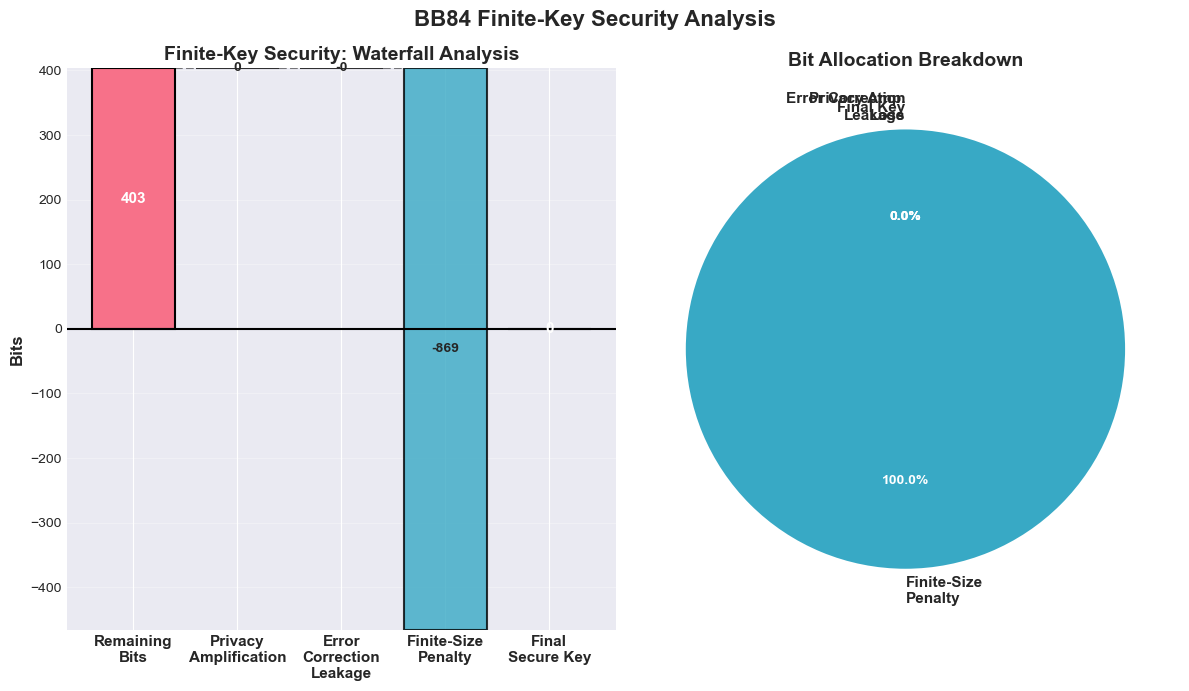


                               FINITE-KEY SECURITY ANALYSIS                               

Parameter                                Value                Description                   
------------------------------------------------------------------------------------------
Remaining bits (n_keep)                  403                  After QBER sampling           
QBER                                     0.0000 (0.00%)
Binary entropy h₂(QBER)                  0.000000
Error correction efficiency (f_EC)       1.10
Security parameter (ε_sec)               1.00e-08
Correctness parameter (ε_cor)            1.00e-12
------------------------------------------------------------------------------------------

Calculation Step                         Bits                 Formula/Note                  
------------------------------------------------------------------------------------------
1. Privacy amplification term            403.00 n × [1 - h₂(QBER)]            
2. Error correction lea

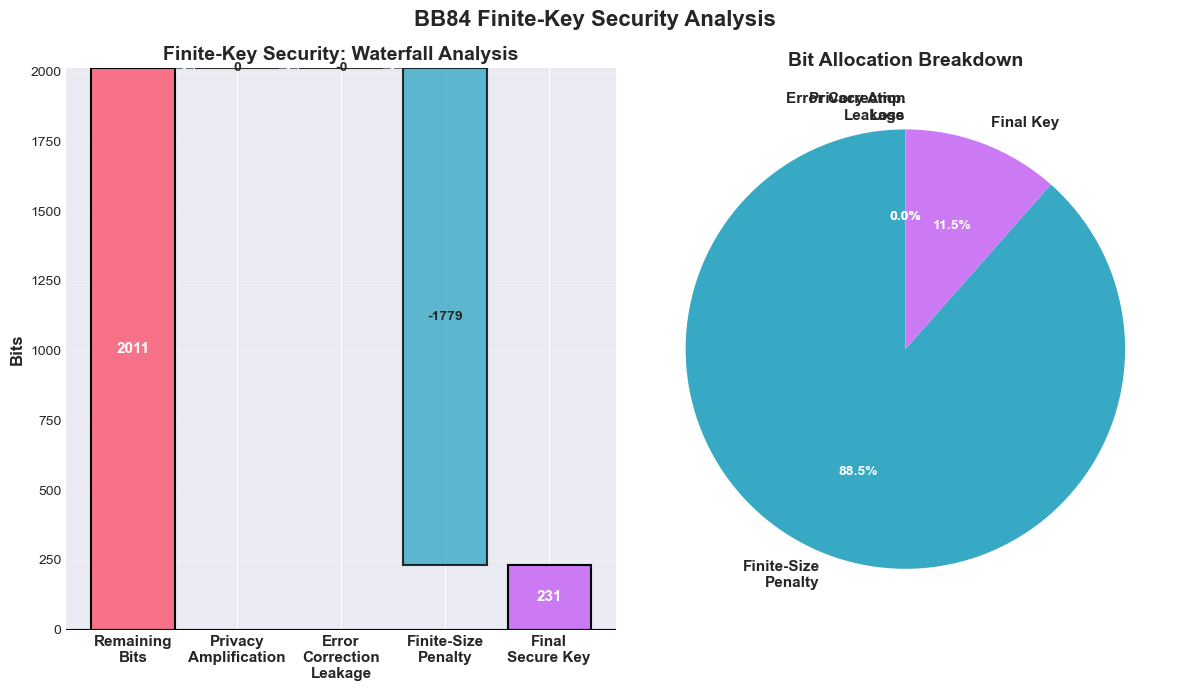


                               FINITE-KEY SECURITY ANALYSIS                               

Parameter                                Value                Description                   
------------------------------------------------------------------------------------------
Remaining bits (n_keep)                  2011                 After QBER sampling           
QBER                                     0.0000 (0.00%)
Binary entropy h₂(QBER)                  0.000000
Error correction efficiency (f_EC)       1.10
Security parameter (ε_sec)               1.00e-08
Correctness parameter (ε_cor)            1.00e-12
------------------------------------------------------------------------------------------

Calculation Step                         Bits                 Formula/Note                  
------------------------------------------------------------------------------------------
1. Privacy amplification term            2011.00 n × [1 - h₂(QBER)]            
2. Error correction le

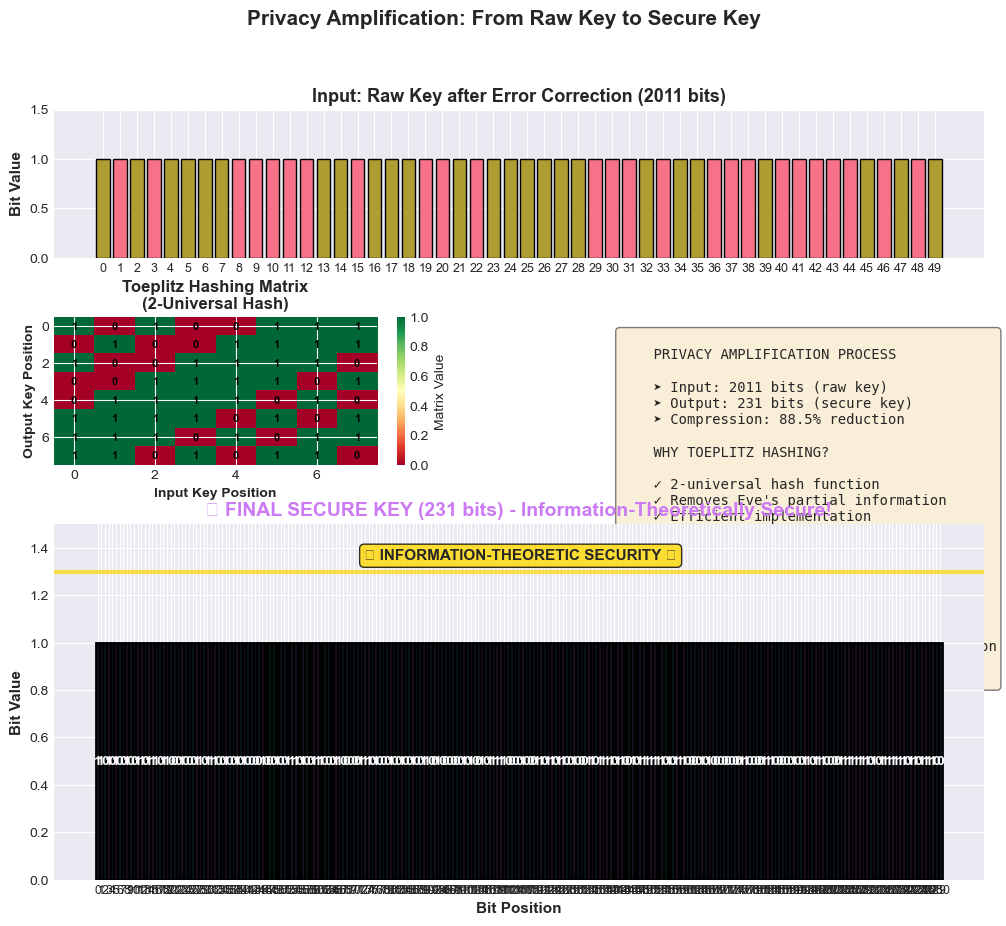


                              PRIVACY AMPLIFICATION COMPLETE                              

Input key length: 2011 bits
Output key length: 231 bits
Compression ratio: 88.5%

Alice's final secure key:
110101001001101110110001000110111001001010000100010011101001110001100000111010001001001001100100000010100101111100001000110110110010001101111011001011111110101110000101000000001100001110000010011011100001111111101011111110110111100

Bob's final secure key:
110101001001101110110001000110111001001010000100010011101001110001100000111010001001001001100100000010100101111100001000110110110010001101111011001011111110101110000101000000001100001110000010011011100001111111101011111110110111100

✅ KEYS MATCH! Secure communication established.

Security guarantees:
  • Eve's information: I(Eve:K) ≤ 1.00e-08
  • Correctness: Pr[Alice ≠ Bob] ≤ 1.00e-12
  • Universally composable security

Scenario: n=5000, noise=0.000, eve=0.00
  Sifted key: 2513 bits
  Kept bits: 2011 bits
  QBER: 0.000 (0.00%)
  Fina

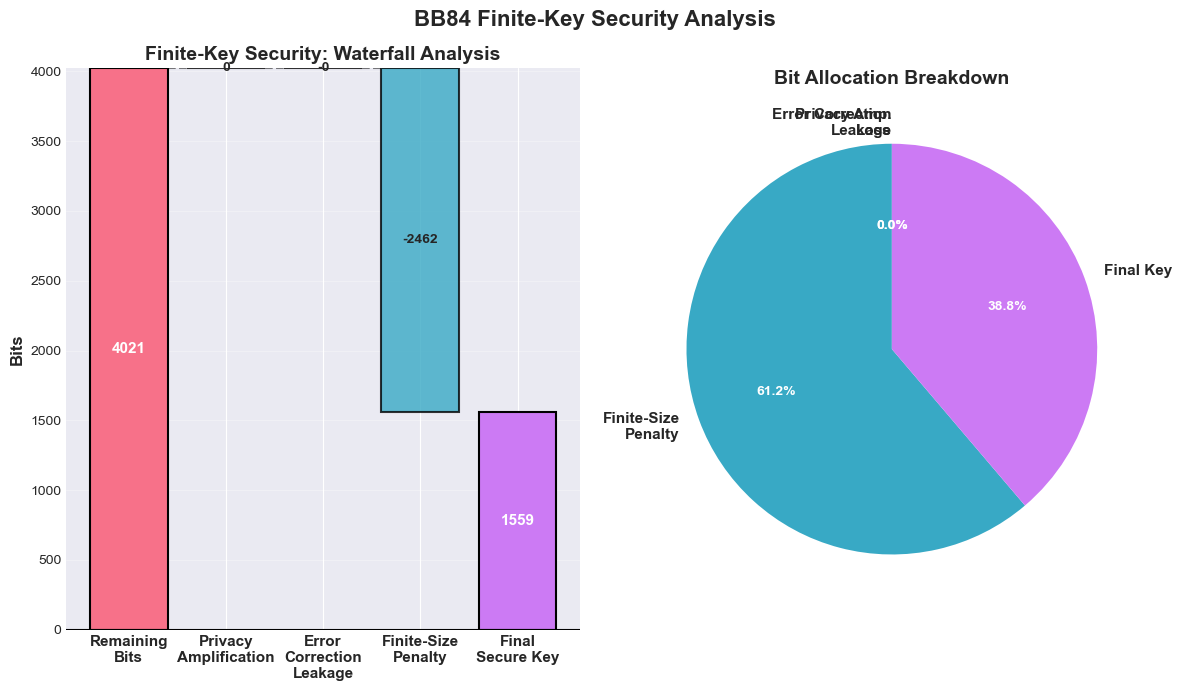


                               FINITE-KEY SECURITY ANALYSIS                               

Parameter                                Value                Description                   
------------------------------------------------------------------------------------------
Remaining bits (n_keep)                  4021                 After QBER sampling           
QBER                                     0.0000 (0.00%)
Binary entropy h₂(QBER)                  0.000000
Error correction efficiency (f_EC)       1.10
Security parameter (ε_sec)               1.00e-08
Correctness parameter (ε_cor)            1.00e-12
------------------------------------------------------------------------------------------

Calculation Step                         Bits                 Formula/Note                  
------------------------------------------------------------------------------------------
1. Privacy amplification term            4021.00 n × [1 - h₂(QBER)]            
2. Error correction le

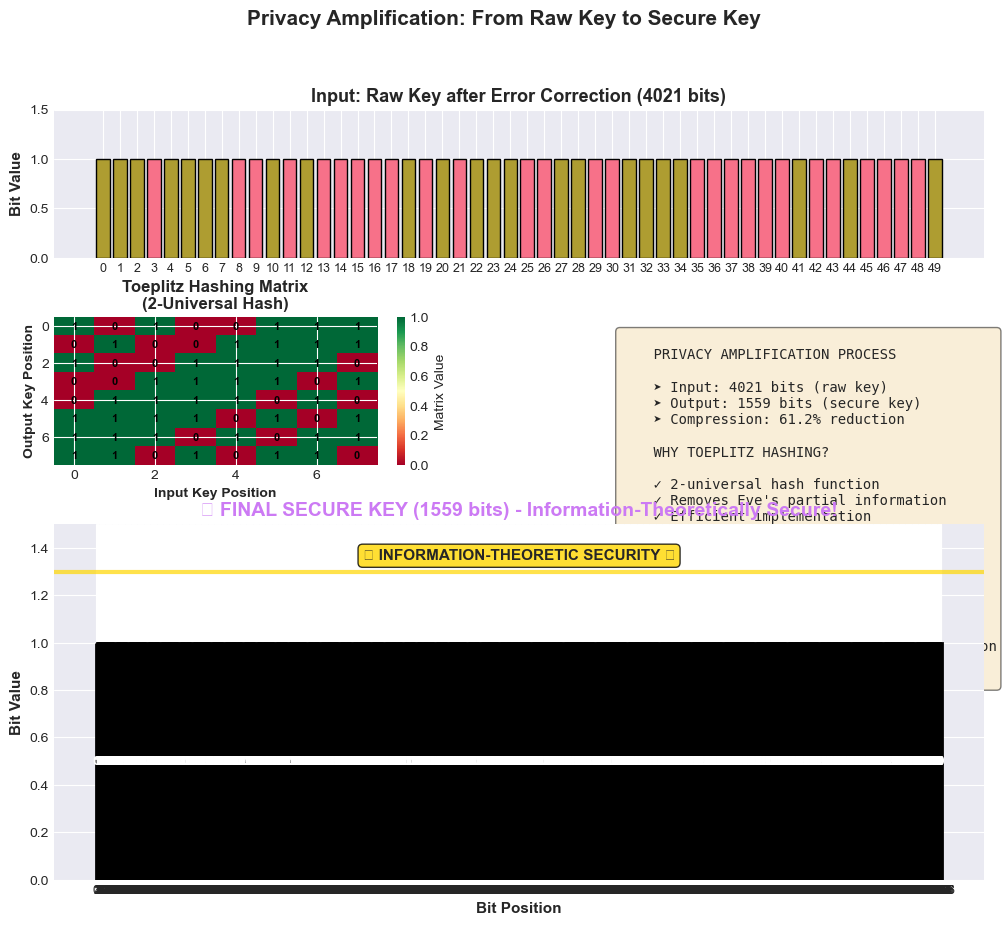


                              PRIVACY AMPLIFICATION COMPLETE                              

Input key length: 4021 bits
Output key length: 1559 bits
Compression ratio: 61.2%

Alice's final secure key:
011111100001000110110110101001010100111011011011000101101001100100100100000001001001011101100011101001010100011001010010011100000000101010100011010011101000001111000101110001011010000110010101011011110001111011111100111101111110110000010111010111100001010011010011111001110000111100100100111001010000010100000000011000001010010011100110100011101111010011100001111100101001001100010100111111101101001101011011110101110001000111000100000100011111000100110101100110000110001000110001110110101110110010101011111111110011001101111110010101001000011000000001011011001010011111001111110001011110000011010001001101010011011001011100110111010100100100111001011111101000110011001100110010101010010111010111111000101111110101111001010100011100100011011000100110010011110101110101001000010001101101101001001011

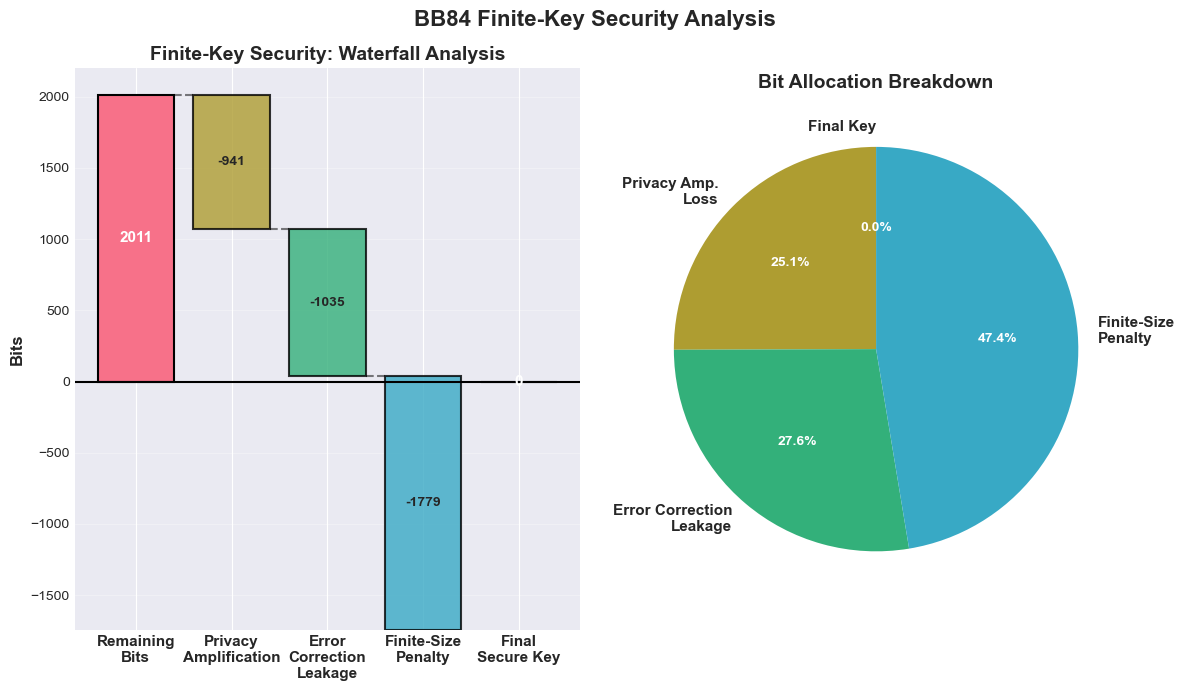


                               FINITE-KEY SECURITY ANALYSIS                               

Parameter                                Value                Description                   
------------------------------------------------------------------------------------------
Remaining bits (n_keep)                  2011                 After QBER sampling           
QBER                                     0.0996 (9.96%)
Binary entropy h₂(QBER)                  0.467731
Error correction efficiency (f_EC)       1.10
Security parameter (ε_sec)               1.00e-08
Correctness parameter (ε_cor)            1.00e-12
------------------------------------------------------------------------------------------

Calculation Step                         Bits                 Formula/Note                  
------------------------------------------------------------------------------------------
1. Privacy amplification term            1070.39 n × [1 - h₂(QBER)]            
2. Error correction le

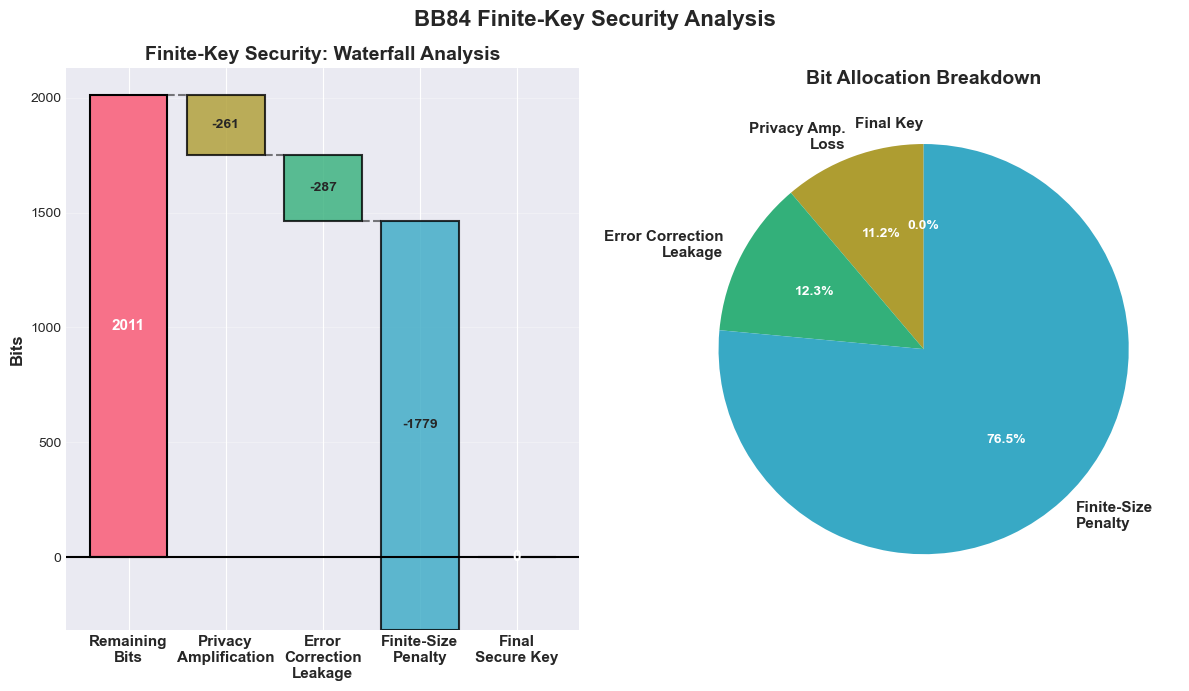


                               FINITE-KEY SECURITY ANALYSIS                               

Parameter                                Value                Description                   
------------------------------------------------------------------------------------------
Remaining bits (n_keep)                  2011                 After QBER sampling           
QBER                                     0.0179 (1.79%)
Binary entropy h₂(QBER)                  0.129645
Error correction efficiency (f_EC)       1.10
Security parameter (ε_sec)               1.00e-08
Correctness parameter (ε_cor)            1.00e-12
------------------------------------------------------------------------------------------

Calculation Step                         Bits                 Formula/Note                  
------------------------------------------------------------------------------------------
1. Privacy amplification term            1750.28 n × [1 - h₂(QBER)]            
2. Error correction le

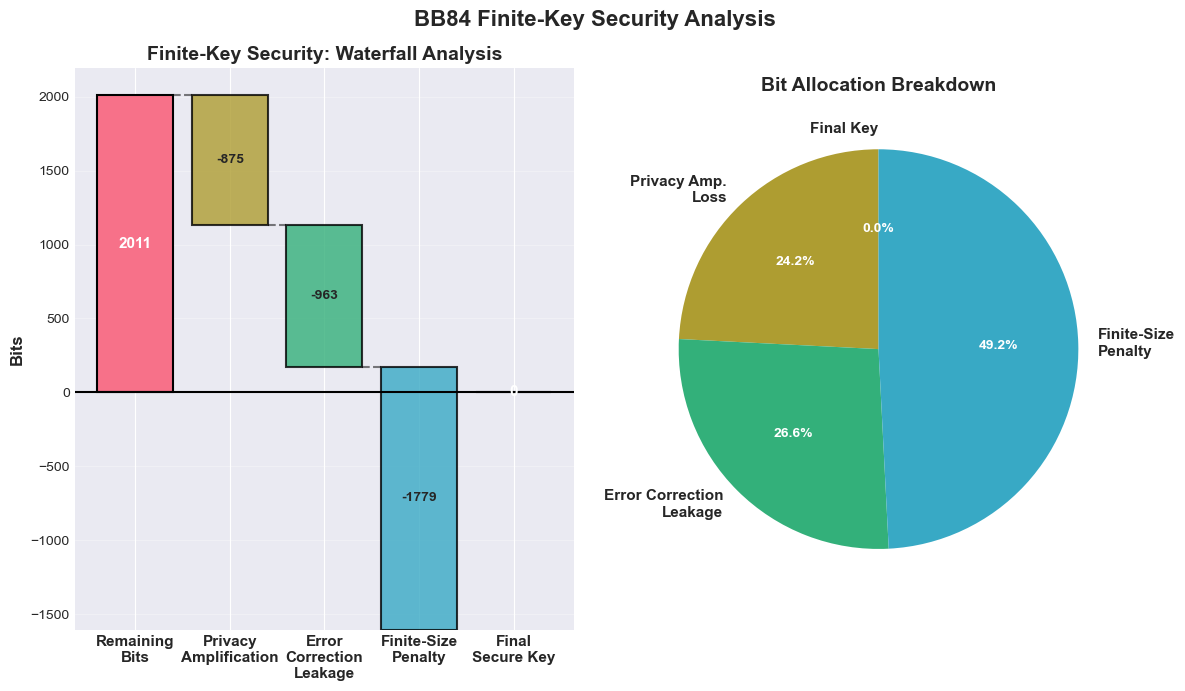


                               FINITE-KEY SECURITY ANALYSIS                               

Parameter                                Value                Description                   
------------------------------------------------------------------------------------------
Remaining bits (n_keep)                  2011                 After QBER sampling           
QBER                                     0.0896 (8.96%)
Binary entropy h₂(QBER)                  0.435272
Error correction efficiency (f_EC)       1.10
Security parameter (ε_sec)               1.00e-08
Correctness parameter (ε_cor)            1.00e-12
------------------------------------------------------------------------------------------

Calculation Step                         Bits                 Formula/Note                  
------------------------------------------------------------------------------------------
1. Privacy amplification term            1135.67 n × [1 - h₂(QBER)]            
2. Error correction le

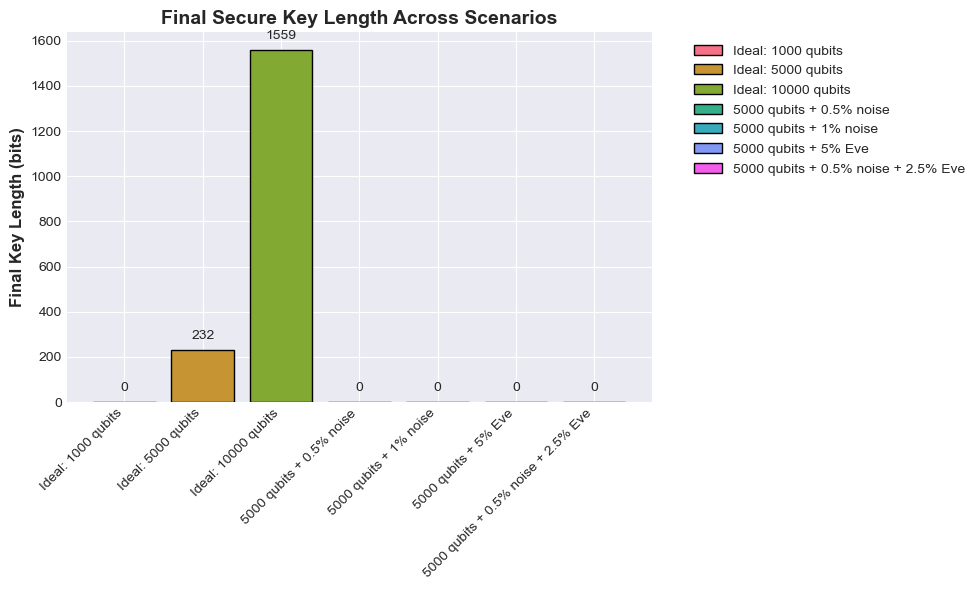

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, pauli_error

# Ensure plots display in Jupyter
%matplotlib inline

# Helper Functions
def binary_entropy(p):
    if p == 0 or p == 1:
        return 0
    if not (0 < p < 1):
        raise ValueError("p must be between 0 and 1 for binary entropy")
    return -p * np.log2(p) - (1 - p) * np.log2(1 - p)

def finite_key_penalty(eps_sec, eps_cor, n):
    if n <= 0:
        return 0
    if not (0 < eps_sec < 1 and 0 < eps_cor < 1):
        raise ValueError("eps_sec and eps_cor must be between 0 and 1")
    return 7 * np.sqrt(n * np.log2(2 / eps_sec)) + 2 * np.log2(1 / eps_cor) + 2 * np.log2(1 / (2 * eps_sec))

# Step 4: Noise Model
def create_realistic_noise_model(p_depol: float = 0.0005, p_readout: float = 0.01) -> NoiseModel:
    noise_model = NoiseModel()
    error_gate = depolarizing_error(p_depol, 1)
    noise_model.add_all_qubit_quantum_error(error_gate, ['h', 'x', 'id'])
    error_meas = pauli_error([('X', p_readout), ('I', 1 - p_readout)])
    noise_model.add_all_qubit_quantum_error(error_meas, "measure")
    return noise_model

# Step 7: Quantum Transmission
def simulate_bb84_transmission(alice_bits: np.ndarray, alice_bases: np.ndarray, 
                               bob_bases: np.ndarray, noise_level: float = 0.0005, 
                               eve_intercept_prob: float = 0.0):
    n_qubits = len(alice_bits)
    p_depol = noise_level
    p_readout = noise_level * 20  # Assume readout error is 20x depolarizing error
    noise_model = create_realistic_noise_model(p_depol, p_readout) if noise_level > 0 else None
    simulator = AerSimulator(noise_model=noise_model) if noise_model else AerSimulator()
    circuits = []
    
    for i in range(n_qubits):
        qc = QuantumCircuit(1, 1)
        if alice_bits[i] == 1:
            qc.x(0)
        if alice_bases[i] == 1:
            qc.h(0)
        qc.barrier(label='Alice→Bob')
        if np.random.random() < eve_intercept_prob:
            eve_basis = np.random.randint(0, 2)
            if eve_basis == 1:
                qc.h(0)
            qc.measure(0, 0)
            temp_circuit = transpile(qc, simulator)
            temp_result = simulator.run(temp_circuit, shots=1).result()
            eve_measured_bit = int(list(temp_result.get_counts().keys())[0])
            qc.reset(0)
            if eve_measured_bit == 1:
                qc.x(0)
            if eve_basis == 1:
                qc.h(0)
            qc.barrier(label='Eve')
        if bob_bases[i] == 1:
            qc.h(0)
        qc.measure(0, 0)
        circuits.append(qc)
    
    circuits = transpile(circuits, simulator)
    results = simulator.run(circuits, shots=1).result()
    bob_results = np.array([int(list(results.get_counts(i).keys())[0]) for i in range(n_qubits)], dtype=int)
    
    metrics = {'noise_level': noise_level, 'eve_intercept_prob': eve_intercept_prob}
    return bob_results, metrics

# Step 9: Key Sifting
def sift_key(alice_bits, alice_bases, bob_bases, bob_results):
    if not (len(alice_bits) == len(alice_bases) == len(bob_bases) == len(bob_results)):
        raise ValueError("All input arrays must have the same length")
    matching_indices = np.where(alice_bases == bob_bases)[0]
    alice_sifted = alice_bits[matching_indices]
    bob_sifted = bob_results[matching_indices]
    return alice_sifted, bob_sifted, matching_indices

# Step 12: Finite-Key Security Calculation
def calculate_finite_key_security(n_keep: int, qber: float, f_ec: float = 1.1, 
                                 eps_sec: float = 1e-8, eps_cor: float = 1e-12, 
                                 visualize: bool = False):
    if not (0 <= qber <= 0.5):
        raise ValueError("QBER must be between 0 and 0.5")
    if n_keep < 0:
        raise ValueError("n_keep must be non-negative")
    if not (f_ec >= 1):
        raise ValueError("f_ec must be >= 1")
    if not (0 < eps_sec < 1 and 0 < eps_cor < 1):
        raise ValueError("eps_sec and eps_cor must be between 0 and 1")
    
    if n_keep == 0:
        if visualize:
            print("\n" + "="*90)
            print("FINITE-KEY SECURITY ANALYSIS".center(90))
            print("="*90)
            print("No remaining bits! Cannot generate secure key.")
            print("="*90)
        return 0, {'final_length': 0, 'n_keep': 0, 'qber': qber}
    
    h2_qber = binary_entropy(qber)
    leak_ec = f_ec * n_keep * h2_qber
    delta = finite_key_penalty(eps_sec, eps_cor, n_keep)
    privacy_term = n_keep * (1 - h2_qber)
    final_key_length = max(0, privacy_term - leak_ec - delta)
    
    breakdown = {
        'n_keep': n_keep,
        'qber': qber,
        'h2_qber': h2_qber,
        'privacy_term': privacy_term,
        'leak_ec': leak_ec,
        'delta': delta,
        'final_length': final_key_length,
        'f_ec': f_ec,
        'eps_sec': eps_sec,
        'eps_cor': eps_cor
    }
    
    if visualize:
        colors = sns.color_palette("husl", 5)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))
        
        categories = ['Remaining\nBits', 'Privacy\nAmplification', 'Error\nCorrection\nLeakage', 
                      'Finite-Size\nPenalty', 'Final\nSecure Key']
        values = [n_keep, -n_keep * h2_qber, -leak_ec, -delta, final_key_length]
        cumulative = [0]
        for i, val in enumerate(values[:-1]):
            if i == 0:
                cumulative.append(values[0])
            else:
                cumulative.append(cumulative[-1] + val)
        
        for i in range(len(categories)):
            if i == 0:
                ax1.bar(i, values[i], color=colors[0], edgecolor='black', linewidth=1.5)
                ax1.text(i, values[i]/2, f'{values[i]:.0f}', ha='center', va='center',
                         fontsize=11, fontweight='bold', color='white')
            elif i == len(categories) - 1:
                ax1.bar(i, values[i], color=colors[4], edgecolor='black', linewidth=1.5)
                ax1.text(i, values[i]/2, f'{int(final_key_length)}', ha='center', va='center',
                         fontsize=11, fontweight='bold', color='white')
            else:
                ax1.bar(i, abs(values[i]), bottom=cumulative[i] + min(0, values[i]), 
                        color=colors[i], edgecolor='black', linewidth=1.5, alpha=0.8)
                ax1.text(i, cumulative[i] + values[i]/2, f'{values[i]:.0f}', 
                         ha='center', va='center', fontsize=10, fontweight='bold')
        
        for i in range(len(categories) - 1):
            if i < len(categories) - 2:
                ax1.plot([i + 0.4, i + 0.6], [cumulative[i+1], cumulative[i+1]], 
                         'k--', linewidth=1.5, alpha=0.5)
        
        ax1.set_xticks(range(len(categories)))
        ax1.set_xticklabels(categories, fontsize=11, fontweight='bold')
        ax1.set_ylabel('Bits', fontsize=12, fontweight='bold')
        ax1.set_title('Finite-Key Security: Waterfall Analysis', fontsize=14, fontweight='bold')
        ax1.grid(axis='y', alpha=0.3)
        ax1.axhline(y=0, color='black', linewidth=1.5)
        
        loss_labels = ['Privacy Amp.\nLoss', 'Error Correction\nLeakage', 'Finite-Size\nPenalty', 'Final Key']
        loss_values = [n_keep * h2_qber, leak_ec, delta, final_key_length]
        loss_values_positive = [abs(v) for v in loss_values]
        wedges, texts, autotexts = ax2.pie(loss_values_positive, labels=loss_labels, 
                                           colors=[colors[1], colors[2], colors[3], colors[4]],
                                           autopct='%1.1f%%', startangle=90, 
                                           textprops={'fontsize': 11, 'fontweight': 'bold'})
        
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontsize(10)
        
        ax2.set_title('Bit Allocation Breakdown', fontsize=14, fontweight='bold')
        
        plt.suptitle('BB84 Finite-Key Security Analysis', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        print("\n" + "="*90)
        print("FINITE-KEY SECURITY ANALYSIS".center(90))
        print("="*90)
        print(f"\n{'Parameter':<40} {'Value':<20} {'Description':<30}")
        print("-" * 90)
        print(f"{'Remaining bits (n_keep)':<40} {n_keep:<20} {'After QBER sampling':<30}")
        print(f"{'QBER':<40} {qber:.4f} ({qber*100:.2f}%)")
        print(f"{'Binary entropy h₂(QBER)':<40} {h2_qber:.6f}")
        print(f"{'Error correction efficiency (f_EC)':<40} {f_ec:.2f}")
        print(f"{'Security parameter (ε_sec)':<40} {eps_sec:.2e}")
        print(f"{'Correctness parameter (ε_cor)':<40} {eps_cor:.2e}")
        print("-" * 90)
        print(f"\n{'Calculation Step':<40} {'Bits':<20} {'Formula/Note':<30}")
        print("-" * 90)
        print(f"{'1. Privacy amplification term':<40} {privacy_term:.2f} {'n × [1 - h₂(QBER)]':<30}")
        print(f"{'2. Error correction leakage':<40} {-leak_ec:.2f} {'f_EC × n × h₂(QBER)':<30}")
        print(f"{'3. Finite-size penalty':<40} {-delta:.2f} {'Finite-size correction':<30}")
        print("-" * 90)
        print(f"{'FINAL SECURE KEY LENGTH':<40} {int(final_key_length)} {'bits':<30}")
        print("="*90)
        
        if final_key_length > 0:
            efficiency = (final_key_length / n_keep) * 100
            print(f"\n✅ SECURE KEY GENERATED!")
            print(f"   Final key length: {int(final_key_length)} bits")
            print(f"   Efficiency: {efficiency:.2f}% (secure bits / remaining bits)")
            print(f"   Security level: ε_sec = {eps_sec:.2e}")
        else:
            print(f"\n❌ INSUFFICIENT BITS FOR SECURE KEY")
            print(f"   Need larger block size or better channel quality")
            print(f"   Current shortage: {abs(final_key_length):.2f} bits")
        print("="*90)
    
    return final_key_length, breakdown

# Step 13: Privacy Amplification (Toeplitz Hashing)
def toeplitz_hash(key_bits: np.ndarray, output_len: int, seed: int = 42) -> np.ndarray:
    n_in = len(key_bits)
    if output_len <= 0 or output_len > n_in:
        return np.array([], dtype=int)
    
    np.random.seed(seed)
    toeplitz_seed = np.random.randint(0, 2, n_in + output_len - 1)
    
    output = np.zeros(output_len, dtype=int)
    for i in range(output_len):
        for j in range(n_in):
            output[i] ^= (key_bits[j] * toeplitz_seed[i + j])
    
    return output

def visualize_privacy_amplification(alice_sifted, bob_sifted, keep_indices, 
                                    final_key_length, breakdown, seed=42):
    if final_key_length <= 0:
        print("⚠️  Cannot perform privacy amplification: final_key_length ≤ 0")
        return None, None
    
    alice_kept = alice_sifted[keep_indices]
    bob_kept = bob_sifted[keep_indices]
    raw_key = alice_kept  # Assumes error correction
    
    final_length_int = int(final_key_length)
    alice_final_key = toeplitz_hash(raw_key, final_length_int, seed=seed)
    bob_final_key = toeplitz_hash(bob_kept, final_length_int, seed=seed)
    
    colors = sns.color_palette("husl", 5)
    fig = plt.figure(figsize=(12, 10))
    gs = fig.add_gridspec(4, 2, hspace=0.4, wspace=0.3)
    
    ax1 = fig.add_subplot(gs[0, :])
    n_input = len(raw_key)
    x_input = np.arange(min(n_input, 50))
    colors_input = [colors[0] if bit == 1 else colors[1] for bit in raw_key[:50]]
    
    ax1.bar(x_input, np.ones(len(x_input)), color=colors_input, edgecolor='black', linewidth=1)
    ax1.set_ylabel('Bit Value', fontsize=11, fontweight='bold')
    ax1.set_ylim(0, 1.5)
    ax1.set_xticks(x_input)
    ax1.set_xticklabels(x_input, fontsize=9)
    ax1.set_title(f'Input: Raw Key after Error Correction ({n_input} bits)', 
                 fontsize=13, fontweight='bold')
    
    if n_input <= 50:
        for i, bit in enumerate(raw_key[:50]):
            ax1.text(i, 0.5, str(bit), ha='center', va='center', 
                    fontsize=8, fontweight='bold', color='white')
    
    ax2 = fig.add_subplot(gs[1, 0])
    example_size = min(8, final_length_int, n_input)
    toeplitz_seed_example = np.random.RandomState(seed).randint(0, 2, 
                                                                 example_size + example_size - 1)
    
    matrix_example = np.zeros((example_size, example_size))
    for i in range(example_size):
        for j in range(example_size):
            matrix_example[i, j] = toeplitz_seed_example[i + j]
    
    im = ax2.imshow(matrix_example, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
    ax2.set_xlabel('Input Key Position', fontsize=10, fontweight='bold')
    ax2.set_ylabel('Output Key Position', fontsize=10, fontweight='bold')
    ax2.set_title('Toeplitz Hashing Matrix\n(2-Universal Hash)', 
                 fontsize=12, fontweight='bold')
    
    for i in range(example_size):
        for j in range(example_size):
            ax2.text(j, i, int(matrix_example[i, j]),
                    ha="center", va="center", color="black", fontsize=8, fontweight='bold')
    
    plt.colorbar(im, ax=ax2, label='Matrix Value')
    
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.axis('off')
    explanation = f"""
    PRIVACY AMPLIFICATION PROCESS
    
    ➤ Input: {n_input} bits (raw key)
    ➤ Output: {final_length_int} bits (secure key)
    ➤ Compression: {(1 - final_length_int/n_input)*100:.1f}% reduction
    
    WHY TOEPLITZ HASHING?
    
    ✓ 2-universal hash function
    ✓ Removes Eve's partial information
    ✓ Efficient implementation
    ✓ Provably secure (leftover hash lemma)
    
    SECURITY GUARANTEE:
    
    Eve's information about final key:
    I(Eve : Final Key) ≤ ε_sec = {breakdown['eps_sec']:.2e}
    
    This means Eve has negligible information
    about the final secure key!
    """
    
    ax3.text(0.1, 0.9, explanation, transform=ax3.transAxes, 
            fontsize=10, verticalalignment='top', family='monospace',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    ax4 = fig.add_subplot(gs[2:, :])
    x_output = np.arange(final_length_int)
    colors_output = [colors[4] if bit == 1 else colors[3] for bit in alice_final_key]
    
    ax4.bar(x_output, np.ones(final_length_int), color=colors_output, 
           edgecolor='black', linewidth=2)
    ax4.set_ylabel('Bit Value', fontsize=11, fontweight='bold')
    ax4.set_xlabel('Bit Position', fontsize=11, fontweight='bold')
    ax4.set_ylim(0, 1.5)
    ax4.set_xticks(x_output)
    ax4.set_xticklabels(x_output, fontsize=9)
    ax4.set_title(f'✅ FINAL SECURE KEY ({final_length_int} bits) - Information-Theoretically Secure!', 
                 fontsize=14, fontweight='bold', color=colors[4])
    
    for i, bit in enumerate(alice_final_key):
        ax4.text(i, 0.5, str(bit), ha='center', va='center', 
                fontsize=10, fontweight='bold', color='white')
    
    ax4.axhline(y=1.3, color='gold', linewidth=3, alpha=0.7)
    ax4.text(final_length_int/2, 1.35, '🔐 INFORMATION-THEORETIC SECURITY 🔐', 
            ha='center', fontsize=11, fontweight='bold', 
            bbox=dict(boxstyle='round', facecolor='gold', alpha=0.8))
    
    plt.suptitle('Privacy Amplification: From Raw Key to Secure Key', 
                fontsize=15, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*90)
    print("PRIVACY AMPLIFICATION COMPLETE".center(90))
    print("="*90)
    print(f"\nInput key length: {n_input} bits")
    print(f"Output key length: {final_length_int} bits")
    print(f"Compression ratio: {(1 - final_length_int/n_input)*100:.1f}%")
    print(f"\nAlice's final secure key:")
    print(''.join(map(str, alice_final_key)))
    print(f"\nBob's final secure key:")
    print(''.join(map(str, bob_final_key)))
    
    if np.array_equal(alice_final_key, bob_final_key):
        print(f"\n✅ KEYS MATCH! Secure communication established.")
    else:
        errors = np.sum(alice_final_key != bob_final_key)
        print(f"\n⚠️  Keys differ in {errors} positions (error correction needed)")
    
    print(f"\nSecurity guarantees:")
    print(f"  • Eve's information: I(Eve:K) ≤ {breakdown['eps_sec']:.2e}")
    print(f"  • Correctness: Pr[Alice ≠ Bob] ≤ {breakdown['eps_cor']:.2e}")
    print(f"  • Universally composable security")
    print("="*90)
    
    return alice_final_key, bob_final_key

# Cell 14: Run BB84 with Different Parameters (Fixed)
def run_bb84_complete(
    n_qubits: int,
    noise_level: float = 0.0,
    eve_intercept_prob: float = 0.0,
    sample_fraction: float = 0.2,
    seed: int = 42,
    verbose: bool = True
):
    np.random.seed(seed)
    alice_bits = np.array(np.random.randint(0, 2, n_qubits), dtype=int)
    alice_bases = np.array(np.random.randint(0, 2, n_qubits), dtype=int)
    
    np.random.seed(seed + 1)
    bob_bases = np.array(np.random.randint(0, 2, n_qubits), dtype=int)
    
    bob_results, metrics = simulate_bb84_transmission(
        alice_bits, alice_bases, bob_bases, noise_level, eve_intercept_prob
    )
    
    alice_sifted, bob_sifted, matching_indices = sift_key(alice_bits, alice_bases, bob_bases, bob_results)
    n_sifted = len(alice_sifted)
    
    if n_sifted == 0:
        results = {
            'n_qubits': n_qubits,
            'n_sifted': 0,
            'n_keep': 0,
            'qber': 1.0,
            'final_key_length': 0,
            'efficiency': 0,
            'noise_level': noise_level,
            'eve_rate': eve_intercept_prob,
            'success': False,
            'abort_reason': 'No sifted key'
        }
        if verbose:
            print(f"\nScenario: n={n_qubits}, noise={noise_level:.3f}, eve={eve_intercept_prob:.2f}")
            print(f"  Sifted key: {n_sifted} bits")
            print(f"  Failed: {results['abort_reason']}")
        return results
    
    np.random.seed(seed + 2)
    n_reveal = int(n_sifted * sample_fraction)
    n_keep = n_sifted - n_reveal
    reveal_indices = np.random.choice(n_sifted, n_reveal, replace=False)
    keep_indices = np.array([i for i in range(n_sifted) if i not in reveal_indices])
    
    revealed_alice = alice_sifted[reveal_indices]
    revealed_bob = bob_sifted[reveal_indices]
    errors = np.sum(revealed_alice != revealed_bob)
    qber = errors / n_reveal if n_reveal > 0 else 0
    
    if qber >= 0.11 or n_keep <= 0:
        results = {
            'n_qubits': n_qubits,
            'n_sifted': n_sifted,
            'n_keep': n_keep,
            'qber': qber,
            'final_key_length': 0,
            'efficiency': 0,
            'noise_level': noise_level,
            'eve_rate': eve_intercept_prob,
            'success': False,
            'abort_reason': 'QBER too high' if qber >= 0.11 else 'Insufficient bits'
        }
        if verbose:
            print(f"\nScenario: n={n_qubits}, noise={noise_level:.3f}, eve={eve_intercept_prob:.2f}")
            print(f"  Sifted key: {n_sifted} bits")
            print(f"  Kept bits: {n_keep} bits")
            print(f"  QBER: {qber:.3f} ({qber*100:.2f}%)")
            print(f"  Final key length: {results['final_key_length']:.1f} bits")
            print(f"  Efficiency: {results['efficiency']*100:.2f}%")
            print(f"  Failed: {results['abort_reason']}")
        return results
    
    final_key_length, breakdown = calculate_finite_key_security(
        n_keep, qber, f_ec=1.1, eps_sec=1e-8, eps_cor=1e-12, visualize=verbose
    )
    
    alice_final_key, bob_final_key = None, None
    if final_key_length > 0 and verbose:
        alice_final_key, bob_final_key = visualize_privacy_amplification(
            alice_sifted, bob_sifted, keep_indices, final_key_length, breakdown, seed=seed+3
        )
    
    results = {
        'n_qubits': n_qubits,
        'n_sifted': n_sifted,
        'n_keep': n_keep,
        'qber': qber,
        'noise_level': noise_level,
        'eve_rate': eve_intercept_prob,
        'final_key_length': max(0, final_key_length),
        'efficiency': max(0, final_key_length) / n_qubits if n_qubits > 0 else 0,
        'success': final_key_length > 0,
        'breakdown': breakdown,
        'alice_final_key': alice_final_key,
        'bob_final_key': bob_final_key
    }
    
    if verbose:
        print(f"\nScenario: n={n_qubits}, noise={noise_level:.3f}, eve={eve_intercept_prob:.2f}")
        print(f"  Sifted key: {n_sifted} bits")
        print(f"  Kept bits: {n_keep} bits")
        print(f"  QBER: {qber:.3f} ({qber*100:.2f}%)")
        print(f"  Final key length: {results['final_key_length']:.1f} bits")
        print(f"  Efficiency: {results['efficiency']*100:.2f}%")
        if not results['success']:
            print(f"  Failed: {results.get('abort_reason', 'Unknown reason')}")

    return results

# Run multiple scenarios
print("="*90)
print("RUNNING MULTIPLE BB84 SCENARIOS".center(90))
print("="*90)

scenarios = [
    {'n': 1000, 'noise': 0.0, 'eve': 0.0, 'label': 'Ideal: 1000 qubits'},
    {'n': 5000, 'noise': 0.0, 'eve': 0.0, 'label': 'Ideal: 5000 qubits'},
    {'n': 10000, 'noise': 0.0, 'eve': 0.0, 'label': 'Ideal: 10000 qubits'},
    {'n': 5000, 'noise': 0.005, 'eve': 0.0, 'label': '5000 qubits + 0.5% noise'},
    {'n': 5000, 'noise': 0.01, 'eve': 0.0, 'label': '5000 qubits + 1% noise'},
    {'n': 5000, 'noise': 0.0, 'eve': 0.05, 'label': '5000 qubits + 5% Eve'},
    {'n': 5000, 'noise': 0.005, 'eve': 0.025, 'label': '5000 qubits + 0.5% noise + 2.5% Eve'},
]

results_list = []
for scenario in scenarios:
    result = run_bb84_complete(
        n_qubits=scenario['n'],
        noise_level=scenario['noise'],
        eve_intercept_prob=scenario['eve'],
        sample_fraction=0.2,
        seed=42,
        verbose=True
    )
    result['label'] = scenario['label']
    results_list.append(result)

# Plot results
colors = sns.color_palette("husl", len(scenarios))
plt.figure(figsize=(10, 6))
for i, result in enumerate(results_list):
    plt.bar(i, result['final_key_length'], color=colors[i], edgecolor='black', label=result['label'])
    plt.text(i, result['final_key_length'] + 50, f"{result['final_key_length']:.0f}", 
             ha='center', fontsize=10)

plt.xticks(range(len(scenarios)), [r['label'] for r in results_list], rotation=45, ha='right')
plt.ylabel('Final Key Length (bits)', fontsize=12, fontweight='bold')
plt.title('Final Secure Key Length Across Scenarios', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print("="*90)